# The file is an analysis of the preliminary $\alpha_{\textrm{CE}}$ variation run following the methods in the tutorial from the compas repo.

In [6]:
import os
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
import h5py as h5
import astropy.units as u
import warnings
import math
import seaborn as sns

from matplotlib import rc
from KDEpy import FFTKDE  # Fastest 1D algorithm
from   astropy.cosmology import WMAP9 as cosmology
from scipy import stats
from   scipy.optimize import newton

# Import COMPAS root directory and set data
compasRootDir   = '/Users/adamboesky/Research/PRISE/COMPAS'

# Import COMPAS specific scripts
sys.path.append(compasRootDir + '/utils/CosmicIntegration/')
sys.path.append(os.getcwd() + '/Scripts')
import ClassCOMPAS, ClassMSSFR, ClassCosmicIntegrator 
import FastCosmicIntegration as FCI 
import selection_effects
import formation_channels

# Magic function to set the backend of matplotlib to the 'inline' backend
%matplotlib inline

#Set latex environment for plots/labels
# plt.rcParams['text.latex.preamble'] = r'\usepackage{sfmath} \boldmath'
plt.rcParams['text.usetex'] = True
# plt.rcParams['font.weight'] = 'bold'
plt.rcParams['font.family'] = 'serif'
# plt.rcParams['axes.labelweight'] = 'bold'
# plt.rcParams['font.sans-serif'] = 'serif'
# plt.rcParams['mathtext.fontset'] = 'stix'

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_21950/4056035850.py:43: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


# 1. Create Compas data objects

##  a) Condense the each of the batch's outputs into one h5 file
Function that combines all of the h5 files from each batch. It will write and return the complete h5 file

In [3]:
def condense_h5s(output_dir):

    index = 0 # A useful variable for indexing through the files in the output directory

    # Iterate through the files in the output directory
    for dir in os.listdir(output_dir):
        
        # Make sure that the directories are from the batches
        if dir[0:5] == 'batch':
            batch_num = dir [-1]
            f_h5 = h5.File(output_dir + '/batch_' + batch_num + '/batch_' + batch_num + '.h5', 'r')
            
            # If it's the first batch directory, create an h5 file and copy the first batch's contents into it
            if index == 0:
                # Create an h5 file to put all of the batch's h5 files in
                complete_h5 = h5.File(output_dir + '/complete.h5', 'w')

                # Create and copy the first batch's h5 file into the complete_h5 file
                # DCOs = complete_h5.create_group('BSE_Double_Compact_Objects')
                for group in f_h5.keys():
                    # complete_h5.create_group(group)
                    f_h5.copy(f_h5[group], complete_h5)
                
                DCOs = complete_h5['BSE_Double_Compact_Objects']
                CEs = complete_h5['BSE_Common_Envelopes']
                RLOFs = complete_h5['BSE_RLOF']
                SNs = complete_h5['BSE_Supernovae']
                SPs = complete_h5['BSE_System_Parameters']
                RDs = complete_h5['Run_Details']
                
            # If it's not the first directory, append the new data to each group in the complete h5 file
            else:
                # Append new data to it
                for key in DCOs.keys():
                    DCOs[key].resize((DCOs[key].shape[0] + f_h5['BSE_Double_Compact_Objects'][key].shape[0]), axis=0)
                    DCOs[key][-f_h5['BSE_Double_Compact_Objects'][key].shape[0]:] = f_h5['BSE_Double_Compact_Objects'][key]
                
                for key in CEs.keys():
                    CEs[key].resize((CEs[key].shape[0] + f_h5['BSE_Common_Envelopes'][key].shape[0]), axis=0)
                    CEs[key][-f_h5['BSE_Common_Envelopes'][key].shape[0]:] = f_h5['BSE_Common_Envelopes'][key]
                
                for key in RLOFs.keys():
                    RLOFs[key].resize((RLOFs[key].shape[0] + f_h5['BSE_RLOF'][key].shape[0]), axis=0)
                    RLOFs[key][-f_h5['BSE_RLOF'][key].shape[0]:] = f_h5['BSE_RLOF'][key]
                
                for key in SNs.keys():
                    SNs[key].resize((SNs[key].shape[0] + f_h5['BSE_Supernovae'][key].shape[0]), axis=0)
                    SNs[key][-f_h5['BSE_Supernovae'][key].shape[0]:] = f_h5['BSE_Supernovae'][key]
                
                for key in SPs.keys():
                    SPs[key].resize((SPs[key].shape[0] + f_h5['BSE_System_Parameters'][key].shape[0]), axis=0)
                    SPs[key][-f_h5['BSE_System_Parameters'][key].shape[0]:] = f_h5['BSE_System_Parameters'][key]
                
                for key in RDs.keys():
                    RDs[key].resize((RDs[key].shape[0] + f_h5['Run_Details'][key].shape[0]), axis=0)
                    RDs[key][-f_h5['Run_Details'][key].shape[0]:] = f_h5['Run_Details'][key]

            index+=1 # Update the index
            f_h5.close() # Close the batch file

    complete_h5.close() # Close the complete h5 file
    return output_dir + '/complete.h5'

## b) Condense all .h5 file outputs for the common envelope alpha values

In [5]:
alpha_vals = ['0.1', '0.5', '2.0', '10.0'] # All the alpha values
beta_vals = ['0.25', '0.5', '0.75'] # All the beta values

condensed_paths = {} # 2D dictionary holding the paths to the output h5 files for which the first dimension is the alpha CE value and the second is the beta value

for alpha in alpha_vals:
    condensed_paths[alpha] = {}
    for beta in beta_vals:
        condensed_paths[alpha][beta] = condense_h5s('/Users/adamboesky/Research/PRISE/exploring_parameter_space/Data/2output_alpha_CE_beta_corrected_dists/output_alpha_CE_' + alpha + '_beta_' + beta)

## c) *** To use if the h5 files have already been condensed! ***

In [2]:
alpha_vals = ['0.1', '0.5', '2.0', '10.0'] # All the alpha values
beta_vals = ['0.25', '0.5', '0.75'] # All the beta values

condensed_paths = {} # 2D dictionary holding the paths to the output h5 files for which the first dimension is the alpha CE value and the second is the beta value

for alpha in alpha_vals:
    condensed_paths[alpha] = {}
    for beta in beta_vals:
        condensed_paths[alpha][beta] = '/Users/adamboesky/Research/PRISE/exploring_parameter_space/Data/2output_alpha_CE_beta_corrected_dists/output_alpha_CE_' + alpha + '_beta_' + beta + '/complete.h5'

## d) Create COMPASData objects for each of the $\alpha_{\textrm{CE}}$ and $\beta$ values

In [3]:
# For now, assume all the defaults and just set the paths for each value
data = {} # 2D dictionary in which the first dimension is the alpha CE value and the second is the beta value
counter = 0

for alpha_index, alpha_val in enumerate(alpha_vals):
    data[alpha_val] = {}
    for beta_index, beta_val in enumerate(beta_vals):
        data[alpha_val][beta_val] = ClassCOMPAS.COMPASData(path=condensed_paths[alpha_val][beta_val])
        data[alpha_val][beta_val].Mlower = 5
        data[alpha_val][beta_val].Mupper = 150
        data[alpha_val][beta_val].binaryFraction = 1.0
        data[alpha_val][beta_val].setGridAndMassEvolved()
        data[alpha_val][beta_val].Amin = 0.01
        data[alpha_val][beta_val].Mupper = 1000
        data[alpha_val][beta_val].setCOMPASData()
        # data[alpha_val][beta_val].setCOMPASDCOmask(types='BBH')

    print('Finished ', counter, 'set of beta values')
    counter+=1


ClassCOMPAS: Remember to self.setCOMPASDCOmask()
                    then self.setCOMPASData()
          and optionally self.setGridAndMassEvolved() if using a metallicity grid
ClassCOMPAS: Remember to self.setCOMPASDCOmask()
                    then self.setCOMPASData()
          and optionally self.setGridAndMassEvolved() if using a metallicity grid
ClassCOMPAS: Remember to self.setCOMPASDCOmask()
                    then self.setCOMPASData()
          and optionally self.setGridAndMassEvolved() if using a metallicity grid
Finished  0 set of beta values
ClassCOMPAS: Remember to self.setCOMPASDCOmask()
                    then self.setCOMPASData()
          and optionally self.setGridAndMassEvolved() if using a metallicity grid
ClassCOMPAS: Remember to self.setCOMPASDCOmask()
                    then self.setCOMPASData()
          and optionally self.setGridAndMassEvolved() if using a metallicity grid
ClassCOMPAS: Remember to self.setCOMPASDCOmask()
                    then self.setCO

## c) Check the number of each type of system in the runs

In [64]:
for alpha, beta_dict in data.items():
    for beta, compas_data in beta_dict.items():
        compas_data.setCOMPASDCOmask(types='BBH', pessimistic=True)
        
        #Check if we have any system meeting the criteria
        print('Number of BBH systems at alpha_CE = {alpha} and beta = {beta}'.format(alpha=float(alpha), beta=float(beta)), np.sum(compas_data.DCOmask))

print('')

for alpha, beta_dict in data.items():
    for beta, compas_data in beta_dict.items():
        compas_data.setCOMPASDCOmask(types='BNS', pessimistic=True)
        
        #Check if we have any system meeting the criteria
        print('Number of BNS systems at alpha_CE = {alpha} and beta = {beta}'.format(alpha=float(alpha), beta=float(beta)), np.sum(compas_data.DCOmask))

print('')

for alpha, beta_dict in data.items():
    for beta, compas_data in beta_dict.items():
        compas_data.setCOMPASDCOmask(types='BHNS', pessimistic=True)
        
        #Check if we have any system meeting the criteria
        print('Number of BHNS systems at alpha_CE = {alpha} and beta = {beta}'.format(alpha=float(alpha), beta=float(beta)), np.sum(compas_data.DCOmask))

Number of BBH systems at alpha_CE = 0.1 and beta = 0.25 24553
Number of BBH systems at alpha_CE = 0.1 and beta = 0.5 36404
Number of BBH systems at alpha_CE = 0.1 and beta = 0.75 62298
Number of BBH systems at alpha_CE = 0.5 and beta = 0.25 73357
Number of BBH systems at alpha_CE = 0.5 and beta = 0.5 74703
Number of BBH systems at alpha_CE = 0.5 and beta = 0.75 84529
Number of BBH systems at alpha_CE = 2.0 and beta = 0.25 122246
Number of BBH systems at alpha_CE = 2.0 and beta = 0.5 94594
Number of BBH systems at alpha_CE = 2.0 and beta = 0.75 91322
Number of BBH systems at alpha_CE = 10.0 and beta = 0.25 57559
Number of BBH systems at alpha_CE = 10.0 and beta = 0.5 64459
Number of BBH systems at alpha_CE = 10.0 and beta = 0.75 90956

Number of BNS systems at alpha_CE = 0.1 and beta = 0.25 177
Number of BNS systems at alpha_CE = 0.1 and beta = 0.5 337
Number of BNS systems at alpha_CE = 0.1 and beta = 0.75 495
Number of BNS systems at alpha_CE = 0.5 and beta = 0.25 61
Number of BNS sys

# 3. Plot formation rate as a function of metallicity

## a) BBH

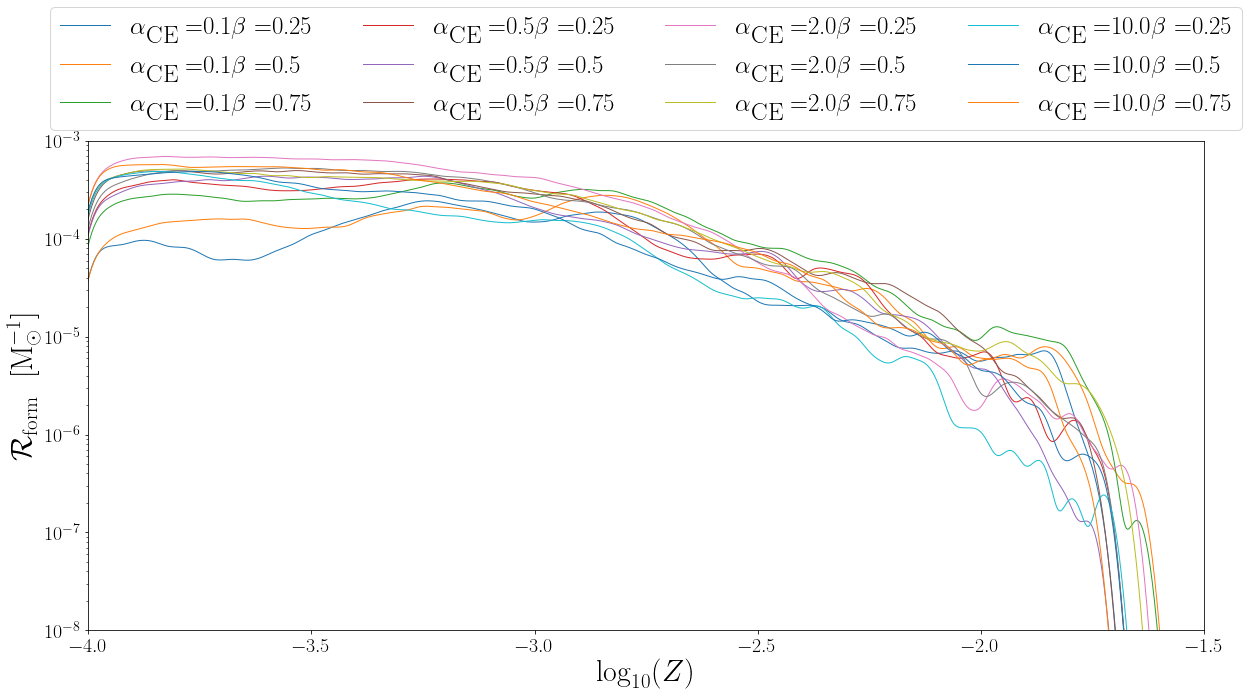

In [14]:
def plot_formation_rate_per_Z(data, alpha_vals, beta_vals, dco_type, Mlower=5, Mupper=150, binaryFraction=1.0, Amin=0.01, Amax=1000, withinHubbleTime=True, PESSIMISTIC=False, bw='silverman'):
    """
    This function plots the formation rate as a function of Z for the given data and DCO type. It will iterate over given
    alpha and beta values and plot the formation rates of their runs' results.

    ...

    Parameters
    ----------
    data : dict
        a two-dimensional dictionary containing the corresponding compas objects for each of the alpha/beta values

    alpha_vals : list
        a one dimensional list containing the alpha_CE values corresponding to the keys of the data dictionary
    
    beta_vals: list 
        a one dimensional list containing the beta values corresponding to the keys of the data dictionary's first dimension

    dco_type: str
        one of 'all', 'BBH', 'BHNS', or 'BNS'; the DCO type that we wish to look at.

    bw: float
        the bandwidth for the KDE that will be calculated for the plot

    Mlower: float
        the lower bound for the mass distribution in the data simulations

    Mupper: float
        the upper bound for the mass distribution in the data simulations

    binaryFraction: float
        the assumed binary fraction
    
    Amin: float
        the lower bound for the initial separation distribution in the data simulations

    Amax: float
        the upper bound for the initial separation distribution in the data simulations
    
    withinHubbleTime: bool
        whether or not the data should be filtered for only dcos that merge within hubble time

    PESSIMISTIC: bool
        whether or not we should filter our DCOs that have formed through a CE event involving a Hertzsprung-gap donor
    
    bw: str/float
        the bandwidth for the KDE; if not float, can be the automatic bandwidth 'silverman'
    """

    # Declare figure and figure size
    plt.figure(figsize=(20, 9))
    plt.yscale('log')
    fs = 20

    # Iterate over the 2D dictionary and plot the formation rate as a function of Z for each of the alpha_CE-beta combinations
    for alpha_val in alpha_vals:
        for beta_val in beta_vals:
            
            # Get the current compas object
            model_data = data[alpha_val][beta_val]

            # Define the parameters
            model_data.setCOMPASDCOmask(types=dco_type, withinHubbleTime=withinHubbleTime, pessimistic=PESSIMISTIC)
            model_data.Mlower = Mlower
            model_data.Mupper = Mupper
            model_data.binaryFraction = binaryFraction
            model_data.Amin = Amin
            model_data.Amax = Amax

            # Set the data
            model_data.setGridAndMassEvolved()            
            model_data.setCOMPASData()

            # Get the metallicities of the systems and declare an empty formationRate array
            metallicities = model_data.metallicitySystems
            log10metallicities = np.log10(metallicities)

            # Get the total mass evolved in the universe
            model_data_MPZ = model_data.totalMassEvolvedPerZ

            # Calculate a KDE of the metallicity distribution
            kde_grid, num_kde = FFTKDE(bw=bw).fit(log10metallicities).evaluate()

            # Calculate the formation rate as a function of metallicity = dN_form/dM_SFR (Z)
            formation_rate = num_kde *   (   len(log10metallicities) / np.sum(model_data_MPZ)   )

            # Label axes
            plt.xlabel(r'$\log_{10}(Z)$', fontsize=fs+10)
            plt.ylabel(r'$\mathcal{R}_{\rm{form}}  \ \  [\rm{M}_{\odot}^{-1}]$', fontsize=fs+10)
            
            # Bound axes
            plt.xlim([-4, -1.5])
            plt.ylim([10**(-8), 10**(-3)])

            # Adjust tick size
            plt.xticks(fontsize=fs)
            plt.yticks(fontsize=fs)

            # Plot the formation rate
            plt.plot(kde_grid, formation_rate, label=r'$\alpha_{\textrm{CE}} = $' + alpha_val + r'$\beta = $' + beta_val, lw=1)

    # Include legend
    plt.legend(fontsize=fs+5, ncol=4, bbox_to_anchor=(0.5, 1.35), loc='upper center',  markerscale=25) 

    # Show the plot!
    plt.show()

# Plot formation rate all dcos
plot_formation_rate_per_Z(data, alpha_vals, beta_vals, dco_type='BBH', bw=0.02)

## b) BHNS

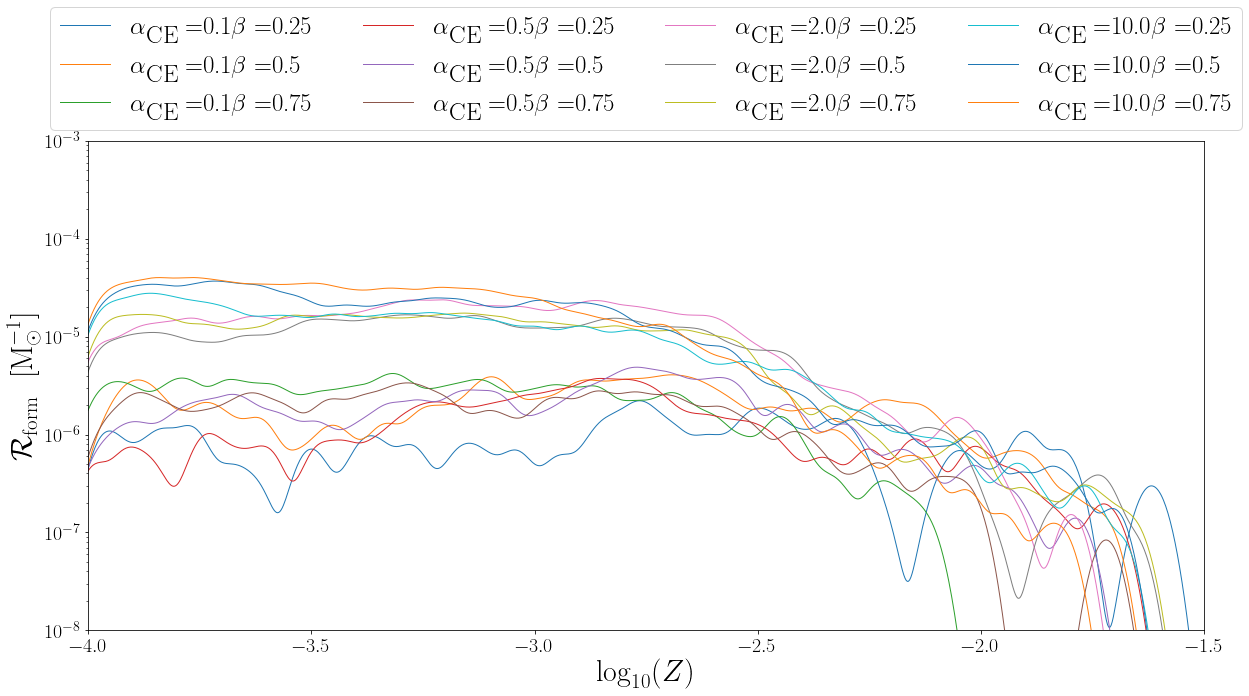

In [17]:
plot_formation_rate_per_Z(data, alpha_vals, beta_vals, dco_type='BHNS', bw=0.03)

## c) BNS

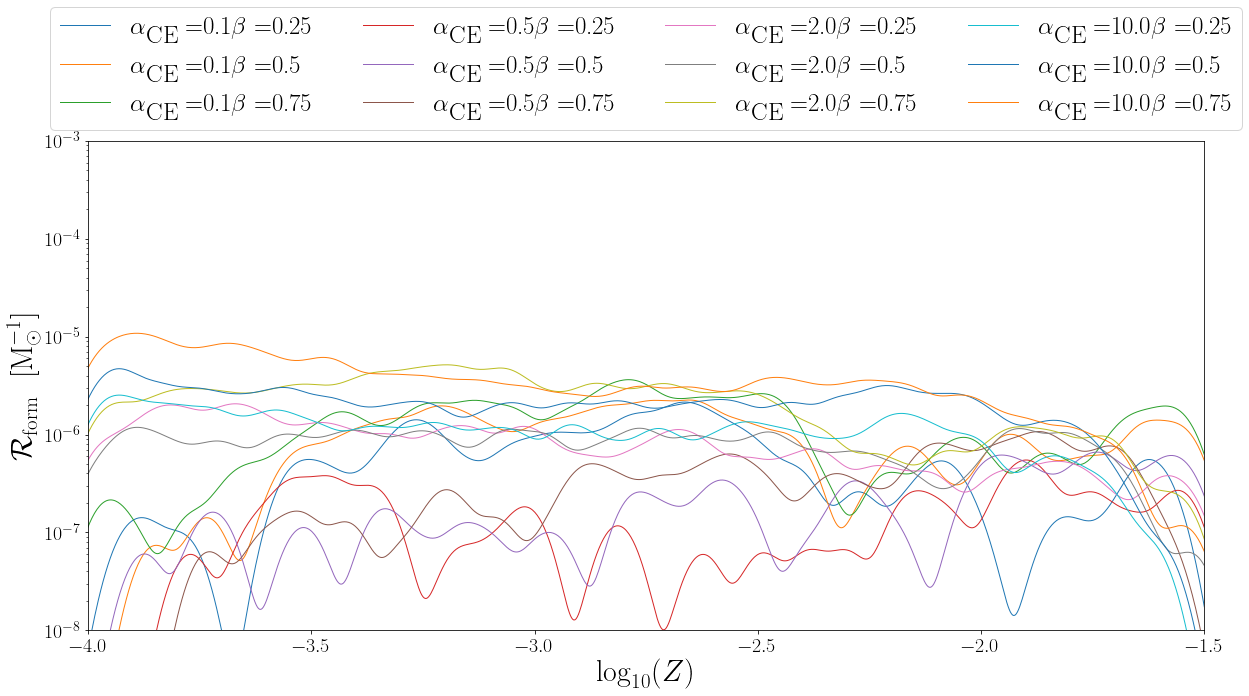

In [18]:
plot_formation_rate_per_Z(data, alpha_vals, beta_vals, dco_type='BNS', bw=0.04)

## d) Panel plot with BBH, BHNS, and BNS

Plotting panel for DCO type  BBH
Plotting panel for DCO type  BHNS
Plotting panel for DCO type  BNS


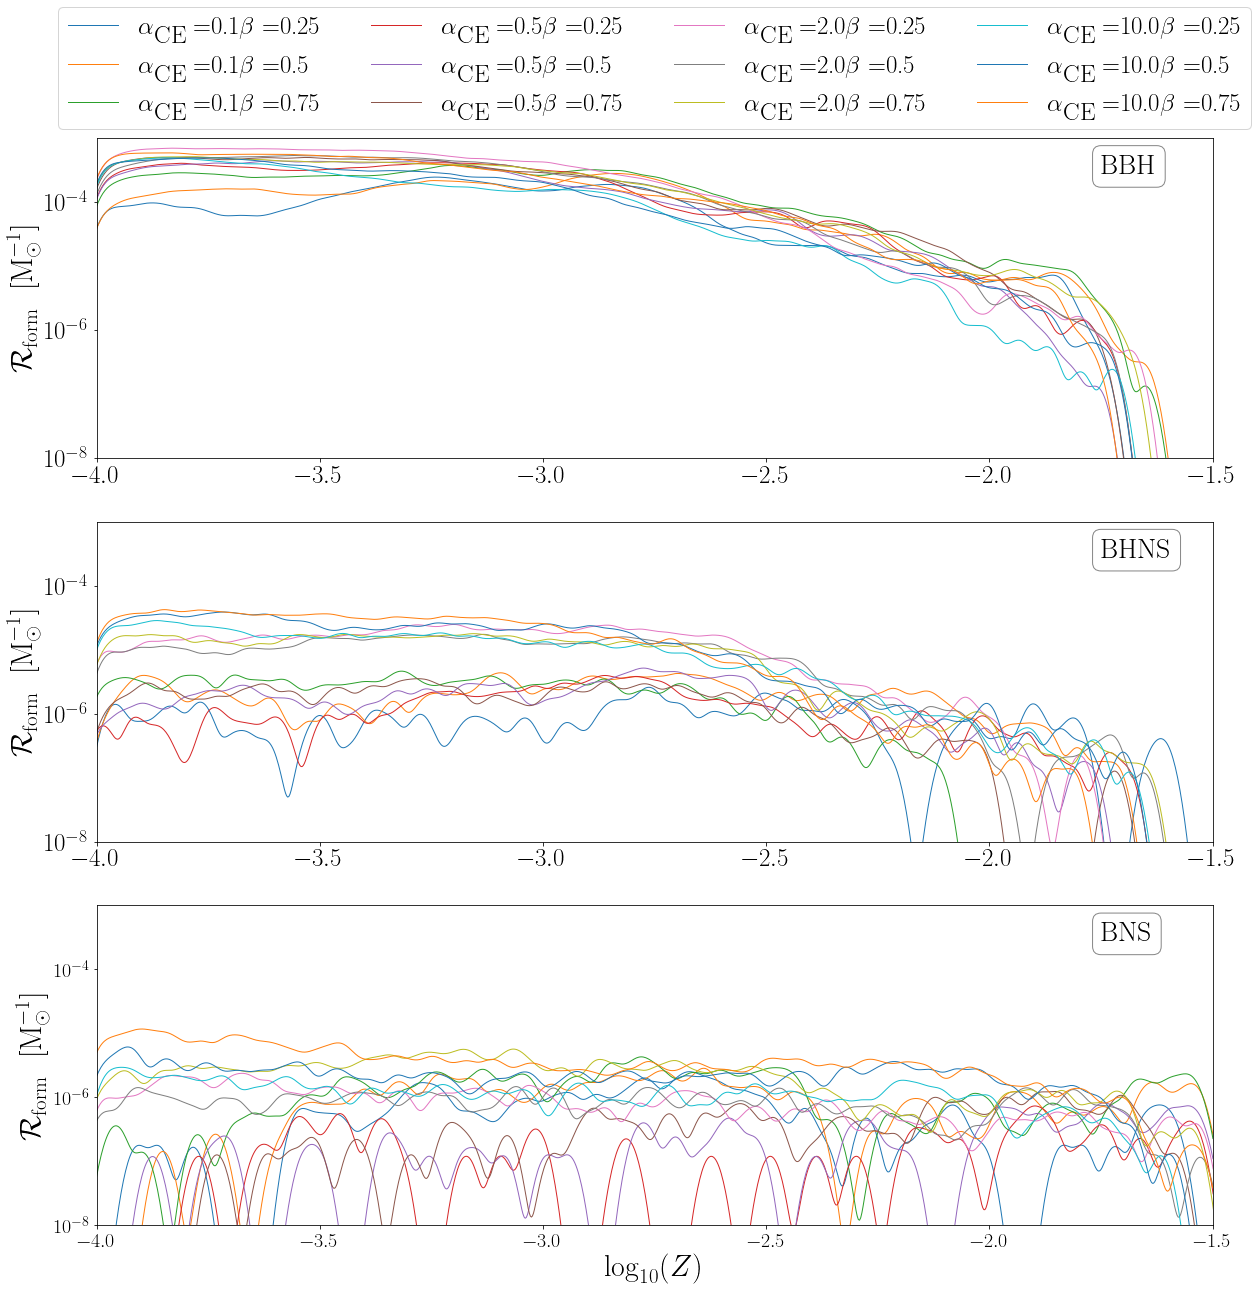

In [25]:
def plot_formation_rate_per_Z_all(data, alpha_vals, beta_vals, Mlower=5, Mupper=150, binaryFraction=1.0, Amin=0.01, Amax=1000, withinHubbleTime=True, PESSIMISTIC=False, bw='silverman'):
    """
    This function plots the formation rate as a function of Z for the given data and DCO type. It will iterate over given
    alpha and beta values and plot the formation rates of their runs' results.

    ...

    Parameters
    ----------
    data : dict
        a two-dimensional dictionary containing the corresponding compas objects for each of the alpha/beta values

    alpha_vals : list
        a one dimensional list containing the alpha_CE values corresponding to the keys of the data dictionary
    
    beta_vals: list 
        a one dimensional list containing the beta values corresponding to the keys of the data dictionary's first dimension
    
    bw: float
        the bandwidth for the KDE that will be calculated for the plot

    Mlower: float
        the lower bound for the mass distribution in the data simulations

    Mupper: float
        the upper bound for the mass distribution in the data simulations

    binaryFraction: float
        the assumed binary fraction
    
    Amin: float
        the lower bound for the initial separation distribution in the data simulations

    Amax: float
        the upper bound for the initial separation distribution in the data simulations
    
    withinHubbleTime: bool
        whether or not the data should be filtered for only dcos that merge within hubble time

    PESSIMISTIC: bool
        whether or not we should filter our DCOs that have formed through a CE event involving a Hertzsprung-gap donor
    
    bw: str/float
        the bandwidth for the KDE; if not float, can be the automatic bandwidth 'silverman'
    """

    # Declare figure
    fig, axes = plt.subplots(ncols=1, nrows=3, figsize=(20,20), 
                    gridspec_kw={"width_ratios":1*np.ones(1), "height_ratios":1*np.ones(3)})  
    fs = 20
    
    # DCO types
    dco_types = ['BBH', 'BHNS', 'BNS']

    # Adjust tick size
    plt.rc('xtick', labelsize=25) 
    plt.rc('ytick', labelsize=25)

    # Make everything bold
    plt.rcParams["font.weight"] = "bold"
    plt.rcParams["axes.labelweight"] = "bold"

    # Iterate over the dco types and make a mass per Z plot for each type
    for dco_index, dco_type in enumerate(dco_types):

        print('Plotting panel for DCO type ', dco_type)

        # Get axis for DCO type
        ax = axes[dco_index]
        ax.set_yscale('log')

        # add box with label to indicate which DCO type we are plotting in the top right of each panel   
        bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.95)
        ax.annotate(r'%s'%(dco_type), xy=(0.90, 0.95), xycoords='axes fraction', fontsize = 28, weight = 'bold', ha='left', va="top",bbox=bbox_props)

        # Iterate over the 2D dictionary and plot the formation rate as a function of Z for each of the alpha_CE-beta combinations
        for alpha_val in alpha_vals:
            for beta_val in beta_vals:
                
                # Get the current compas object
                model_data = data[alpha_val][beta_val]

                # Define the parameters
                model_data.setCOMPASDCOmask(types=dco_type, withinHubbleTime=withinHubbleTime, pessimistic=PESSIMISTIC)
                model_data.Mlower = Mlower
                model_data.Mupper = Mupper
                model_data.binaryFraction = binaryFraction
                model_data.Amin = Amin
                model_data.Amax = Amax

                # Set the data
                model_data.setGridAndMassEvolved()            
                model_data.setCOMPASData()

                # Get the metallicities of the systems and declare an empty formationRate array
                metallicities = model_data.metallicitySystems
                log10metallicities = np.log10(metallicities)

                # Get the total mass evolved in the universe
                model_data_MPZ = model_data.totalMassEvolvedPerZ

                # Calculate a KDE of the metallicity distribution
                kde_grid, num_kde = FFTKDE(bw=bw).fit(log10metallicities).evaluate()

                # Calculate the formation rate as a function of metallicity = dN_form/dM_SFR (Z)
                formation_rate = num_kde *   (   len(log10metallicities) / np.sum(model_data_MPZ)   )
                
                # Label y axes
                ax.set_ylabel(r'$\mathcal{R}_{\rm{form}}  \ \  [\rm{M}_{\odot}^{-1}]$', fontsize=fs+10)
                
                # Bound axes
                ax.set_xlim([-4, -1.5])
                ax.set_ylim([10**(-8), 10**(-3)])

                # Plot the formation rate
                if dco_type == 'BBH':
                    ax.plot(kde_grid, formation_rate, label=r'$\alpha_{\textrm{CE}} = $' + alpha_val + r'$\beta = $' + beta_val, lw=1)
                else:
                    ax.plot(kde_grid, formation_rate, lw=1)
        
        # Include legend
        if dco_type == 'BBH':
            ax.legend(fontsize=fs+5, ncol=4, bbox_to_anchor=(0.5, 1.45), loc='upper center',  markerscale=25) 

    # Adjust tick size
    plt.xticks(fontsize=fs)
    plt.yticks(fontsize=fs)

    # Label x axis
    plt.xlabel(r'$\log_{10}(Z)$', fontsize=fs+10) 
    
    # Display the plot
    plt.show()

# Plot formation rate all dcos
plot_formation_rate_per_Z_all(data, alpha_vals, beta_vals, bw=0.02)

# 4. Get the detection rates

Declare important parameters for the detection rate calculation

In [4]:
# First define the parameters

# For what DCO would you like the rate?  options: all, BBH, BHNS BNS
weight_column   = None
                        
merges_hubble_time     = True
pessimistic_CEE        = True
no_RLOF_after_CEE      = True

# Options for the redshift evolution 
max_redshift           = 10.0
max_redshift_detection = 2.0
redshift_step          = 0.001
z_first_SF             = 10

# Metallicity of the Universe
min_logZ               = -12.0 
max_logZ               = 1.0 
step_logZ              = 0.01

#and detector sensitivity
sensitivity            = "O1" 
snr_threshold          = 8 

Mc_max                 = 300.0 
Mc_step                = 0.1 
eta_max                = 0.25 
eta_step               = 0.01
snr_max                = 1000.0 
snr_step               = 0.1

# Parameters to calculate the representing SF mass (make sure these match YOUR simulation!)
m1_min          = 5 * u.Msun 
m1_max          = 150 * u.Msun
m2_min          = m1_min * 0.01 # m2_min = min(q) * min(m1)
fbin            = 1.0

# Parameters determining dP/dZ and SFR(z), default options from Neijssel 2019
# aSF             = 0.01 
# bSF             = 2.77 
# cSF             = 2.90 
# dSF             = 4.70

# # Parameter perscriptions from N. Lang & C.A. Norman 2006
# mu0             = 0.0142
# muz             = -0.15
# sigma0          = 0.39
# sigmaz          = 0. 
# alpha           = 0.0

# Van Son 2022 prescriptions:
mu0             = 0.025
muz             = -0.048
sigma0          = 1.125
sigmaz          = 0.048
alpha           = -1.77

aSF             = 0.02
bSF             = 1.48 
cSF             = 4.45 
dSF             = 5.9

## a) BNS

Average_SF_mass_needed =  79123481.60211708 solMass
Average_SF_mass_needed =  79189116.32918943 solMass
Average_SF_mass_needed =  79431679.53025253 solMass
Average_SF_mass_needed =  79060774.70295292 solMass
Average_SF_mass_needed =  79268850.42279035 solMass
Average_SF_mass_needed =  78929836.0951062 solMass
Average_SF_mass_needed =  79321424.11982314 solMass
Average_SF_mass_needed =  79134369.67628942 solMass
Average_SF_mass_needed =  79341716.0136161 solMass
Average_SF_mass_needed =  79067977.55184558 solMass
Average_SF_mass_needed =  78860131.95912027 solMass
Average_SF_mass_needed =  79127129.81852801 solMass


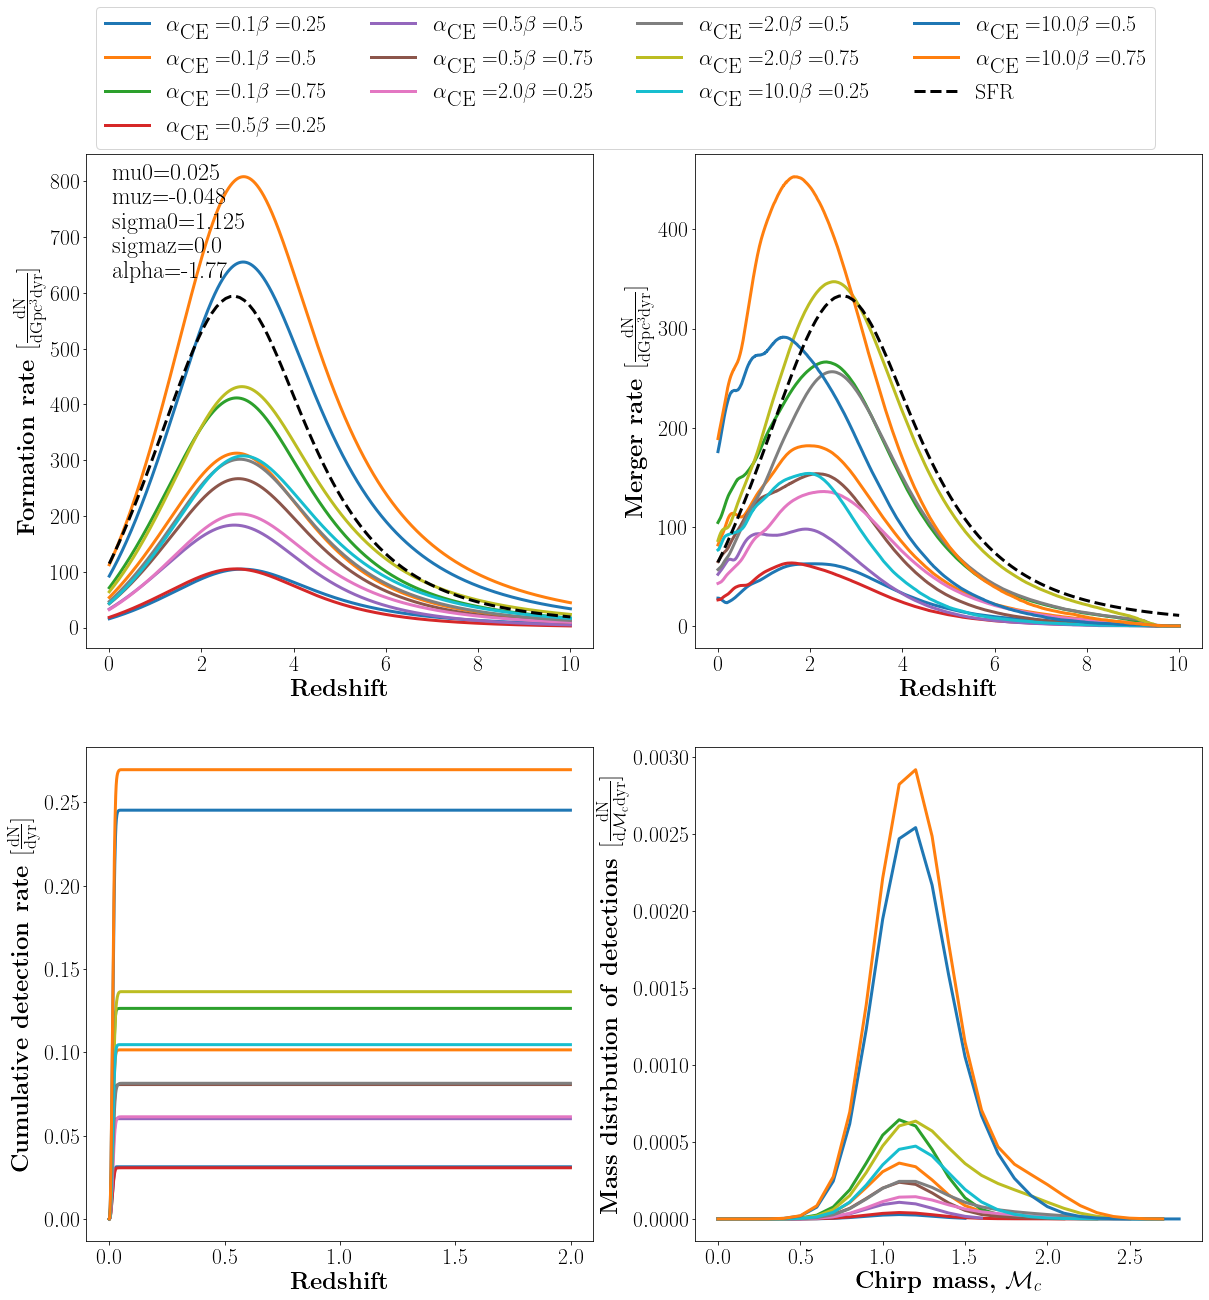

In [9]:
def plot_rates(condensed_paths, alpha_vals, beta_vals, dco_type=None, merger_output_filename=None, weight_column=None,
        merges_hubble_time=True, pessimistic_CEE=True, no_RLOF_after_CEE=True,
        max_redshift=10.0, max_redshift_detection=1.0, redshift_step=0.001, z_first_SF = 10,
        use_sampled_mass_ranges=True, m1_min=5 * u.Msun, m1_max=150 * u.Msun, m2_min=0.1 * u.Msun, fbin=1.0,
        aSF = 0.01, bSF = 2.77, cSF = 2.90, dSF = 4.70,
        mu0=0.035, muz=-0.23, sigma0=0.39,sigmaz=0., alpha=0.0, 
        min_logZ=-12.0, max_logZ=1.0, step_logZ=0.01,
        sensitivity="O1", snr_threshold=8, 
        Mc_max=300.0, Mc_step=0.1, eta_max=0.25, eta_step=0.01,
        snr_max=1000.0, snr_step=0.1, lw=3, fs = 24):
        
        assert dco_type != None, 'dco_type must be given'
        ####### EFFFICIEINT??????????

        total_formation_rates = {}
        total_merger_rates = {}
        total_detection_rates = {}
        cumulative_detection_rates = {}
        detection_rates_by_binary = {}
        chirp_masses = {}

        redshifts = {}

        for alpha_index, alpha_val in enumerate(alpha_vals):
                # Make the dictionary "2D"
                total_formation_rates[alpha_val] = {}
                total_merger_rates[alpha_val] = {}
                total_detection_rates[alpha_val] = {}
                cumulative_detection_rates[alpha_val] = {}
                detection_rates_by_binary[alpha_val] = {}
                chirp_masses[alpha_val] = {}

                redshifts[alpha_val] = {}

                for beta_index, beta_val in enumerate(beta_vals):
                        detection_rates, formation_rates, merger_rates, redshifts[alpha_val][beta_val], COMPASs = \
                        FCI.find_detection_rate(
                        condensed_paths[alpha_val][beta_val], dco_type=dco_type, weight_column=weight_column,
                        merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
                        no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
                        max_redshift_detection=max_redshift_detection,
                        redshift_step=redshift_step, z_first_SF=z_first_SF,
                        m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
                        fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
                        mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
                        min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
                        sensitivity=sensitivity, snr_threshold=snr_threshold,
                        Mc_max=Mc_max, Mc_step=Mc_step,
                        eta_max=eta_max, eta_step=eta_step,
                        snr_max=snr_max, snr_step=snr_step, lognormal=True)

                        chirp_masses[alpha_val][beta_val] = (COMPASs.mass1*COMPASs.mass2)**(3./5.) / (COMPASs.mass1 + COMPASs.mass2)**(1./5.)

                        # sum things up across binaries
                        total_formation_rates[alpha_val][beta_val] = np.sum(formation_rates, axis=0)
                        total_merger_rates[alpha_val][beta_val] = np.sum(merger_rates, axis=0)
                        total_detection_rates[alpha_val][beta_val] = np.sum(detection_rates, axis=0)

                        # and across redshifts
                        cumulative_detection_rates[alpha_val][beta_val] = np.cumsum(total_detection_rates[alpha_val][beta_val])
                        detection_rates_by_binary[alpha_val][beta_val] = np.sum(detection_rates, axis=1)

                        # empty trash
                        del detection_rates
                        del formation_rates
                        del merger_rates
                        del COMPASs

        ###########################
        #Start plotting

        # set some constants for the plots
        # matplotlib.rcParams('text', usetex=True)
        # matplotlib.rcParams('font', family='serif', weight='bold')
        # matplotlib.rcParams('font', weight='bold')

        fig, axes = plt.subplots(2, 2, figsize=(20, 20))

        # Calculate and scare the SFR to plot on the formation and merger rate plots
        sfr_redshifts = np.linspace(0, 10, num=100)
        sfr = FCI.find_sfr(sfr_redshifts, a = aSF, b = bSF, c = cSF, d = dSF)

        for alpha_val in alpha_vals:
                for beta_val in beta_vals:
                        Mc_bins = np.arange(0,max(chirp_masses[alpha_val][beta_val])*1.3, max(chirp_masses[alpha_val][beta_val])*1.2/100)

                        axes[0,0].plot(redshifts[alpha_val][beta_val], total_formation_rates[alpha_val][beta_val], lw=lw)
                        
                        axes[0,1].plot(redshifts[alpha_val][beta_val], total_merger_rates[alpha_val][beta_val], lw=lw, label=r'$\alpha_{\textrm{CE}} = $' + alpha_val + r'$\beta = $' + beta_val)
                        
                        axes[1,0].plot(redshifts[alpha_val][beta_val][:len(cumulative_detection_rates[alpha_val][beta_val])], cumulative_detection_rates[alpha_val][beta_val], lw=lw)

                        # Get the Hist
                        hist, _ = np.histogram(chirp_masses[alpha_val][beta_val], weights = detection_rates_by_binary[alpha_val][beta_val], bins=Mc_bins)
                        
                        # Calculate KDE
                        axis = np.arange(Mc_bins[0],Mc_bins[-1],0.1) # The x-axis for the chirp masses
                        # Get the KDE
                        mass_kde = FFTKDE(bw=0.2).fit(chirp_masses[alpha_val][beta_val], weights=detection_rates_by_binary[alpha_val][beta_val]).evaluate(axis)
                        # Normalize the KDE
                        mass_kde_scaled = mass_kde*sum(hist)*sum(hist)*np.diff(Mc_bins)[0] 
                        axes[1,1].plot(axis, mass_kde_scaled, lw=lw)
        
        # Label axes of all the plots
        axes[0,0].set_xlabel(r'\textbf{Redshift}', fontsize=fs)
        axes[0,0].set_ylabel(r'\textbf{Formation rate $[\rm \frac{\mathrm{d}N}{\mathrm{d}Gpc^3 \mathrm{d}yr}]$}', fontsize=fs)

        axes[0,1].set_xlabel(r'\textbf{Redshift}', fontsize=fs)
        axes[0,1].set_ylabel(r'\textbf{Merger rate $[\rm \frac{\mathrm{d}N}{\mathrm{d}Gpc^3 \mathrm{d}yr}]$}', fontsize=fs)

        axes[1,0].set_xlabel(r'\textbf{Redshift}', fontsize=fs)
        axes[1,0].set_ylabel(r'\textbf{Cumulative detection rate $[\rm \frac{\mathrm{d}N}{\mathrm{d}yr}]$}', fontsize=fs)

        axes[1,1].set_xlabel(r'\textbf{Chirp mass, $\mathcal{M}_c$}', fontsize=fs)
        axes[1,1].set_ylabel(r'\textbf{Mass distrbution of detections $[\rm \frac{\mathrm{d}N}{\mathrm{d}\mathcal{M}_c \mathrm{d}yr}]$}', fontsize=fs)

        # Set upper limit on x axis for chirp mass distribution
        xlims = axes[1,1].get_xlim()
        if xlims[1] >= 40:
                axes[1,1].set_xlim([xlims[0], 40])

        # Add text upper left corner
        axes[0,0].text(0.05,0.75, 
                "mu0={} \nmuz={} \nsigma0={} \nsigmaz={} \nalpha={}".format(mu0,muz,sigma0,sigmaz,alpha), 
                transform=axes[0,0].transAxes, size = fs) 

        for ax in axes.flatten():
                ax.tick_params(labelsize=0.9*fs)

        # Scale SFR differently for each DCO type
        sfr = sfr/max(sfr)
        form_const, merger_const = axes[0,0].get_ylim()[1] * 0.7, axes[0,1].get_ylim()[1] * 0.7

        # Plot SFRs
        axes[0,0].plot(sfr_redshifts, sfr * form_const, color='black', lw=lw, linestyle='dashed')
        axes[0,1].plot(sfr_redshifts, sfr * merger_const, color='black', lw=lw, linestyle='dashed', label=r'SFR')

        # Include legend
        fig.legend(fontsize=22, ncol=4, bbox_to_anchor=(0.875, .99),  markerscale=25) 

        # Show the plot!
        plt.show()

plot_rates(condensed_paths, alpha_vals, beta_vals, dco_type='BNS', weight_column=weight_column,
            merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
            no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
            max_redshift_detection=max_redshift_detection,
            redshift_step=redshift_step, z_first_SF=z_first_SF,
            m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
            fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
            mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
            min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
            sensitivity=sensitivity, snr_threshold=snr_threshold,
            Mc_max=Mc_max, Mc_step=Mc_step,
            eta_max=eta_max, eta_step=eta_step,
            snr_max=snr_max, snr_step=snr_step)

## b) BHNS

Average_SF_mass_needed =  79223283.00006495 solMass
Average_SF_mass_needed =  78987918.65316662 solMass
Average_SF_mass_needed =  79348106.2627692 solMass
Average_SF_mass_needed =  79240010.4524557 solMass
Average_SF_mass_needed =  78918110.2614396 solMass
Average_SF_mass_needed =  78809904.75887628 solMass
Average_SF_mass_needed =  79459272.69613855 solMass
Average_SF_mass_needed =  79177369.67361984 solMass
Average_SF_mass_needed =  79086888.68012922 solMass
Average_SF_mass_needed =  78978933.35280535 solMass
Average_SF_mass_needed =  79462155.41786157 solMass
Average_SF_mass_needed =  79172506.27893674 solMass


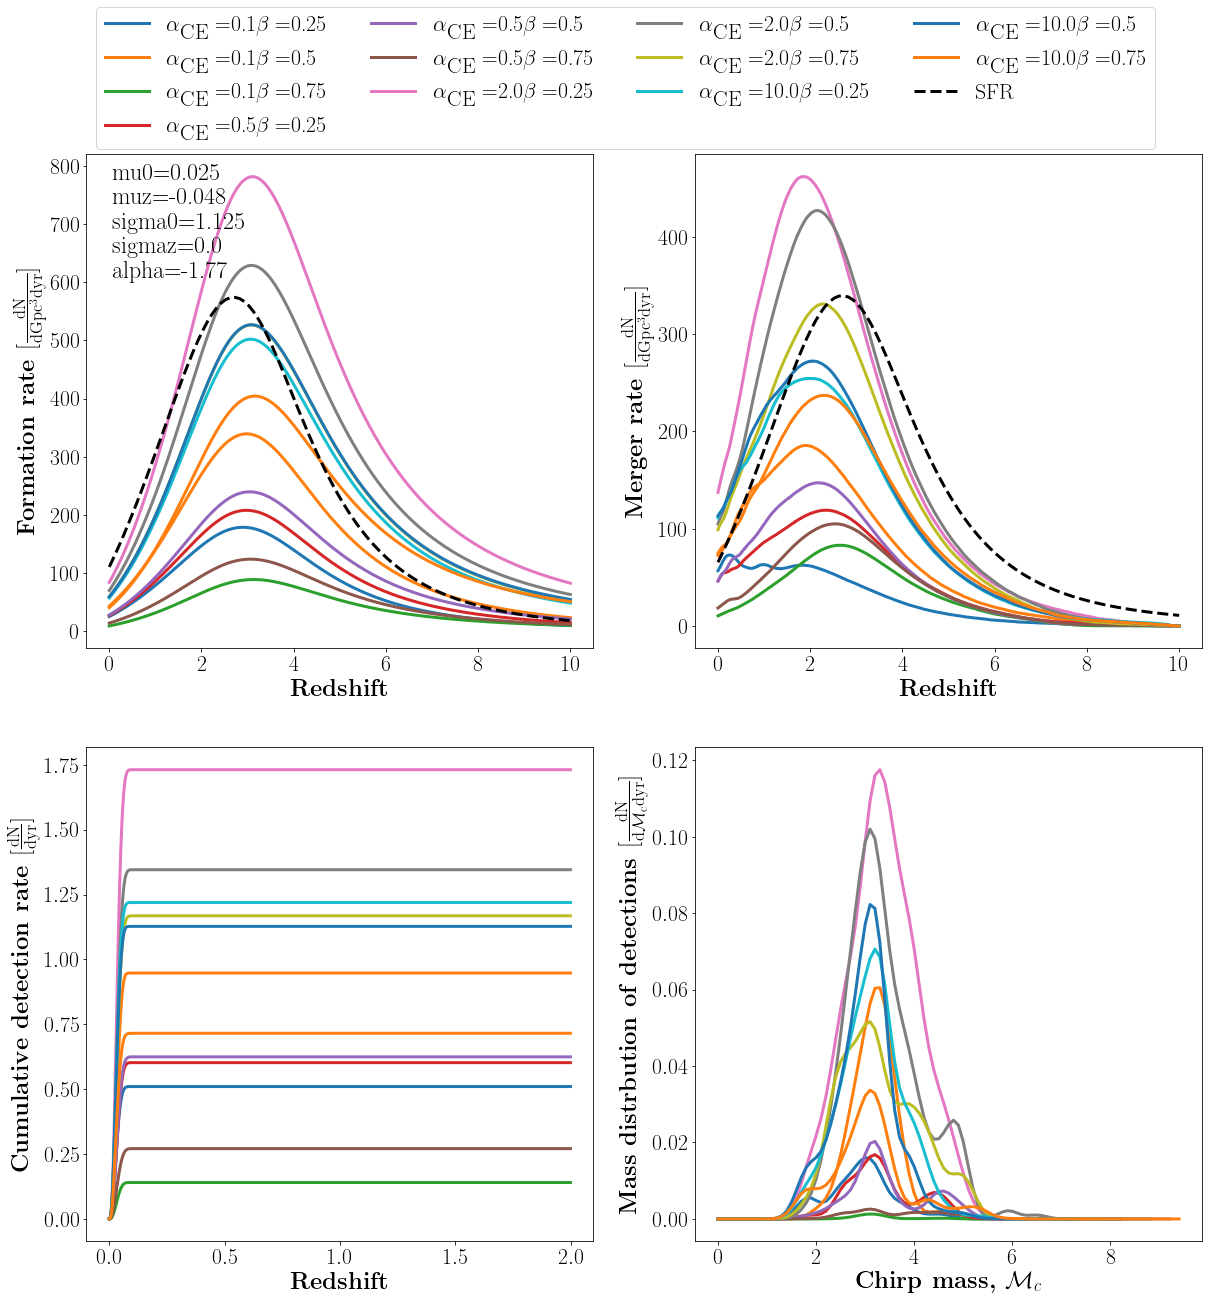

In [10]:
plot_rates(condensed_paths, alpha_vals, beta_vals, dco_type='BHNS', weight_column=weight_column,
            merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
            no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
            max_redshift_detection=max_redshift_detection,
            redshift_step=redshift_step, z_first_SF=z_first_SF,
            m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
            fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
            mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
            min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
            sensitivity=sensitivity, snr_threshold=snr_threshold,
            Mc_max=Mc_max, Mc_step=Mc_step,
            eta_max=eta_max, eta_step=eta_step,
            snr_max=snr_max, snr_step=snr_step)

## c) BBH

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_21950/2909472036.py:37: UserWarning: Maximum chirp mass used for detectability calculation is below maximum binary chirp mass * (1+maximum redshift for detectability calculation)
  FCI.find_detection_rate(


Average_SF_mass_needed =  79115780.20768338 solMass
Average_SF_mass_needed =  79764513.50952521 solMass
Average_SF_mass_needed =  79109829.97642906 solMass
Average_SF_mass_needed =  79393590.60575001 solMass
Average_SF_mass_needed =  79124937.46360081 solMass
Average_SF_mass_needed =  79253090.14338157 solMass
Average_SF_mass_needed =  79184450.78930938 solMass
Average_SF_mass_needed =  79323892.14768337 solMass
Average_SF_mass_needed =  79065144.70310307 solMass
Average_SF_mass_needed =  79092497.71082753 solMass
Average_SF_mass_needed =  78876660.75387461 solMass
Average_SF_mass_needed =  79091273.06189112 solMass


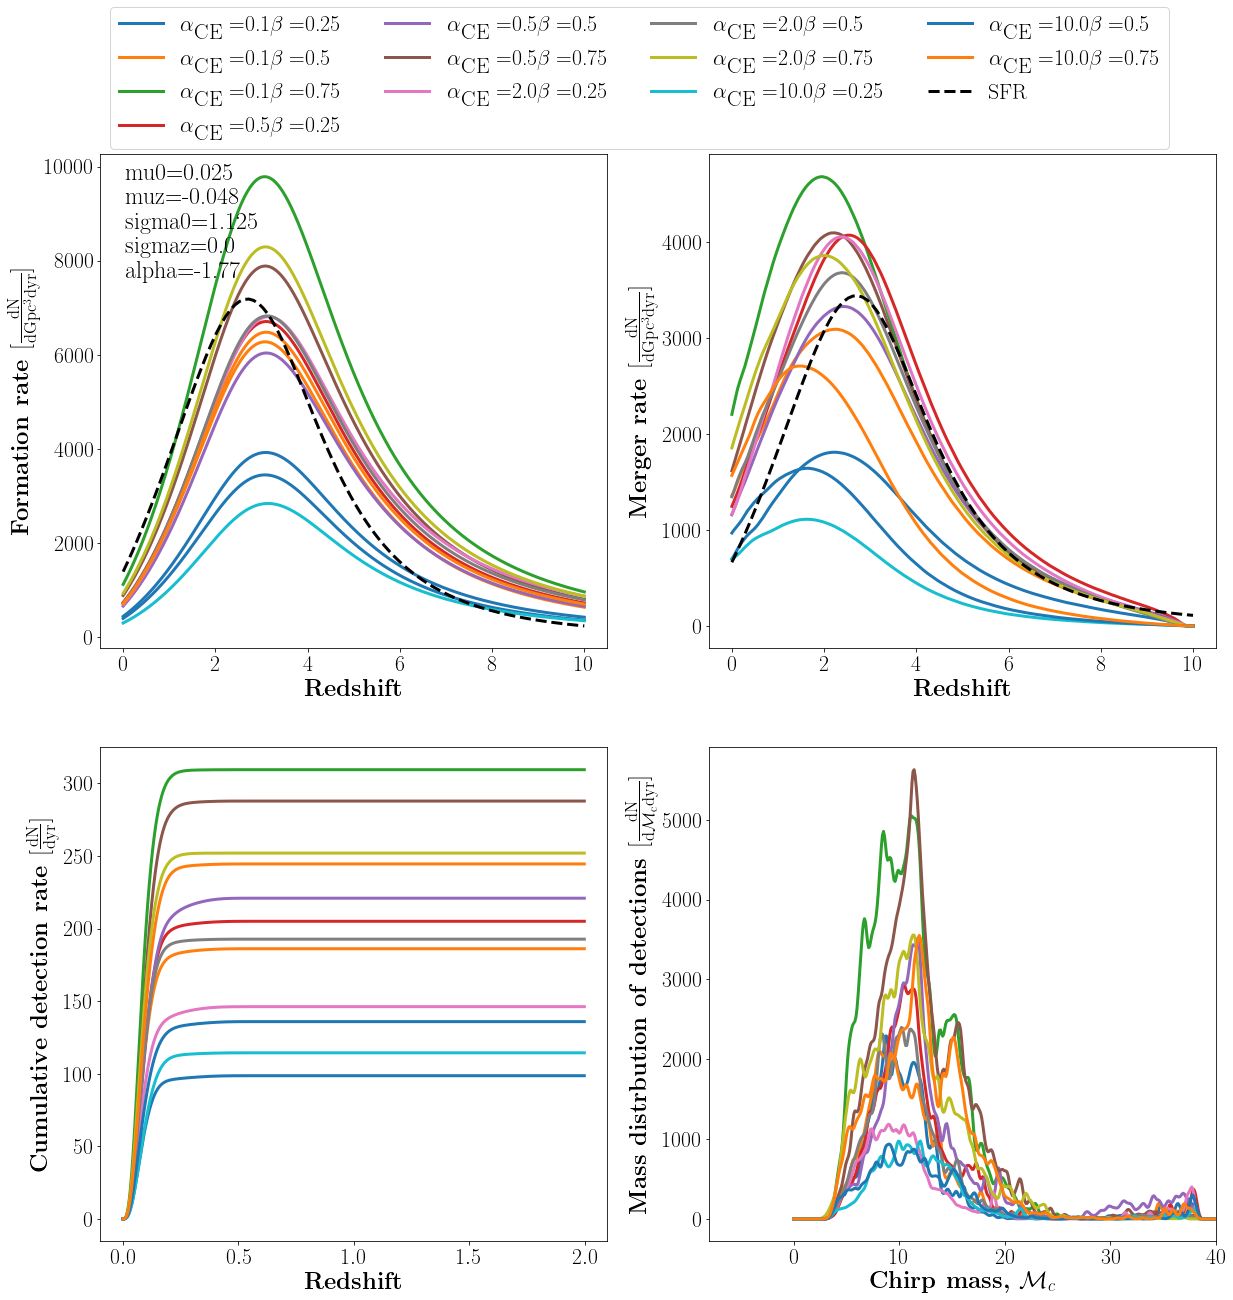

In [11]:
plot_rates(condensed_paths, alpha_vals, beta_vals, dco_type='BBH', weight_column=weight_column,
            merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
            no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
            max_redshift_detection=max_redshift_detection,
            redshift_step=redshift_step, z_first_SF=z_first_SF,
            m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
            fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
            mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
            min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
            sensitivity=sensitivity, snr_threshold=snr_threshold,
            Mc_max=Mc_max, Mc_step=Mc_step,
            eta_max=eta_max, eta_step=eta_step,
            snr_max=snr_max, snr_step=snr_step)

## d) TRY USING DIFFERENT MSSFRS ... WORK IN PROGRESS...

ClassMSSFR: Remember to set self.SFRprescription() + subparts
                            self.Zprescription()   +sub-parts
Average_SF_mass_needed =  79087079.41034462 solMass
ClassMSSFR: Remember to set self.SFRprescription() + subparts
                            self.Zprescription()   +sub-parts
Average_SF_mass_needed =  79098075.99138485 solMass
ClassMSSFR: Remember to set self.SFRprescription() + subparts
                            self.Zprescription()   +sub-parts
Average_SF_mass_needed =  78957172.39051138 solMass
ClassMSSFR: Remember to set self.SFRprescription() + subparts
                            self.Zprescription()   +sub-parts
Average_SF_mass_needed =  79030518.4429992 solMass
ClassMSSFR: Remember to set self.SFRprescription() + subparts
                            self.Zprescription()   +sub-parts
Average_SF_mass_needed =  79035996.39752954 solMass
ClassMSSFR: Remember to set self.SFRprescription() + subparts
                            self.Zprescription()   +sub-par

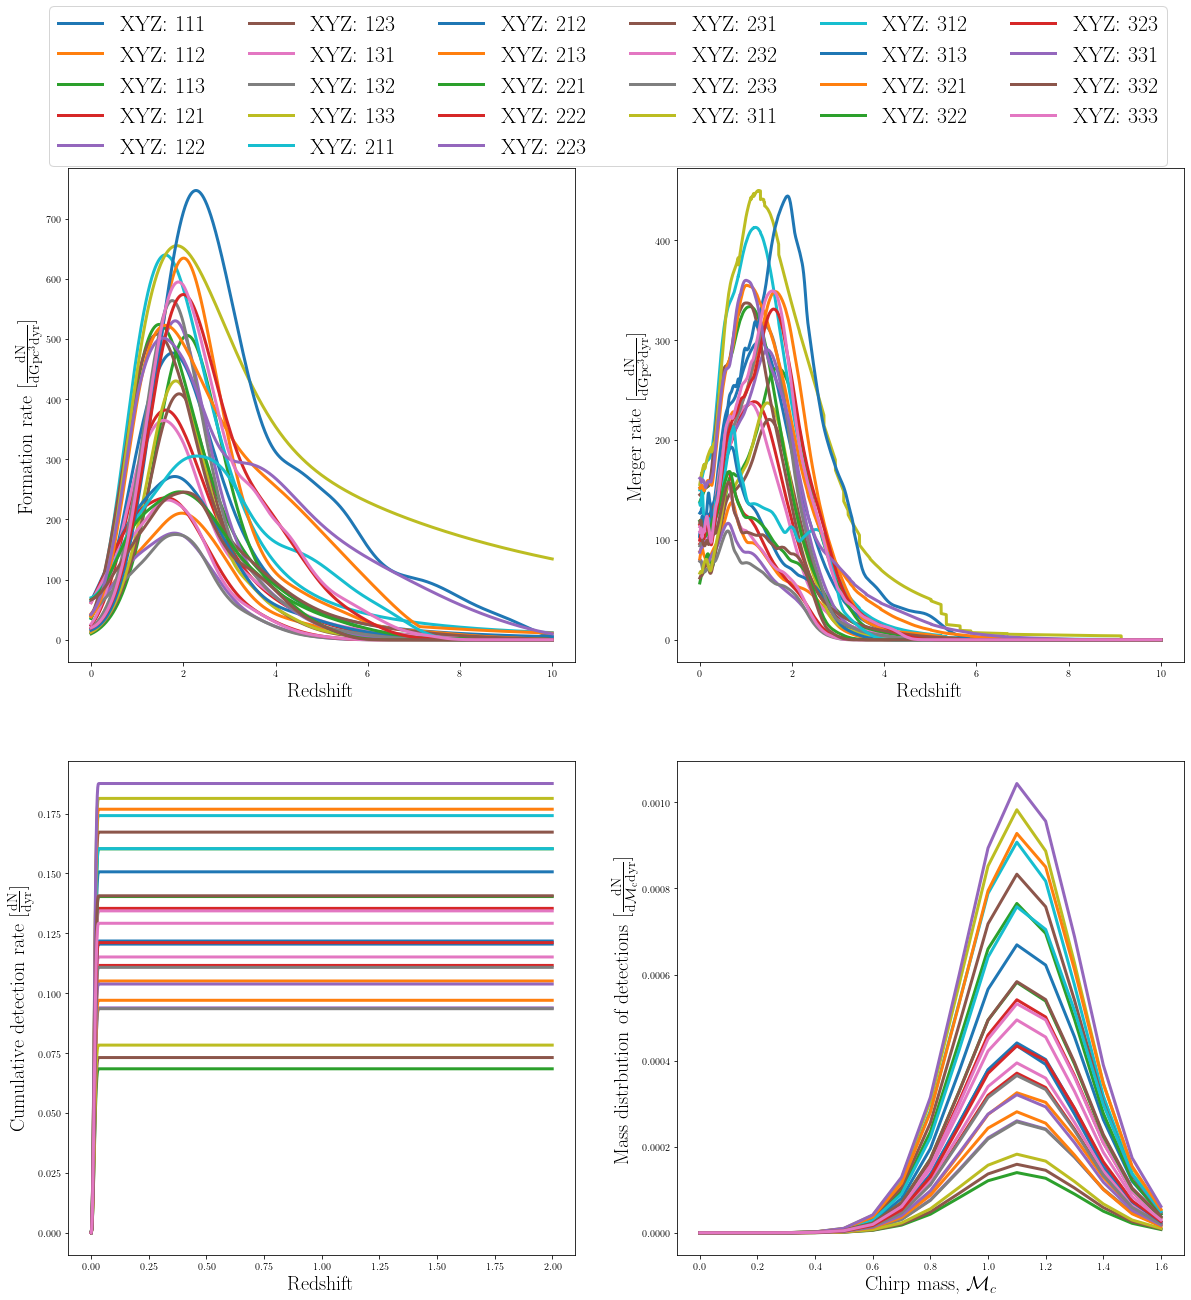

In [10]:
import FastCosmicIntegration2 as FCI2

# First define the parameters

# For what DCO would you like the rate?  options: all, BBH, BHNS BNS
dco_type        = "BNS"
weight_column   = None
                        
merges_hubble_time     = True
pessimistic_CEE        = True
no_RLOF_after_CEE      = True

# Options for the redshift evolution 
max_redshift           = 10.0
max_redshift_detection = 2.0
redshift_step          = 0.001
z_first_SF             = 10

# Metallicity of the Universe
min_logZ               = -12.0 
max_logZ               = 1.0 
step_logZ              = 0.01

#and detector sensitivity
sensitivity            = "O1" 
snr_threshold          = 8 

Mc_max                 = 300.0 
Mc_step                = 0.1 
eta_max                = 0.25 
eta_step               = 0.01
snr_max                = 1000.0 
snr_step               = 0.1

# Parameters to calculate the representing SF mass (make sure these match YOUR simulation!)
m1_min          = 5 * u.Msun 
m1_max          = 150 * u.Msun
m2_min          = m1_min * 0.01 # m2_min = min(q) * min(m1)
fbin            = 1.0

# Parameters determining dP/dZ and SFR(z), default options from Neijssel 2019
aSF             = 0.01 
bSF             = 2.77 
cSF             = 2.90 
dSF             = 4.70

# Parameter prescriptions from N. Lang & C.A. Norman 2006
mu0             = 0.0142
muz             = -0.15
sigma0          = 0.39
sigmaz          = 0. 
alpha           = 0.0

# Fiducial prescriptions
lognormal=False
Zprescription='MZ_GSMF'
SFRprescription='Madau et al. (2017)'
GSMFprescription='Panter et al. (2004) Single'
ZMprescription='Ma et al. (2015)'
logNormalPrescription=None

# SFRD, GSMF, and MZR prescriptions (this is in the format of the table that the paper will have)
SFRDs   = {1: 'Madau et al. (2017)',            2: 'Madau et al. (2014)',               3: 'Strolger et al. (2004)'}
GSMFs   = {1: 'Panter et al. (2004) Single',    2: 'Furlong et al. (2015) Single',      3: 'Furlong et al. (2015) Double'}
MZRs    = {1: 'Ma et al. (2016)',               2: 'Langer et al. (2006)',              3: 'Langer et al. +offset (2006)'}


def plot_rates_mssfr(condensed_paths, alpha_val, beta_val, SFRDs, GSMFs, MZRs, dco_type=None, merger_output_filename=None, weight_column=None,
        merges_hubble_time=True, pessimistic_CEE=True, no_RLOF_after_CEE=True,
        max_redshift=10.0, max_redshift_detection=1.0, redshift_step=0.001, z_first_SF = 10,
        use_sampled_mass_ranges=True, m1_min=5 * u.Msun, m1_max=150 * u.Msun, m2_min=0.1 * u.Msun, fbin=1.0,
        aSF = 0.01, bSF = 2.77, cSF = 2.90, dSF = 4.70,
        mu0=0.035, muz=-0.23, sigma0=0.39,sigmaz=0., alpha=0.0, 
        min_logZ=-12.0, max_logZ=1.0, step_logZ=0.01,
        sensitivity="O1", snr_threshold=8, 
        Mc_max=300.0, Mc_step=0.1, eta_max=0.25, eta_step=0.01,
        snr_max=1000.0, snr_step=0.1, lw=3):
        
        assert dco_type != None, 'dco_type must be given'

        total_formation_rates = {}
        total_merger_rates = {}
        total_detection_rates = {}
        cumulative_detection_rates = {}
        detection_rates_by_binary = {}
        chirp_masses = {}
        redshifts = {}
        
        for SFRD_num, SFRD_name in SFRDs.items():
                for GSMF_num, GSMF_name in GSMFs.items():
                        for MZR_num, MZR_name in MZRs.items():
                                
                                # The prescription, labeled by a list representing (X, Y, Z)
                                S_prescription = (SFRD_num, GSMF_num, MZR_num)

                                # Calculate!
                                detection_rates, formation_rates, merger_rates, redshifts[S_prescription], COMPASs = \
                                FCI2.find_detection_rate(
                                condensed_paths[alpha_val][beta_val], dco_type=dco_type, weight_column=weight_column,
                                lognormal=False, Zprescription='MZ_GSMF', SFRprescription=SFRD_name, GSMFprescription=GSMF_name, 
                                ZMprescription=MZR_name, logNormalPrescription=None,
                                merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
                                no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
                                max_redshift_detection=max_redshift_detection,
                                redshift_step=redshift_step, z_first_SF=z_first_SF,
                                m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
                                fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
                                mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
                                min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
                                sensitivity=sensitivity, snr_threshold=snr_threshold,
                                Mc_max=Mc_max, Mc_step=Mc_step,
                                eta_max=eta_max, eta_step=eta_step,
                                snr_max=snr_max, snr_step=snr_step)

                                # Get the chirp masses
                                chirp_masses[S_prescription] = (COMPASs.mass1*COMPASs.mass2)**(3./5.) / (COMPASs.mass1 + COMPASs.mass2)**(1./5.)

                                # sum things up across binaries
                                total_formation_rates[S_prescription] = np.sum(formation_rates, axis=0)
                                total_merger_rates[S_prescription] = np.sum(merger_rates, axis=0)
                                total_detection_rates[S_prescription] = np.sum(detection_rates, axis=0)

                                # and across redshifts
                                cumulative_detection_rates[S_prescription] = np.cumsum(total_detection_rates[S_prescription])
                                detection_rates_by_binary[S_prescription] = np.sum(detection_rates, axis=1)

                                # empty trash
                                del detection_rates
                                del formation_rates
                                del merger_rates
                                del COMPASs

        

        ###########################
        #Start plotting

        # set some constants for the plots
        plt.rc('font', family='serif')
        fs = 20
        fig, axes = plt.subplots(2, 2, figsize=(20, 20))

        for SFRD_num, SFRD_name in SFRDs.items():
                for GSMF_num, GSMF_name in GSMFs.items():
                        for MZR_num, MZR_name in MZRs.items():

                                # The prescription for the current iteration
                                S_prescription = (SFRD_num, GSMF_num, MZR_num)
                        
                                axes[0,0].plot(redshifts[S_prescription], total_formation_rates[S_prescription], lw=lw)
                                
                                axes[0,1].plot(redshifts[S_prescription], total_merger_rates[S_prescription], lw=lw, label='XYZ: ' + str(SFRD_num) + str(GSMF_num) + str(MZR_num))
                                
                                axes[1,0].plot(redshifts[S_prescription][:len(cumulative_detection_rates[S_prescription])], cumulative_detection_rates[S_prescription], lw=lw)
                                
                                # Get the Hist
                                bins = np.arange(0,max(chirp_masses[S_prescription])*1.3, max(chirp_masses[S_prescription])*1.2/100)      
                                hist, _ = np.histogram(chirp_masses[S_prescription], weights = detection_rates_by_binary[S_prescription], bins=bins)
                                
                                # Calculate KDE
                                axis = np.arange(bins[0],bins[-1],0.1) # The x-axis for the chirp masses
                                # Get the KDE
                                mass_kde = FFTKDE(bw=0.2).fit(chirp_masses[S_prescription], weights=detection_rates_by_binary[S_prescription]).evaluate(axis)
                                # Normalize the KDE
                                mass_kde_scaled = mass_kde*sum(hist)*sum(hist)*np.diff(bins)[0] 
                                axes[1,1].plot(axis, mass_kde_scaled, lw=lw)  


        # Label axes of all the plots
        axes[0,0].set_xlabel('Redshift', fontsize=fs)
        axes[0,0].set_ylabel(r'Formation rate $[\rm \frac{\mathrm{d}N}{\mathrm{d}Gpc^3 \mathrm{d}yr}]$', fontsize=fs)

        axes[0,1].set_xlabel('Redshift', fontsize=fs)
        axes[0,1].set_ylabel(r'Merger rate $[\rm \frac{\mathrm{d}N}{\mathrm{d}Gpc^3 \mathrm{d}yr}]$', fontsize=fs)

        axes[1,0].set_xlabel('Redshift', fontsize=fs)
        axes[1,0].set_ylabel(r'Cumulative detection rate $[\rm \frac{\mathrm{d}N}{\mathrm{d}yr}]$', fontsize=fs)

        axes[1,1].set_xlabel(r'Chirp mass, $\mathcal{M}_c$', fontsize=fs)
        axes[1,1].set_ylabel(r'Mass distrbution of detections $[\rm \frac{\mathrm{d}N}{\mathrm{d}\mathcal{M}_c \mathrm{d}yr}]$', fontsize=fs)

        # Set upper limit on x axis for chirp mass distribution
        xlims = axes[1,1].get_xlim()
        if xlims[1] >= 40:
                axes[1,1].set_xlim([xlims[0], 40])

        # Include legend
        fig.legend(fontsize=22, ncol=6, bbox_to_anchor=(0.5, 1.0), loc='upper center',  markerscale=25) 

        # Show the plot!
        plt.show()

plot_rates_mssfr(condensed_paths, '0.5', '0.5', SFRDs, GSMFs, MZRs, dco_type='BNS', weight_column=weight_column,
            merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
            no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
            max_redshift_detection=max_redshift_detection,
            redshift_step=redshift_step, z_first_SF=z_first_SF,
            m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
            fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
            mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
            min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
            sensitivity=sensitivity, snr_threshold=snr_threshold,
            Mc_max=Mc_max, Mc_step=Mc_step,
            eta_max=eta_max, eta_step=eta_step,
            snr_max=snr_max, snr_step=snr_step)

ClassMSSFR: Remember to set self.SFRprescription() + subparts
                            self.Zprescription()   +sub-parts
Average_SF_mass_needed =  79229190.54609472 solMass
ClassMSSFR: Remember to set self.SFRprescription() + subparts
                            self.Zprescription()   +sub-parts
Average_SF_mass_needed =  78848188.51203357 solMass
ClassMSSFR: Remember to set self.SFRprescription() + subparts
                            self.Zprescription()   +sub-parts
Average_SF_mass_needed =  79048676.63245589 solMass
ClassMSSFR: Remember to set self.SFRprescription() + subparts
                            self.Zprescription()   +sub-parts
Average_SF_mass_needed =  79096301.26974614 solMass
ClassMSSFR: Remember to set self.SFRprescription() + subparts
                            self.Zprescription()   +sub-parts
Average_SF_mass_needed =  79088729.25673445 solMass
ClassMSSFR: Remember to set self.SFRprescription() + subparts
                            self.Zprescription()   +sub-pa

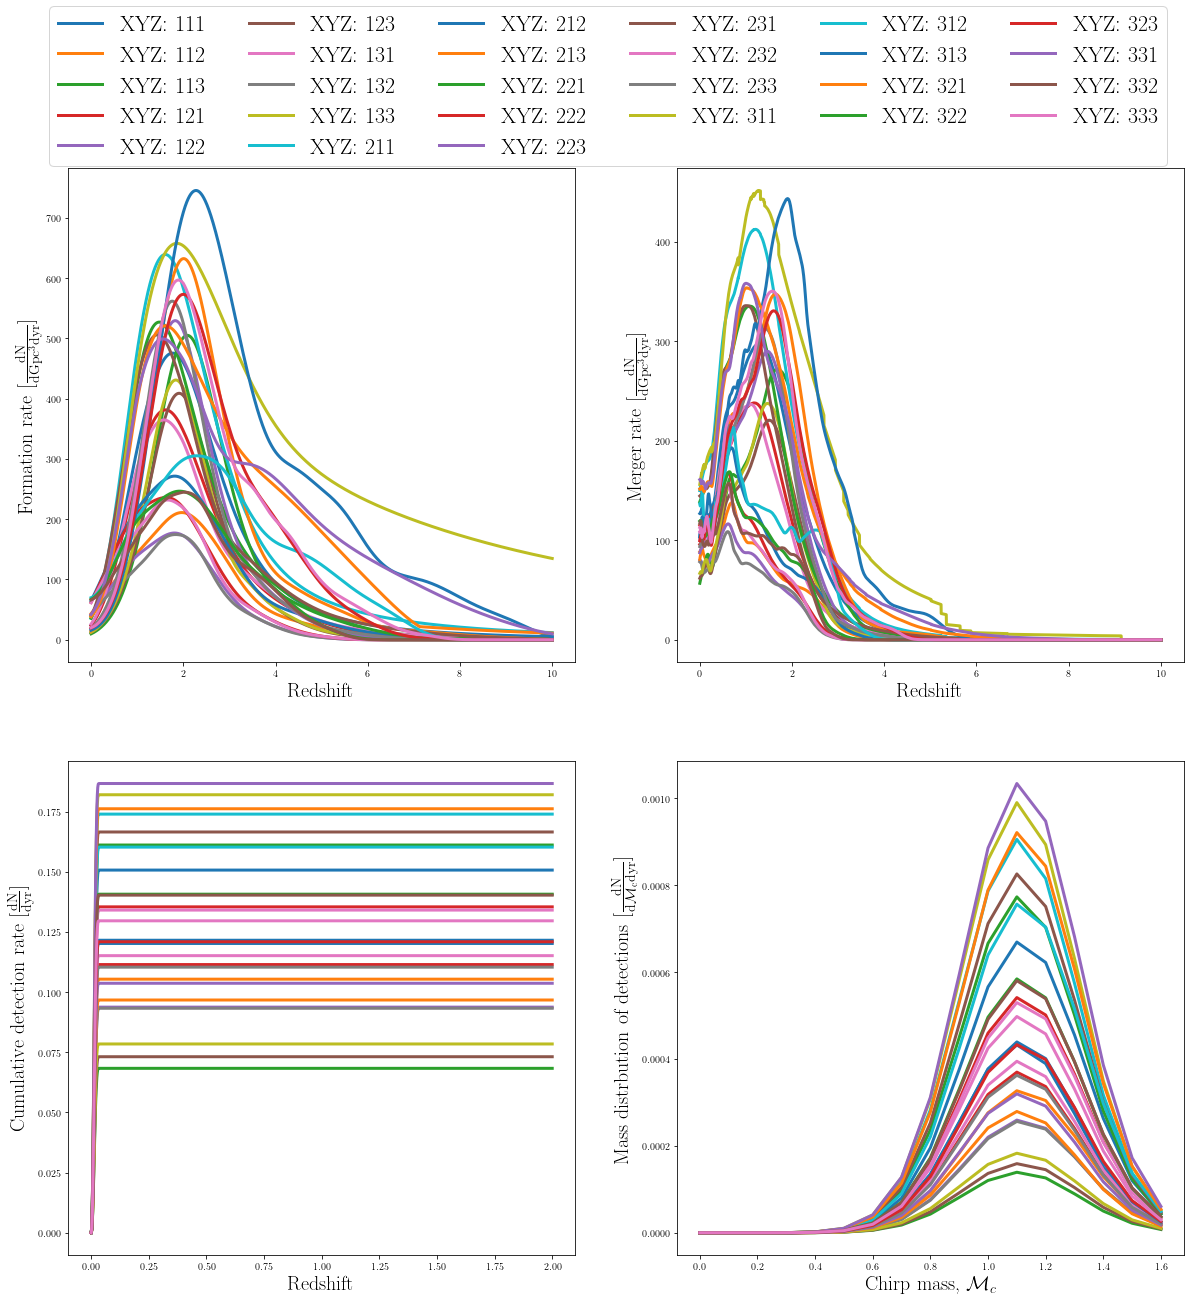

In [5]:

# First define the parameters

# For what DCO would you like the rate?  options: all, BBH, BHNS BNS
dco_type        = "BNS"
weight_column   = None
                        
merges_hubble_time     = True
pessimistic_CEE        = True
no_RLOF_after_CEE      = True

# Options for the redshift evolution 
max_redshift           = 10.0
max_redshift_detection = 2.0
redshift_step          = 0.001
z_first_SF             = 10

# Metallicity of the Universe
min_logZ               = -12.0 
max_logZ               = 1.0 
step_logZ              = 0.01

#and detector sensitivity
sensitivity            = "O1" 
snr_threshold          = 8 

Mc_max                 = 300.0 
Mc_step                = 0.1 
eta_max                = 0.25 
eta_step               = 0.01
snr_max                = 1000.0 
snr_step               = 0.1

# Parameters to calculate the representing SF mass (make sure these match YOUR simulation!)
m1_min          = 5 * u.Msun 
m1_max          = 150 * u.Msun
m2_min          = m1_min * 0.01 # m2_min = min(q) * min(m1)
fbin            = 1.0

# Parameters determining dP/dZ and SFR(z), default options from Neijssel 2019
aSF             = 0.01 
bSF             = 2.77 
cSF             = 2.90 
dSF             = 4.70

# Parameter prescriptions from N. Lang & C.A. Norman 2006
mu0             = 0.0142
muz             = -0.15
sigma0          = 0.39
sigmaz          = 0. 
alpha           = 0.0

# Fiducial prescriptions
lognormal=False
Zprescription='MZ_GSMF'
SFRprescription='Madau et al. (2017)'
GSMFprescription='Panter et al. (2004) Single'
ZMprescription='Ma et al. (2015)'
logNormalPrescription=None,

# SFRD, GSMF, and MZR prescriptions (this is in the format of the table that the paper will have)
SFRDs   = {1: 'Madau et al. (2017)',            2: 'Madau et al. (2014)',               3: 'Strolger et al. (2004)'}
GSMFs   = {1: 'Panter et al. (2004) Single',    2: 'Furlong et al. (2015) Single',      3: 'Furlong et al. (2015) Double'}
MZRs    = {1: 'Ma et al. (2016)',               2: 'Langer et al. (2006)',              3: 'Langer et al. +offset (2006)'}


def plot_rates_mssfr(condensed_paths, alpha_val, beta_val, SFRDs, GSMFs, MZRs, dco_type=None, merger_output_filename=None, weight_column=None,
        merges_hubble_time=True, pessimistic_CEE=True, no_RLOF_after_CEE=True,
        max_redshift=10.0, max_redshift_detection=1.0, redshift_step=0.001, z_first_SF = 10,
        use_sampled_mass_ranges=True, m1_min=5 * u.Msun, m1_max=150 * u.Msun, m2_min=0.1 * u.Msun, fbin=1.0,
        aSF = 0.01, bSF = 2.77, cSF = 2.90, dSF = 4.70,
        mu0=0.035, muz=-0.23, sigma0=0.39,sigmaz=0., alpha=0.0, 
        min_logZ=-12.0, max_logZ=1.0, step_logZ=0.01,
        sensitivity="O1", snr_threshold=8, 
        Mc_max=300.0, Mc_step=0.1, eta_max=0.25, eta_step=0.01,
        snr_max=1000.0, snr_step=0.1):
        
        assert dco_type != None, 'dco_type must be given'

        total_formation_rates = {}
        total_merger_rates = {}
        total_detection_rates = {}
        cumulative_detection_rates = {}
        detection_rates_by_binary = {}
        chirp_masses = {}
        redshifts = {}
        
        for SFRD_num, SFRD_name in SFRDs.items():
                for GSMF_num, GSMF_name in GSMFs.items():
                        for MZR_num, MZR_name in MZRs.items():
                                
                                # The prescription, labeled by a list representing (X, Y, Z)
                                S_prescription = (SFRD_num, GSMF_num, MZR_num)

                                # Calculate!
                                detection_rates, formation_rates, merger_rates, redshifts[S_prescription], COMPASs = \
                                FCI.find_detection_rate(
                                condensed_paths[alpha_val][beta_val], dco_type=dco_type, weight_column=weight_column,
                                lognormal=False, Zprescription='MZ_GSMF', SFRprescription=SFRD_name, GSMFprescription=GSMF_name, 
                                ZMprescription=MZR_name, logNormalPrescription=None,
                                merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
                                no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
                                max_redshift_detection=max_redshift_detection,
                                redshift_step=redshift_step, z_first_SF=z_first_SF,
                                m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
                                fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
                                mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
                                min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
                                sensitivity=sensitivity, snr_threshold=snr_threshold,
                                Mc_max=Mc_max, Mc_step=Mc_step,
                                eta_max=eta_max, eta_step=eta_step,
                                snr_max=snr_max, snr_step=snr_step)

                                # Get the chirp masses
                                chirp_masses[S_prescription] = (COMPASs.mass1*COMPASs.mass2)**(3./5.) / (COMPASs.mass1 + COMPASs.mass2)**(1./5.)

                                # sum things up across binaries
                                total_formation_rates[S_prescription] = np.sum(formation_rates, axis=0)
                                total_merger_rates[S_prescription] = np.sum(merger_rates, axis=0)
                                total_detection_rates[S_prescription] = np.sum(detection_rates, axis=0)

                                # and across redshifts
                                cumulative_detection_rates[S_prescription] = np.cumsum(total_detection_rates[S_prescription])
                                detection_rates_by_binary[S_prescription] = np.sum(detection_rates, axis=1)

                                # empty trash
                                del detection_rates
                                del formation_rates
                                del merger_rates
                                del COMPASs

        

        ###########################
        #Start plotting

        # set some constants for the plots
        plt.rc('font', family='serif')
        fs = 20
        lw = 3
        fig, axes = plt.subplots(2, 2, figsize=(20, 20))

        for SFRD_num, SFRD_name in SFRDs.items():
                for GSMF_num, GSMF_name in GSMFs.items():
                        for MZR_num, MZR_name in MZRs.items():

                                # The prescription for the current iteration
                                S_prescription = (SFRD_num, GSMF_num, MZR_num)
                        
                                axes[0,0].plot(redshifts[S_prescription], total_formation_rates[S_prescription], lw=lw)
                                
                                axes[0,1].plot(redshifts[S_prescription], total_merger_rates[S_prescription], lw=lw, label='XYZ: ' + str(SFRD_num) + str(GSMF_num) + str(MZR_num))
                                
                                axes[1,0].plot(redshifts[S_prescription][:len(cumulative_detection_rates[S_prescription])], cumulative_detection_rates[S_prescription], lw=lw)
                                
                                # Get the Hist
                                bins = np.arange(0,max(chirp_masses[S_prescription])*1.3, max(chirp_masses[S_prescription])*1.2/100)      
                                hist, _ = np.histogram(chirp_masses[S_prescription], weights = detection_rates_by_binary[S_prescription], bins=bins)
                                
                                # Calculate KDE
                                axis = np.arange(bins[0],bins[-1],0.1) # The x-axis for the chirp masses
                                # Get the KDE
                                mass_kde = FFTKDE(bw=0.2).fit(chirp_masses[S_prescription], weights=detection_rates_by_binary[S_prescription]).evaluate(axis)
                                # Normalize the KDE
                                mass_kde_scaled = mass_kde*sum(hist)*sum(hist)*np.diff(bins)[0] 
                                axes[1,1].plot(axis, mass_kde_scaled, lw=lw)  


        # Label axes of all the plots
        axes[0,0].set_xlabel('Redshift', fontsize=fs)
        axes[0,0].set_ylabel(r'Formation rate $[\rm \frac{\mathrm{d}N}{\mathrm{d}Gpc^3 \mathrm{d}yr}]$', fontsize=fs)

        axes[0,1].set_xlabel('Redshift', fontsize=fs)
        axes[0,1].set_ylabel(r'Merger rate $[\rm \frac{\mathrm{d}N}{\mathrm{d}Gpc^3 \mathrm{d}yr}]$', fontsize=fs)

        axes[1,0].set_xlabel('Redshift', fontsize=fs)
        axes[1,0].set_ylabel(r'Cumulative detection rate $[\rm \frac{\mathrm{d}N}{\mathrm{d}yr}]$', fontsize=fs)

        axes[1,1].set_xlabel(r'Chirp mass, $\mathcal{M}_c$', fontsize=fs)
        axes[1,1].set_ylabel(r'Mass distrbution of detections $[\rm \frac{\mathrm{d}N}{\mathrm{d}\mathcal{M}_c \mathrm{d}yr}]$', fontsize=fs)

        # Set upper limit on x axis for chirp mass distribution
        xlims = axes[1,1].get_xlim()
        if xlims[1] >= 40:
                axes[1,1].set_xlim([xlims[0], 40])

        # Include legend
        fig.legend(fontsize=22, ncol=6, bbox_to_anchor=(0.5, 1.0), loc='upper center',  markerscale=25) 

        # Show the plot!
        plt.show()

plot_rates_mssfr(condensed_paths, '0.5', '0.5', SFRDs, GSMFs, MZRs, dco_type='BNS', weight_column=weight_column,
            merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
            no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
            max_redshift_detection=max_redshift_detection,
            redshift_step=redshift_step, z_first_SF=z_first_SF,
            m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
            fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
            mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
            min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
            sensitivity=sensitivity, snr_threshold=snr_threshold,
            Mc_max=Mc_max, Mc_step=Mc_step,
            eta_max=eta_max, eta_step=eta_step,
            snr_max=snr_max, snr_step=snr_step)

ClassMSSFR: Remember to set self.SFRprescription() + subparts
                            self.Zprescription()   +sub-parts
Average_SF_mass_needed =  79112153.41484682 solMass
ClassMSSFR: Remember to set self.SFRprescription() + subparts
                            self.Zprescription()   +sub-parts
Average_SF_mass_needed =  79232444.41685279 solMass
ClassMSSFR: Remember to set self.SFRprescription() + subparts
                            self.Zprescription()   +sub-parts
Average_SF_mass_needed =  79166158.15867952 solMass
ClassMSSFR: Remember to set self.SFRprescription() + subparts
                            self.Zprescription()   +sub-parts
Average_SF_mass_needed =  79288596.74539363 solMass
ClassMSSFR: Remember to set self.SFRprescription() + subparts
                            self.Zprescription()   +sub-parts
Average_SF_mass_needed =  78964929.60173278 solMass
ClassMSSFR: Remember to set self.SFRprescription() + subparts
                            self.Zprescription()   +sub-pa

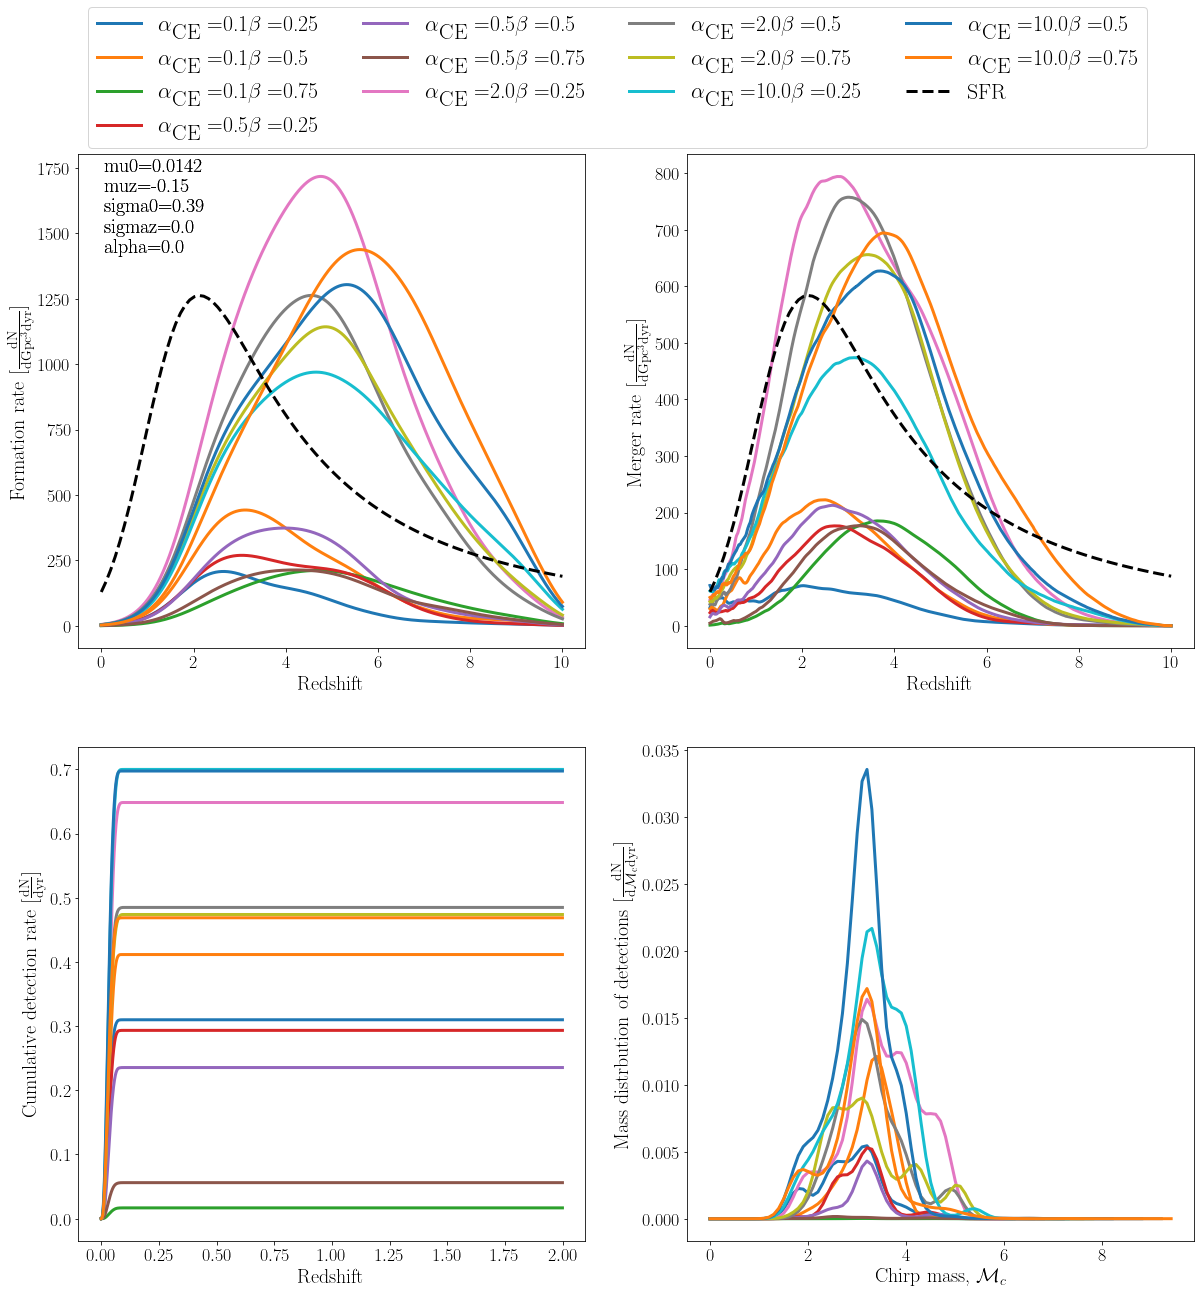

In [7]:
plot_rates2(condensed_paths, alpha_vals, beta_vals, dco_type='BHNS', weight_column=weight_column,
            merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
            no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
            max_redshift_detection=max_redshift_detection,
            redshift_step=redshift_step, z_first_SF=z_first_SF,
            m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
            fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
            mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
            min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
            sensitivity=sensitivity, snr_threshold=snr_threshold,
            Mc_max=Mc_max, Mc_step=Mc_step,
            eta_max=eta_max, eta_step=eta_step,
            snr_max=snr_max, snr_step=snr_step)

# 5. Metallicity-Delay Time Scatter Plots

## a) BNS

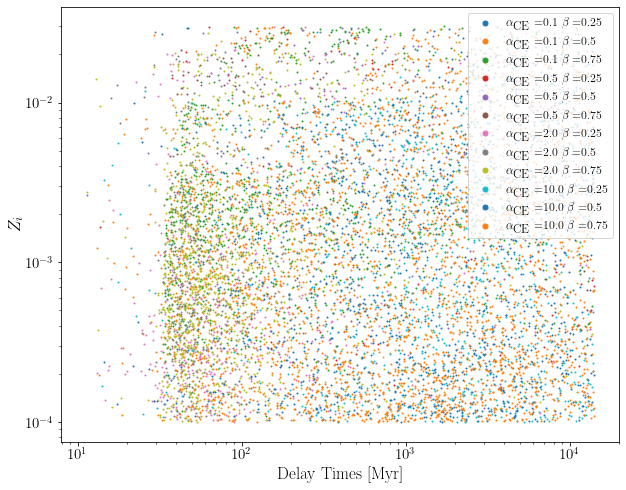

In [85]:
def plot_metallicityVSdelay_times(data, alpha_vals, beta_vals, dco_type):
    """
    This function plots the initial metallicities and time delays for BHNS mergers in given data. It will iterate over given
    alpha_CE and beta values and plot the initia metallicity and time delay for each run's results.

    ...

    Parameters
    ----------
    data : dict
        a two-dimensional dictionary containing the corresponding compas objects for each of the alpha/beta values

    alpha_vals : list
        a one dimensional list containing the alpha_CE values corresponding to the keys of the data dictionary
    
    beta_vals: list 
        a one dimensional list containing the beta values corresponding to the keys of the data dictionary's first dimension
    
    dco_type: str
        one of 'all', 'BBH', 'BHNS', or 'BNS'; the DCO type that we wish to look at.

    """

    # Declare figure
    plt.figure(figsize=(10, 8))

    # Declare axis scales
    plt.yscale("log")  
    plt.xscale("log")

    # Iterate across alpha_CE-beta grid and plot the delay times versus metallicities
    for alpha_val in alpha_vals:
            for beta_val in beta_vals:

                model_data = data[alpha_val][beta_val] # the data
                model_data.setCOMPASDCOmask(dco_type)

                # Get the important BSE values
                time, coalescence_time, dco_seeds = \
                            model_data.get_COMPAS_variables("BSE_Double_Compact_Objects", ["Time", "Coalescence_Time", "SEED"])
                
                # Get the initial metallicities
                Zi, seeds = \
                            model_data.get_COMPAS_variables("BSE_System_Parameters", ["Metallicity@ZAMS(1)", "SEED"])
                
                # Mask for being a DCO
                dco_mask = np.isin(seeds, dco_seeds)

                # Get the DCO initial metallicities
                Zi = Zi[dco_mask]

                # Calculate the time delay for all DCOs
                t_delay = time + coalescence_time

                # Get the time delays and initial metallicities for the given DCO type
                t_delay = t_delay[model_data.DCOmask]
                Zi = Zi[model_data.DCOmask]

                # Plot the time delay and initial metallicities
                plt.scatter(t_delay, Zi, s=1, label=r'$\alpha_{\textrm{CE}} = $' + alpha_val + r' $\beta = $' + beta_val)

    # Label the axes
    plt.xlabel('Delay Times [Myr]', fontsize=17)
    plt.ylabel(r'$Z_i$', fontsize=17)

    # Adjust tick size
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

    # Insert a legend
    plt.legend(loc='upper right',  prop={'size': 12}, markerscale=5)

    # Show the figure!
    plt.show()


plot_metallicityVSdelay_times(data, alpha_vals, beta_vals, 'BNS')

## b) BHNS

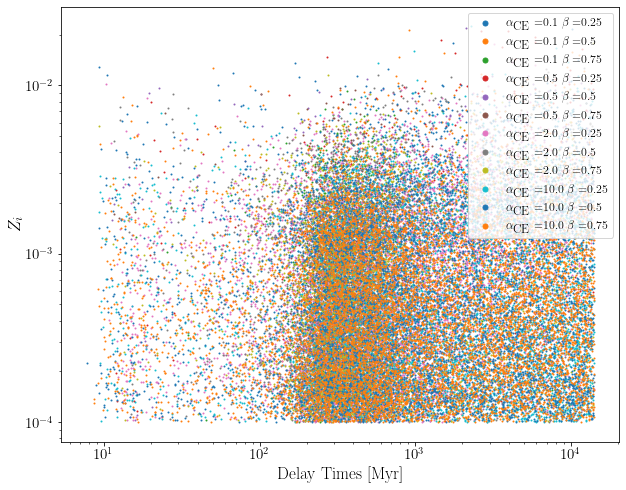

In [86]:
plot_metallicityVSdelay_times(data, alpha_vals, beta_vals, 'BHNS')

## c) BBH

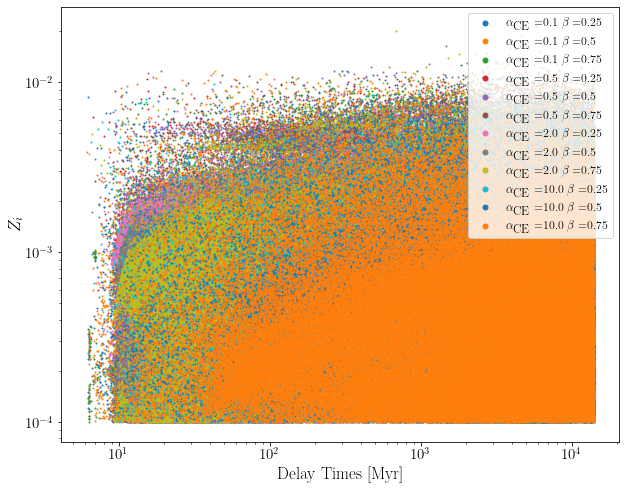

In [87]:
plot_metallicityVSdelay_times(data, alpha_vals, beta_vals, 'BBH')

# 6. Formation Channel Plots

## a) $M_{BH}$ vs $M_{NS}$ for each formation channel

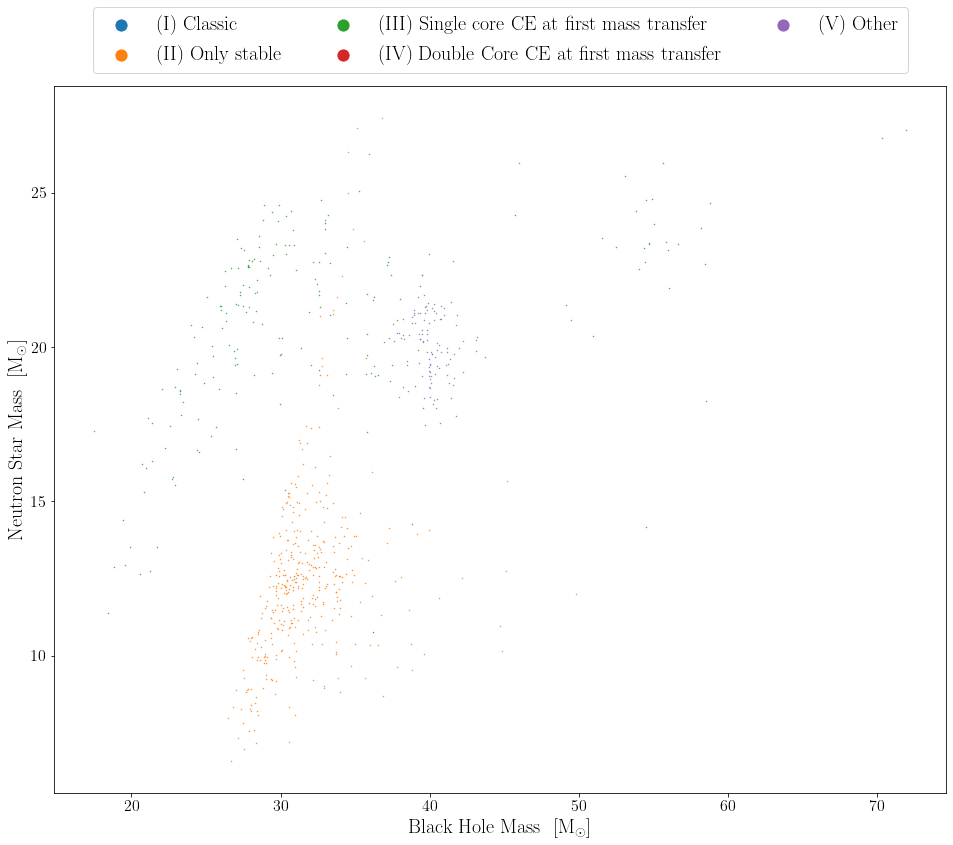

In [88]:
def plot_masses_BHNS_ZAMS(data):
    """
    This function plots the masses of black holes and neutron stars for BHNS mergers in given data for each formation channel.

    ...

    Parameters
    ----------
    data : dict
        a two-dimensional dictionary containing the corresponding compas objects for each of the alpha/beta values

    """
    
    # Declare figure
    fig = plt.figure(figsize=(16, 13))

    # Set the data that we will plot
    fiducial_data = data['0.5']['0.5']
    fiducial_data.setCOMPASDCOmask(types='BHNS', withinHubbleTime=True)
    fiducial_data.setCOMPASData()

    # Get the seeds
    dco_seeds = fiducial_data.seedsDCO

    # Get the important initial values
    mass_1_ZAMS, mass_2_ZAMS, seeds = fiducial_data.get_COMPAS_variables("BSE_System_Parameters", ["Mass@ZAMS(1)", "Mass@ZAMS(2)", "SEED"])

    # Get the important BSE values
    stellar_type_1, stellar_type_2, hubble_flag, dco_seeds = \
                fiducial_data.get_COMPAS_variables("BSE_Double_Compact_Objects", ["Stellar_Type(1)", "Stellar_Type(2)", "Merges_Hubble_Time", "SEED"])

    # Get the initial masses of all NSBH
    dco_type_mask = np.in1d(seeds, dco_seeds)

    # Mask for the ZAMS masses only from BHNS
    mass_1_ZAMS, mass_2_ZAMS= mass_1_ZAMS[dco_type_mask], mass_2_ZAMS[dco_type_mask]

    # Mask for BHNS systems from the BSE_Double_Compact_Objects file
    bhns_mask = np.logical_or(np.logical_and(stellar_type_1 == 13, stellar_type_2==14), np.logical_and(stellar_type_1 == 14, stellar_type_2==13))
    
    # Get the data for BHNS systems only
    stellar_type_1, stellar_type_2, hubble_flag = \
                stellar_type_1[bhns_mask], stellar_type_2[bhns_mask], hubble_flag[bhns_mask]
    mass_1_ZAMS, mass_2_ZAMS= mass_1_ZAMS[bhns_mask], mass_2_ZAMS[bhns_mask]

    # Flags for the neutron stars
    ns1_flag = np.logical_and(stellar_type_1 == 13, hubble_flag==1)     # primary
    ns2_flag = np.logical_and(stellar_type_2 == 13, hubble_flag==1)     # secondary

    # Get the masses
    ns1_mass = mass_1_ZAMS[ns1_flag]                                    # primary
    ns2_mass = mass_2_ZAMS[ns2_flag]                                    # secondary

    # Combine to get the entire list of neutron star masses
    ns_mass = np.concatenate((ns2_mass, ns1_mass), axis=0)

    # Flags for black holes
    bh1_flag = np.logical_and(stellar_type_1 == 14, hubble_flag==1)     # primary
    bh2_flag = np.logical_and(stellar_type_2 == 14, hubble_flag==1)     # secondary

    # Get the masses 
    bh1_mass = mass_1_ZAMS[bh1_flag]                                    # primary
    bh2_mass = mass_2_ZAMS[bh2_flag]                                    # secondary

    # Combine to get the entire list of black hole masses
    bh_mass = np.concatenate((bh1_mass, bh2_mass), axis=0)

    # Get the channels for all dcos
    channel = formation_channels.identify_formation_channels(fiducial_data.seedsDCO, h5.File(fiducial_data.path))
    channel_types = {1: '(I) Classic', 2: '(II) Only stable', 3: '(III) Single core CE at first mass transfer', 4: '(IV) Double Core CE at first mass transfer', 0: '(V) Other'}
    
    # Iterate through the channels and plot each channel
    for ch_num, ch_name in channel_types.items():

        # Mask for the channel
        channel_mask = channel == ch_num

        # Get the primary and secondary masses for the channel
        bh_mass_ch, ns_mass_ch = bh_mass[channel_mask], ns_mass[channel_mask]      

        # Plot the data
        plt.scatter(bh_mass_ch, ns_mass_ch, s=0.2, label=ch_name)
    
    # Label axes
    plt.xlabel(r'Black Hole Mass$   \ \  [\rm{M}_{\odot}]$', fontsize=20)
    plt.ylabel(r'Neutron Star Mass$   \ \  [\rm{M}_{\odot}]$', fontsize=20)

    # Include legend
    fig.legend(fontsize=20, ncol=3, bbox_to_anchor=(0.875, 0.975),  markerscale=25)    

    # Adjust tick fontsize
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

    # Display the plot
    plt.show()

plot_masses_BHNS_ZAMS(data)

## b) $M_{1,i}$ vs $M_{2,i}$ for each formation channel

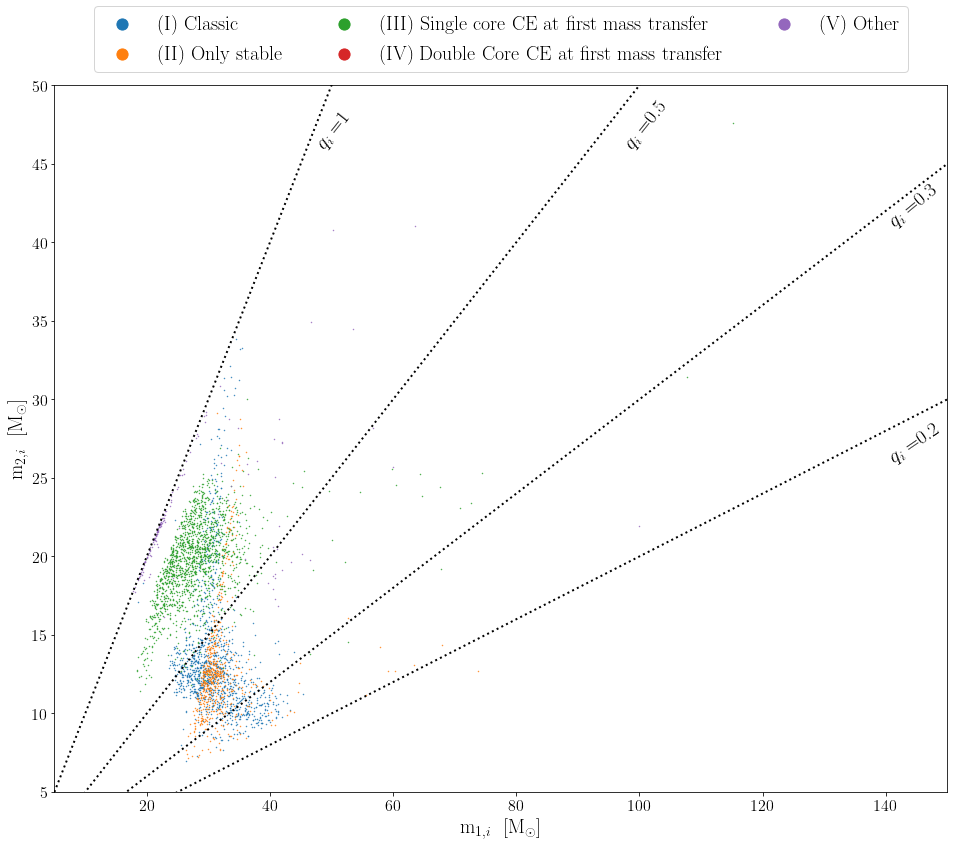

In [92]:
def plot_masses_channels_ZAMS(data):
    """
    This function plots the primary and secondary masses for BHNS mergers in given data for each formation channel.

    ...

    Parameters
    ----------
    data : dict
        a two-dimensional dictionary containing the corresponding compas objects for each of the alpha/beta values

    """

    # Declare figure
    fig = plt.figure(figsize=(16, 13))

    # Set the data that we will plot
    fiducial_data = data['2.0']['0.5']
    fiducial_data.setCOMPASDCOmask(types='BHNS', withinHubbleTime=True)
    fiducial_data.setCOMPASData()

    # Get the seeds
    dco_type_seeds = fiducial_data.seedsDCO

    # Get the important initial values
    mass_1, mass_2, seeds = fiducial_data.get_COMPAS_variables("BSE_System_Parameters", ["Mass@ZAMS(1)", "Mass@ZAMS(2)", "SEED"])

    # Get the initial masses of all dco objects
    dco_type_mask = np.in1d(seeds, dco_type_seeds)
    mass_1, mass_2= mass_1[dco_type_mask], mass_2[dco_type_mask]

    # Get the channels for all dcos
    channel = formation_channels.identify_formation_channels(dco_type_seeds, h5.File(fiducial_data.path))
    channel_types = {1: '(I) Classic', 2: '(II) Only stable', 3: '(III) Single core CE at first mass transfer', 4: '(IV) Double Core CE at first mass transfer', 0: '(V) Other'}
    
    # Iterate through the channels and plot each channel
    for ch_num, ch_name in channel_types.items():

        # Mask for the channel
        channel_mask = channel == ch_num

        # Get the primary and secondary masses for the channel
        mass_1_ch, mass_2_ch = mass_1[channel_mask], mass_2[channel_mask]

        # Plot the data
        plt.scatter(mass_1_ch, mass_2_ch, s=0.2, label=ch_name)

    # Plot dotted lines for a couple of mass ratios
    ax = plt.gca()                  # current axis
    q_list = [1, 0.5, 0.3, 0.2]     # list of mass ratios to plot

    # Label axes
    plt.xlabel(r'$\textrm{m}_{1,i}   \ \  [\rm{M}_{\odot}]$', fontsize=20)
    plt.ylabel(r'$\textrm{m}_{2,i}   \ \  [\rm{M}_{\odot}]$', fontsize=20)

    # Include legend
    fig.legend(fontsize=20, ncol=3, bbox_to_anchor=(0.875, 0.975),  markerscale=25)    
    
    # Adjust tick fontsize
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

    # Set limits of plot
    ax.set_xlim((5,150))
    ax.set_ylim((5,50))

    # Iterate through and plot each q value
    for q_val in q_list:
        xs = np.linspace(0, 150, num=10000)
        ys = q_val * xs
        xs_cut, ys_cut = xs[xs<=150], ys[ys<=50]
        x, y = max(xs_cut), max(ys_cut)
        if 150*q_val <= 50:
            plt.annotate(text=r'$q_i = ${qval}'.format(qval=q_val), fontsize=20, xy=(140, y - 4), rotation=113-math.degrees(math.atan(x/(y))))
        else:
            plt.annotate(text=r'$q_i = ${qval}'.format(qval=q_val), fontsize=20, xy=(max(xs[ys<=50])-3, 46), rotation=123-math.degrees(math.atan(x/(y))))
        plt.plot(xs, ys, c='k', lw=2, linestyle =':')

    # # Display the plot
    plt.show()

plot_masses_channels_ZAMS(data)

## c) Formation and merger rate plot divided into formation channel

### i. BNS

Average_SF_mass_needed =  292057123.365662 solMass
Average_SF_mass_needed =  1260253630.9487846 solMass
Average_SF_mass_needed =  6329071447.516748 solMass
Average_SF_mass_needed =  452119043.92627805 solMass


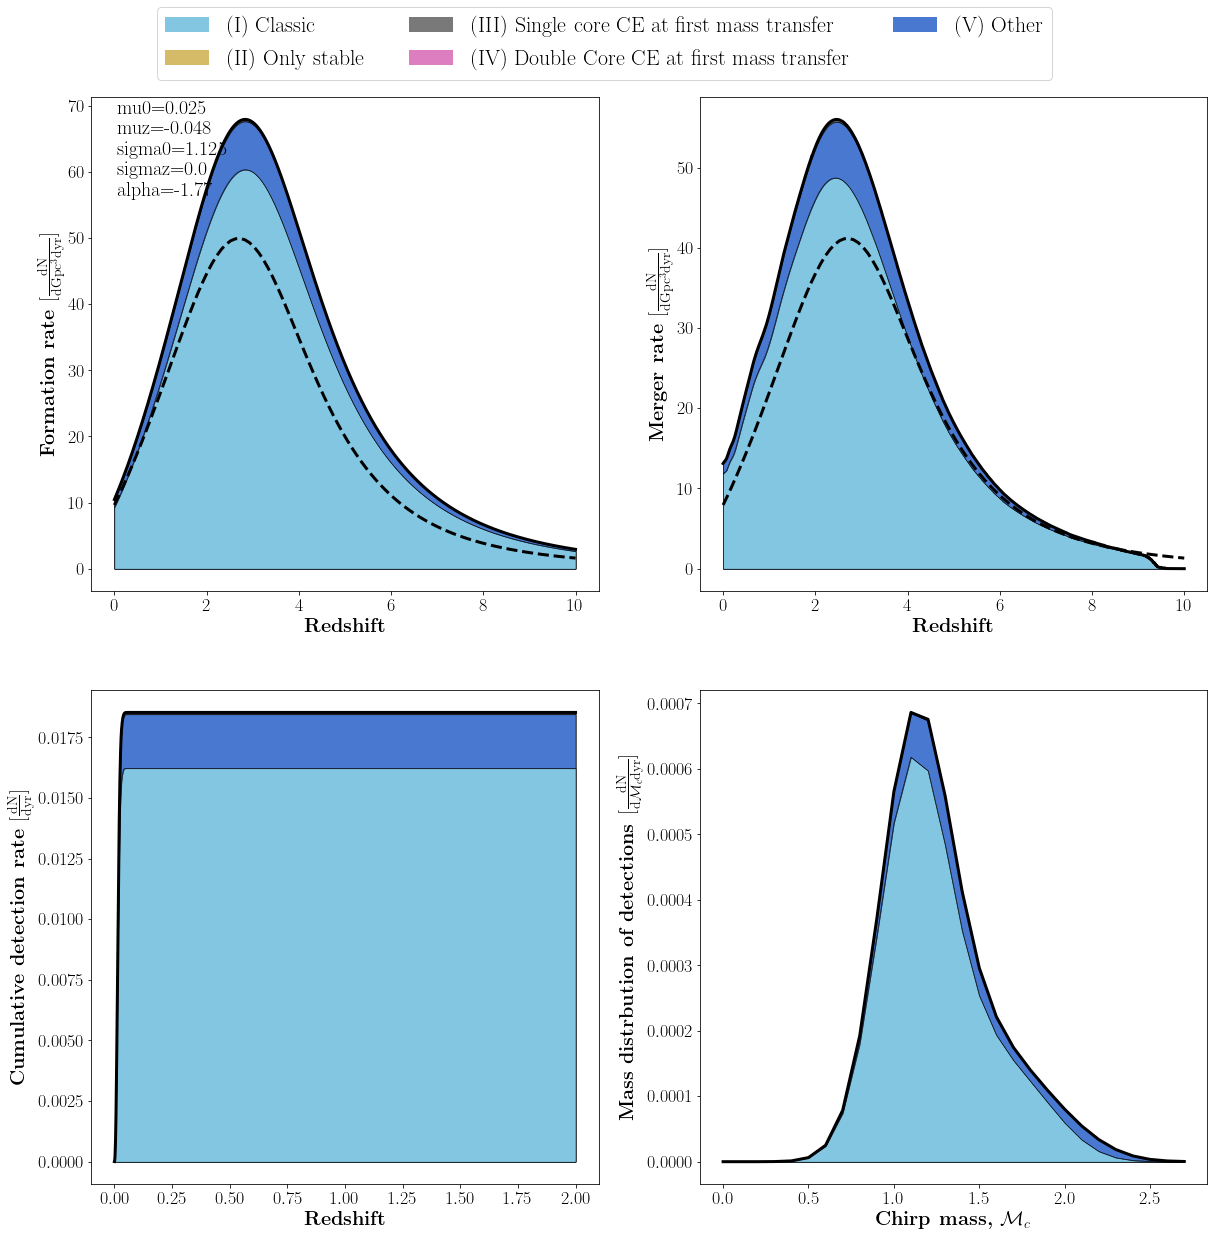

In [28]:
def plot_rates_by_channel(condensed_paths, data, alpha_val, beta_val, dco_type=None, merger_output_filename=None, weight_column=None,
        merges_hubble_time=True, pessimistic_CEE=True, no_RLOF_after_CEE=True,
        max_redshift=10.0, max_redshift_detection=1.0, redshift_step=0.001, z_first_SF = 10,
        use_sampled_mass_ranges=True, m1_min=5 * u.Msun, m1_max=150 * u.Msun, m2_min=0.1 * u.Msun, fbin=1.0,
        aSF = 0.01, bSF = 2.77, cSF = 2.90, dSF = 4.70,
        mu0=0.035, muz=-0.23, sigma0=0.39,sigmaz=0., alpha=0.0, 
        min_logZ=-12.0, max_logZ=1.0, step_logZ=0.01,
        sensitivity="O1", snr_threshold=8, 
        Mc_max=300.0, Mc_step=0.1, eta_max=0.25, eta_step=0.01,
        snr_max=1000.0, snr_step=0.1, lw=0.2, bw=0.3):
        
        """
        This function plots the formation rate, merger rate, cumulative detection rate, and mass distribution for a set of COMPAS binaries. 
        It breaks up the plots color-coded segments that represent different formation channels

        ...

        Parameters
        ----------
        condensed_paths : dict
            a two-dimensional dictionary containing the path to the paths to each h5 file

        data : dict
            a two-dimensional dictionary containing the COMPAS objects for each of the corresponding condensed_paths files

        alpha_val : str
            the value of the alpha_CE parameter of the COMPAS runs

        beta_val : str
            the value of the alpha_CE parameter of the COMPAS runs

        dco_type : str
            the type of DCO that we will be plots ('BBH', 'BNS', or 'BHNS')

        NOTE: The rest of the parameters either define the universe for our calculations, or are for formatting purposes.

        """



        ###########################
        # Calculate all the rates

        # Make sure that the user gives a dco_type
        assert dco_type != None, 'dco_type must be given'

        # The dictionaries for the values that will be calculated and plotted
        cumulative_detection_rates = {}
        detection_rates_by_binary = {}
        total_detection_rates = {}
        total_formation_rates = {}
        total_merger_rates = {}
        chirp_masses = {}
        redshifts = {}

        # The channel types and colors
        channel_types = {1: '(I) Classic', 2: '(II) Only stable', 3: '(III) Single core CE at first mass transfer', 4: '(IV) Double Core CE at first mass transfer', 0: '(V) Other'}
        channel_colors = {}
        for ch_num in channel_types.keys():
            channel_colors[ch_num] = sns.color_palette('muted')[-ch_num]
                
        # Set the data that we will plot
        fiducial_data = data[alpha_val][beta_val]
        fiducial_data.setCOMPASDCOmask(types=dco_type, withinHubbleTime=True)
        fiducial_data.setCOMPASData()
        
        # Identify the formation channels of each DCO
        channel = formation_channels.identify_formation_channels(fiducial_data.seedsDCO, h5.File(fiducial_data.path))

        # Get the channel numbers from the keys of channel_types
        keys = channel_types.copy().keys()
        
        # Delete the channel_type of any channel that has a count of zero
        for ch_num in keys:
            if np.count_nonzero(np.array(channel)==ch_num) == 0:
                del channel_types[ch_num]

        # Iterate through the channels and calculate the values to be plotted
        for ch_num in channel_types.keys():
            detection_rates, formation_rates, merger_rates, redshifts[ch_num], COMPASs = \
            FCI.find_detection_rate_by_channel(
            condensed_paths[alpha_val][beta_val], ch_num, dco_type=dco_type, weight_column=weight_column,
            merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
            no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
            max_redshift_detection=max_redshift_detection,
            redshift_step=redshift_step, z_first_SF=z_first_SF,
            m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
            fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
            mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
            min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
            sensitivity=sensitivity, snr_threshold=snr_threshold,
            Mc_max=Mc_max, Mc_step=Mc_step,
            eta_max=eta_max, eta_step=eta_step,
            snr_max=snr_max, snr_step=snr_step)

            # Mask for the current channel
            channel_mask = channel==ch_num
            # Calculate chirp masses
            chirp_masses[ch_num] = np.array((COMPASs.mass1[channel_mask]*COMPASs.mass2[channel_mask])**(3./5.) / (COMPASs.mass1[channel_mask] + COMPASs.mass2[channel_mask])**(1./5.))

            # sum things up across binaries
            total_formation_rates[ch_num] = np.sum(formation_rates, axis=0)
            total_merger_rates[ch_num] = np.sum(merger_rates, axis=0)
            total_detection_rates[ch_num] = np.sum(detection_rates, axis=0)

            # take the cumulative sum of the detection rates
            cumulative_detection_rates[ch_num] = np.cumsum(total_detection_rates[ch_num])
            detection_rates_by_binary[ch_num] = np.sum(detection_rates, axis=1)

            # empty trash
            del detection_rates
            del formation_rates
            del merger_rates
            del COMPASs



        ###########################
        # Get ready to plot

        # set some constants for the plots
        plt.rc('font', family='serif')
        fs = 20
        fig, axes = plt.subplots(2, 2, figsize=(20, 20))

        # Calculate and scare the SFR to plot on the formation and merger rate plots
        sfr_redshifts = np.linspace(0, 10, num=100)
        sfr = FCI.find_sfr(sfr_redshifts, a = aSF, b = bSF, c = cSF, d = dSF)

        # Dictionaries for the areas under each of the curves
        formation_rate_area = {}
        merger_rate_area = {}
        chirp_masses_area = {}
        cumulative_detection_rates_area = {}
        mass_kdes = {}

        # Calculate the area under each curve for the data we will plot
        index = 0
        for ch_num in channel_types.keys():
            if index == 0:
                Mc_bins = np.arange(0,max(chirp_masses[ch_num])*1.3, max(chirp_masses[ch_num])*1.2/100)
                Mc_bin_max = max(chirp_masses[ch_num])
            else:
                if max(chirp_masses[ch_num]) > Mc_bin_max:
                    Mc_bins = np.arange(0,max(chirp_masses[ch_num])*1.3, max(chirp_masses[ch_num])*1.2/100)
                    Mc_bin_max = max(chirp_masses[ch_num])
            index+=1
        
        # The x-axis for the chirp mass KDE
        axis = np.arange(Mc_bins[0], Mc_bins[-1],0.1) 

        # Calculate the area under the curve for all the pannels and channels
        for ch_num in channel_types.keys():
            # Get the area under the curve for each of the channels in each panel
            formation_rate_area[ch_num] = np.trapz(total_formation_rates[ch_num], x=redshifts[ch_num])
            merger_rate_area[ch_num] = np.trapz(total_merger_rates[ch_num], x=redshifts[ch_num])
            cumulative_detection_rates_area[ch_num] = np.trapz(cumulative_detection_rates[ch_num], x=redshifts[ch_num][:len(cumulative_detection_rates[ch_num])])

            # We have to do some fancy stuff for the chirp masses...
            if index == 0:
                # Get the Hist
                hist, _ = np.histogram(chirp_masses[ch_num], weights = detection_rates_by_binary[ch_num], bins=Mc_bins)
                
                # Get the KDE
                mass_kde = FFTKDE(bw=bw).fit(chirp_masses[ch_num], weights=detection_rates_by_binary[ch_num]).evaluate(axis)

                # Normalize the KDE
                mass_kdes[ch_num] = mass_kde*sum(hist)*np.diff(Mc_bins)[0]
            else:
                # Get the Hist
                hist, _ = np.histogram(chirp_masses[ch_num], weights = detection_rates_by_binary[ch_num], bins=Mc_bins)

                # Get the KDE
                mass_kde = FFTKDE(bw=bw).fit(chirp_masses[ch_num], weights=detection_rates_by_binary[ch_num]).evaluate(axis)

                # Normalize the KDE
                mass_kdes[ch_num] = mass_kde*sum(hist)*np.diff(Mc_bins)[0]

            chirp_masses_area[ch_num] = np.trapz(mass_kdes[ch_num], x=axis)
            index+=1
        
        # Sort the areas by descending order
        asc_formation_rates             = dict(sorted(formation_rate_area.items(), key=lambda x: x[1], reverse=True))
        asc_merger_rates                = dict(sorted(merger_rate_area.items(), key=lambda x: x[1], reverse=True))
        asc_mass_kdes                   = dict(sorted(chirp_masses_area.items(), key=lambda x: x[1], reverse=True))
        asc_cumulative_detection_rates  = dict(sorted(cumulative_detection_rates_area.items(), key=lambda x: x[1], reverse=True))



        ###########################
        # PLOT ON THE FOUR PANELS

        # FORMATION RATES
        sums = {}
        order = []
        current_sum = np.zeros(len(redshifts[ch_num]))
        # Add up the disributions in order
        for ch_num in asc_formation_rates.keys():
            current_sum += total_formation_rates[ch_num]
            sums[ch_num] = current_sum.copy()
            order.append(ch_num)

        # Add text upper left corner
        axes[0,0].text(0.05,0.8, 
                "mu0={} \nmuz={} \nsigma0={} \nsigmaz={} \nalpha={}".format(mu0,muz,sigma0,sigmaz,alpha), 
                transform=axes[0,0].transAxes, size = fs) 
        for ax in axes.flatten():
                ax.tick_params(labelsize=0.9*fs)
        
        # Plot
        for ch_num in order[::-1]:
            axes[0,0].fill_between(redshifts[ch_num], sums[ch_num], edgecolor='k', lw=lw, y2=np.zeros(len(sums[ch_num])), facecolor=channel_colors[ch_num])
            axes[0,0].plot(redshifts[ch_num], sums[ch_num], lw=lw, color='k')
            if ch_num == order[::-1][0]:
                axes[0,0].plot(redshifts[ch_num], sums[ch_num], lw=3, color='k')
    
        # MERGER RATES
        sums = {}
        order = []
        current_sum = np.zeros(len(redshifts[ch_num]))
        # Add up the disributions in order
        for ch_num in asc_merger_rates.keys():
            current_sum += total_merger_rates[ch_num]
            sums[ch_num] = current_sum.copy()
            order.append(ch_num)
        
        # Plot
        for ch_num in order[::-1]:
            axes[0,1].fill_between(redshifts[ch_num], sums[ch_num], edgecolor='k', label=channel_types[ch_num], lw=lw, y2=np.zeros(len(sums[ch_num])), facecolor=channel_colors[ch_num])
            axes[0,1].plot(redshifts[ch_num], sums[ch_num], lw=lw, color='k')
            if ch_num == order[::-1][0]:
                axes[0,1].plot(redshifts[ch_num], sums[ch_num], lw=3, color='k')

        # CUMULATIVE DETECTION RATES
        sums = {}
        order = []
        current_sum = np.zeros(len(cumulative_detection_rates[ch_num]))
        # Add up the disributions in order
        for ch_num in asc_cumulative_detection_rates.keys():
            current_sum += cumulative_detection_rates[ch_num]
            sums[ch_num] = current_sum.copy()
            order.append(ch_num)
        
        # Plot
        for ch_num in order[::-1]:
            axes[1,0].fill_between(redshifts[ch_num][:len(sums[ch_num])], sums[ch_num], lw=lw, edgecolor='k', y2=np.zeros(len(sums[ch_num])), facecolor=channel_colors[ch_num])
            axes[1,0].plot(redshifts[ch_num][:len(sums[ch_num])], sums[ch_num], linewidth=lw, color='k')
            if ch_num == order[::-1][0]:
                axes[1,0].plot(redshifts[ch_num][:len(sums[ch_num])], sums[ch_num], lw=3, color='k')

        # Mass KDEs
        sums = {}
        order = []
        current_sum = np.zeros(len(axis))
        # Add up the disributions in order
        for ch_num in asc_mass_kdes.keys():
            current_sum += mass_kdes[ch_num]
            sums[ch_num] = current_sum.copy()
            order.append(ch_num)
        
        # Plot
        for ch_num in order[::-1]:
            axes[1,1].fill_between(axis, sums[ch_num], y2=np.zeros(len(sums[ch_num])), edgecolor='k', lw=lw, facecolor=channel_colors[ch_num]) 
            axes[1,1].plot(axis, sums[ch_num], lw=lw, color='k')
            if ch_num == order[::-1][0]:
                axes[1,1].plot(axis, sums[ch_num], lw=3, color='k')



        ###########################
        # FORMAT THE PLOTS

        # Label axes of all the plots
        axes[0,0].set_xlabel(r'\textbf{Redshift}', fontsize=fs)
        axes[0,0].set_ylabel(r'\textbf{Formation rate $[\rm \frac{\mathrm{d}N}{\mathrm{d}Gpc^3 \mathrm{d}yr}]$}', fontsize=fs)

        axes[0,1].set_xlabel(r'\textbf{Redshift}', fontsize=fs)
        axes[0,1].set_ylabel(r'\textbf{Merger rate $[\rm \frac{\mathrm{d}N}{\mathrm{d}Gpc^3 \mathrm{d}yr}]$}', fontsize=fs)

        axes[1,0].set_xlabel(r'\textbf{Redshift}', fontsize=fs)
        axes[1,0].set_ylabel(r'\textbf{Cumulative detection rate $[\rm \frac{\mathrm{d}N}{\mathrm{d}yr}]$}', fontsize=fs)

        axes[1,1].set_xlabel(r'\textbf{Chirp mass, $\mathcal{M}_c$}', fontsize=fs)
        axes[1,1].set_ylabel(r'\textbf{Mass distrbution of detections $[\rm \frac{\mathrm{d}N}{\mathrm{d}\mathcal{M}_c \mathrm{d}yr}]$}', fontsize=fs)

        # Set upper limit on x axis for chirp mass distribution
        xlims = axes[1,1].get_xlim()
        if xlims[1] >= 40:
            axes[1,1].set_xlim([xlims[0], 40])

        # Scale SFR differently for each DCO type
        sfr = sfr/max(sfr)
        form_const, merger_const = axes[0,0].get_ylim()[1] * 0.7, axes[0,1].get_ylim()[1] * 0.7

        # Plot SFRs
        axes[0,0].plot(sfr_redshifts, sfr * form_const, color='black', lw=3, linestyle='dashed')
        axes[0,1].plot(sfr_redshifts, sfr * merger_const, color='black', lw=3, linestyle='dashed', label=r'SFR')

        # Create legend
        legend_elements = []
        channel_types = {1: '(I) Classic', 2: '(II) Only stable', 3: '(III) Single core CE at first mass transfer', 4: '(IV) Double Core CE at first mass transfer', 0: '(V) Other'}
        for channel_num in keys:
            legend_elements.append(mpatches.Patch(facecolor=channel_colors[channel_num], label=channel_types[channel_num]))

        # Include legend
        fig.legend(handles=legend_elements, fontsize=22, ncol=3, bbox_to_anchor=(0.8, .95),  markerscale=25) 

        # Show the plot!
        plt.show()

plot_rates_by_channel(condensed_paths, data, '2.0', '0.5', dco_type='BNS', weight_column=weight_column,
            merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
            no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
            max_redshift_detection=max_redshift_detection,
            redshift_step=redshift_step, z_first_SF=z_first_SF,
            m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
            fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
            mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
            min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
            sensitivity=sensitivity, snr_threshold=snr_threshold,
            Mc_max=Mc_max, Mc_step=Mc_step,
            eta_max=eta_max, eta_step=eta_step,
            snr_max=snr_max, snr_step=snr_step, lw=0.5, bw=0.2)

### ii. BHNS

Average_SF_mass_needed =  860173952.2966917 solMass
Average_SF_mass_needed =  1117384733.2690792 solMass
Average_SF_mass_needed =  743459168.4440637 solMass
Average_SF_mass_needed =  1041324653.8872161 solMass


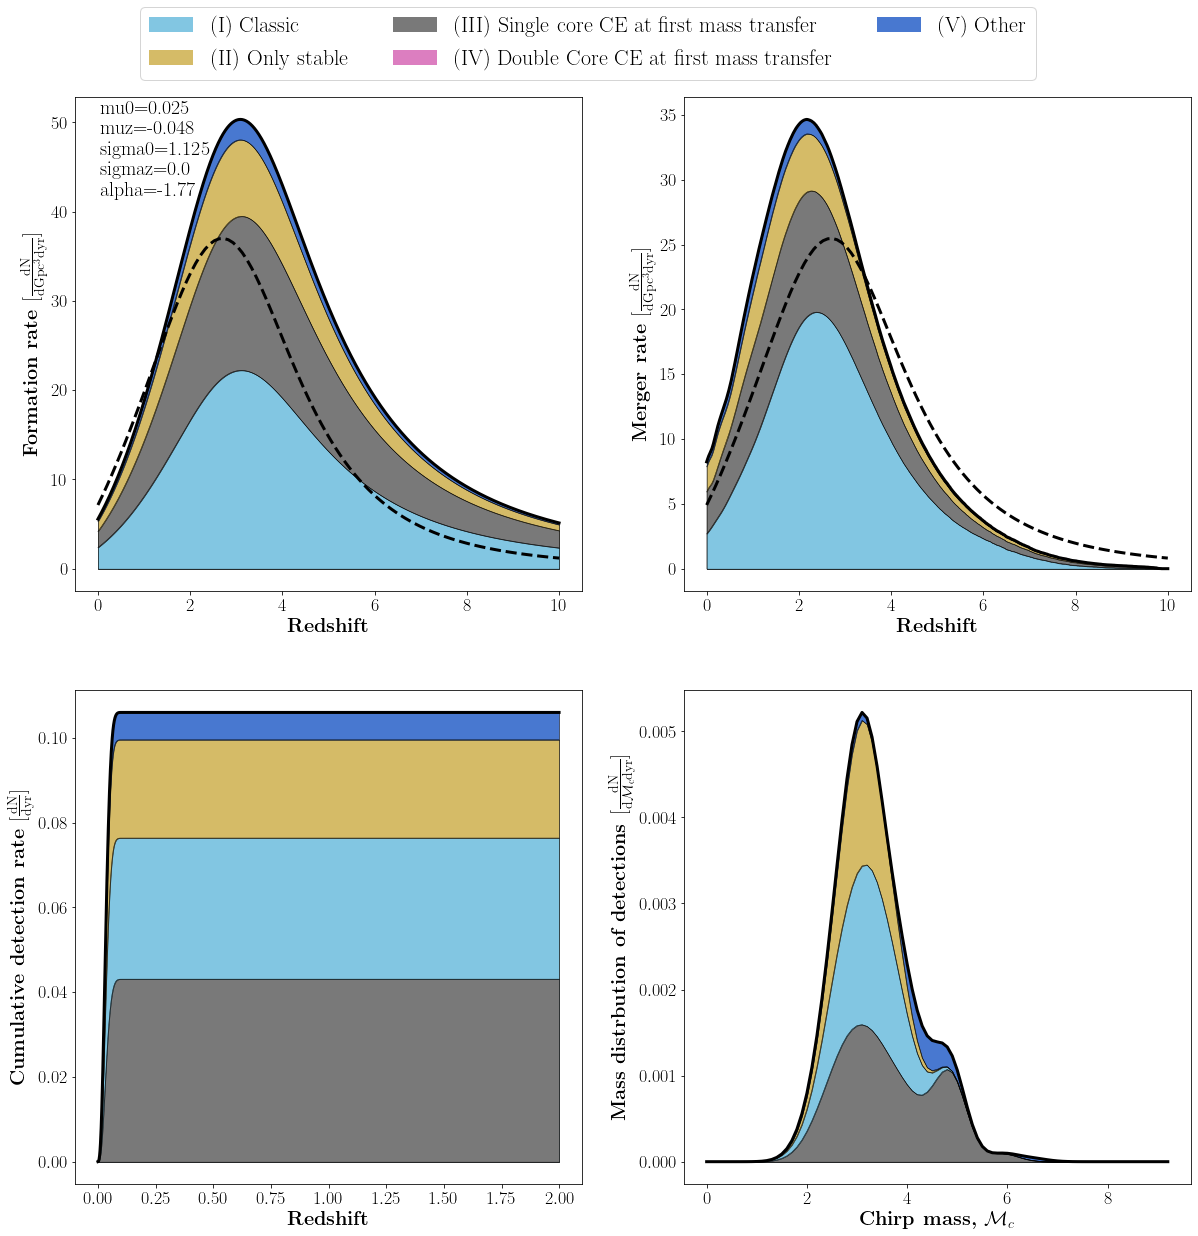

In [29]:
plot_rates_by_channel(condensed_paths, data, '2.0', '0.5', dco_type='BHNS', weight_column=weight_column,
            merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
            no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
            max_redshift_detection=max_redshift_detection,
            redshift_step=redshift_step, z_first_SF=z_first_SF,
            m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
            fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
            mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
            min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
            sensitivity=sensitivity, snr_threshold=snr_threshold,
            Mc_max=Mc_max, Mc_step=Mc_step,
            eta_max=eta_max, eta_step=eta_step,
            snr_max=snr_max, snr_step=snr_step, lw=0.5, bw=0.3)

### iii. BBH

Average_SF_mass_needed =  721161269.3390975 solMass
Average_SF_mass_needed =  1162560309.7051997 solMass
Average_SF_mass_needed =  1448091045.6695452 solMass
Average_SF_mass_needed =  169071982106.5829 solMass
Average_SF_mass_needed =  1192348311.3983119 solMass


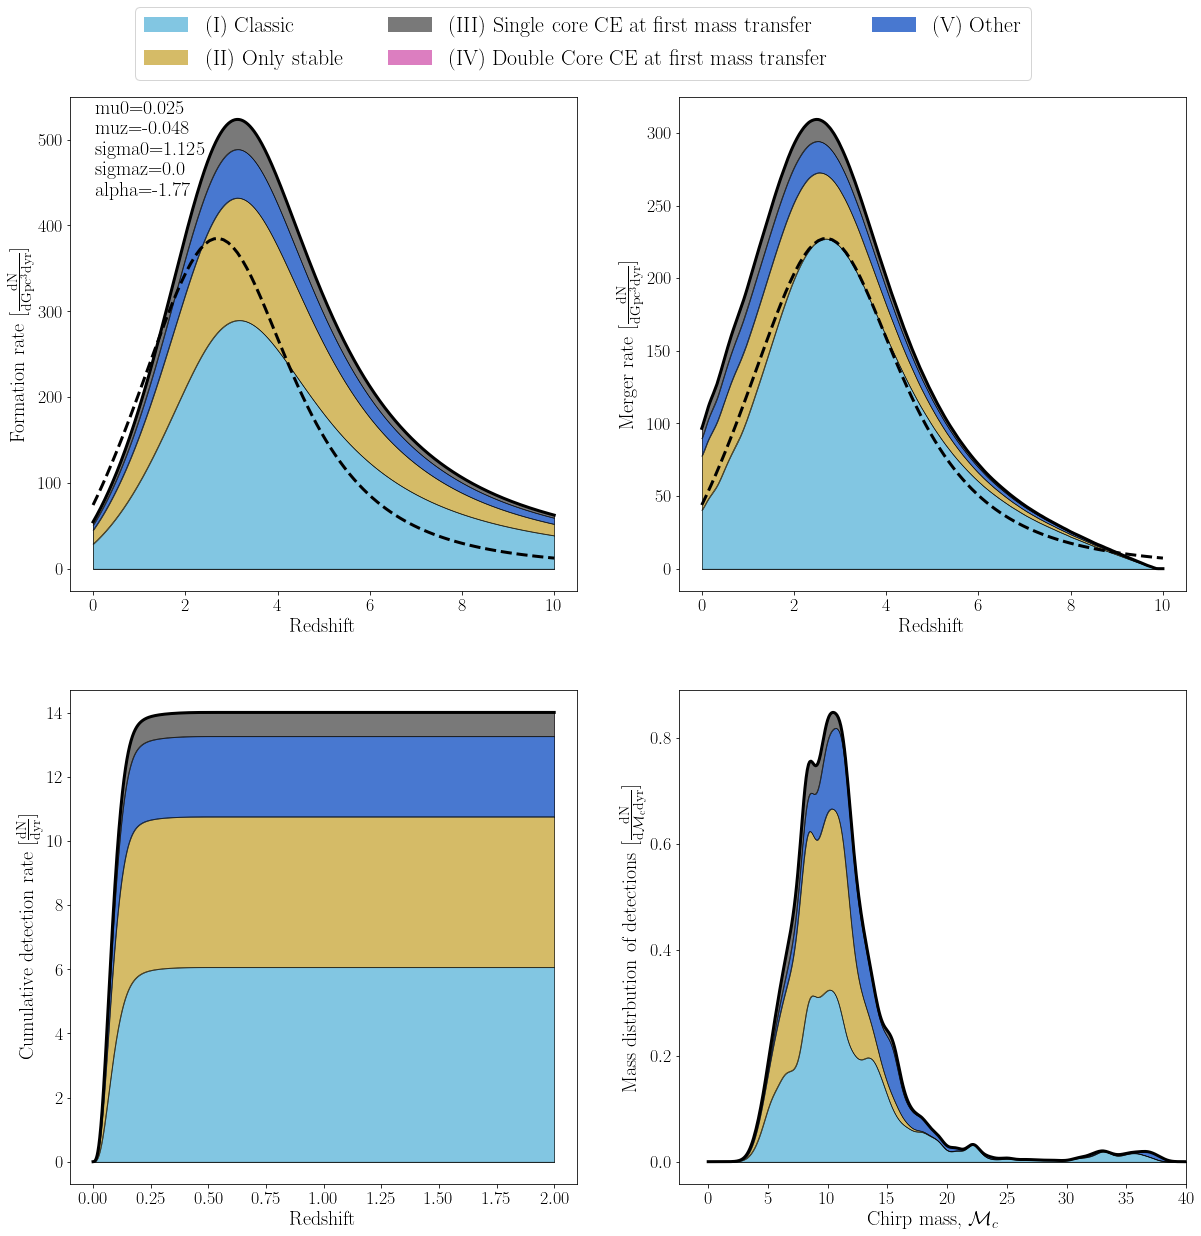

In [29]:
plot_rates_by_channel(condensed_paths, data, '2.0', '0.5', dco_type='BBH', weight_column=weight_column,
            merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
            no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
            max_redshift_detection=max_redshift_detection,
            redshift_step=redshift_step, z_first_SF=z_first_SF,
            m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
            fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
            mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
            min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
            sensitivity=sensitivity, snr_threshold=snr_threshold,
            Mc_max=Mc_max, Mc_step=Mc_step,
            eta_max=eta_max, eta_step=eta_step,
            snr_max=snr_max, snr_step=snr_step, lw=0.5, bw=0.5)

# 7. Delay time rate plots

## a) Formation and merger rate plot divided into delay times

### i. BNS

Average_SF_mass_needed =  309212827.6024585 solMass
Average_SF_mass_needed =  895961286.8775835 solMass
Average_SF_mass_needed =  963267799.4819918 solMass
Average_SF_mass_needed =  930872112.8731123 solMass
Average_SF_mass_needed =  519296114.31647855 solMass
Average_SF_mass_needed =  40685772780.756065 solMass
Average_SF_mass_needed =  3298662046.171702 solMass


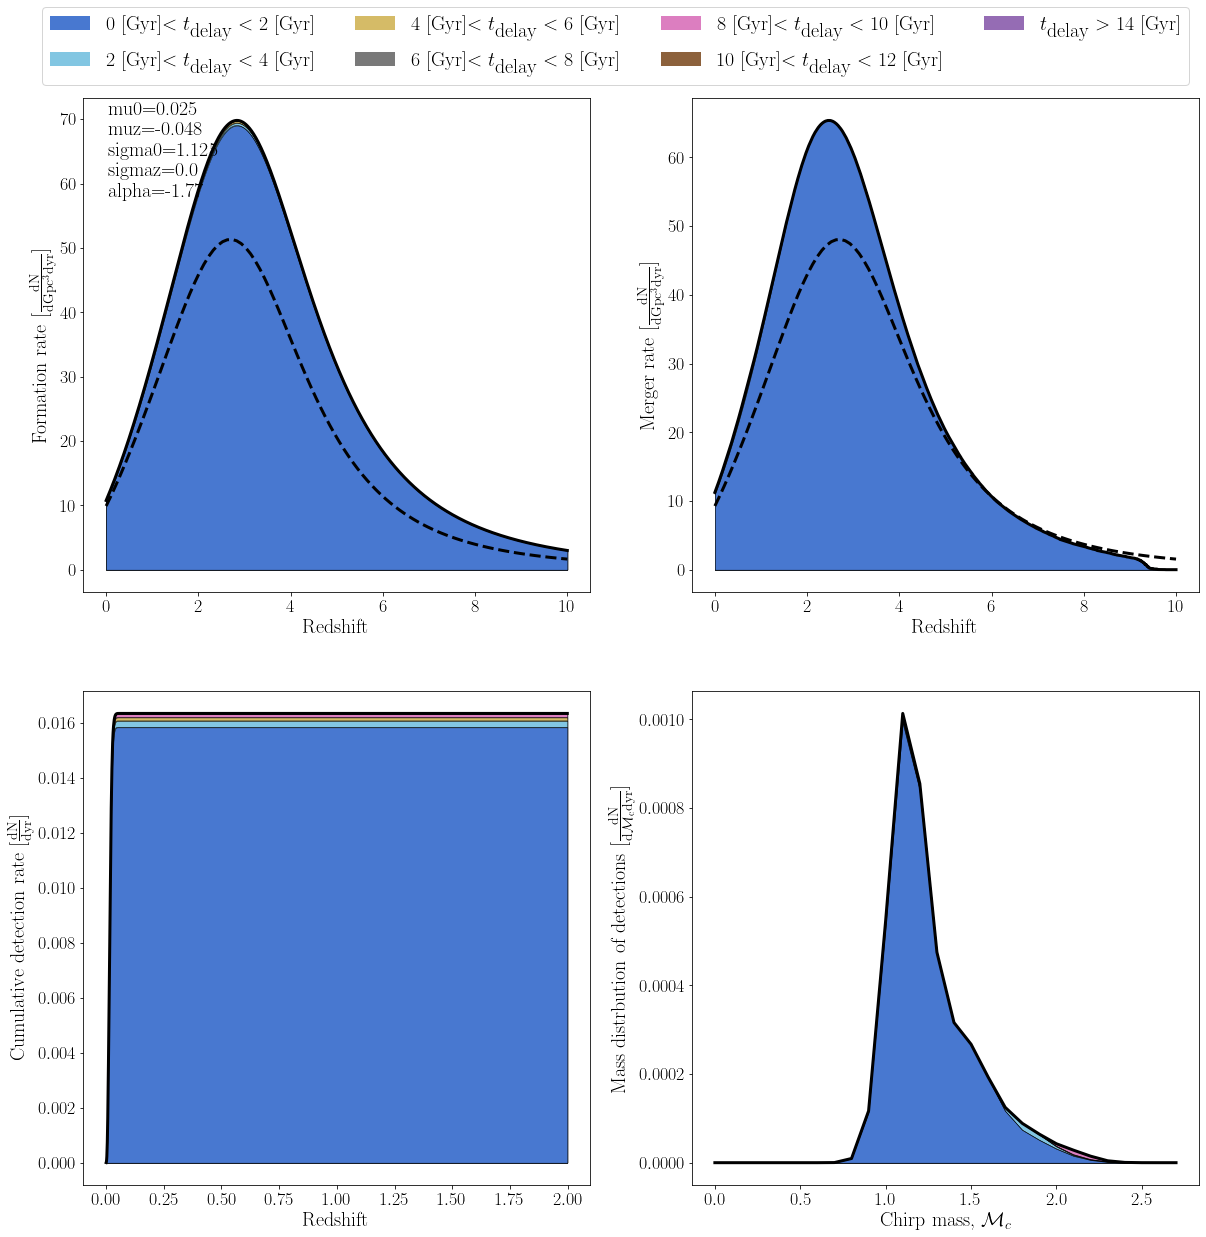

In [33]:
def plot_rates_by_delay_time(condensed_paths, data, alpha_val, beta_val, dco_type=None, merger_output_filename=None, weight_column=None,
        merges_hubble_time=True, pessimistic_CEE=True, no_RLOF_after_CEE=True,
        max_redshift=10.0, max_redshift_detection=1.0, redshift_step=0.001, z_first_SF = 10,
        use_sampled_mass_ranges=True, m1_min=5 * u.Msun, m1_max=150 * u.Msun, m2_min=0.1 * u.Msun, fbin=1.0,
        aSF = 0.01, bSF = 2.77, cSF = 2.90, dSF = 4.70,
        mu0=0.035, muz=-0.23, sigma0=0.39,sigmaz=0., alpha=0.0, 
        min_logZ=-12.0, max_logZ=1.0, step_logZ=0.01,
        sensitivity="O1", snr_threshold=8, 
        Mc_max=300.0, Mc_step=0.1, eta_max=0.25, eta_step=0.01,
        snr_max=1000.0, snr_step=0.1, lw=0.2, bw=0.3):
        
        """
        This function plots the formation rate, merger rate, cumulative detection rate, and mass distribution for a set of COMPAS binaries. 
        It breaks up the plots color-coded segments that represent different formation channels

        ...

        Parameters
        ----------
        condensed_paths : dict
            a two-dimensional dictionary containing the path to the paths to each h5 file

        data : dict
            a two-dimensional dictionary containing the COMPAS objects for each of the corresponding condensed_paths files

        alpha_val : str
            the value of the alpha_CE parameter of the COMPAS runs

        beta_val : str
            the value of the alpha_CE parameter of the COMPAS runs

        dco_type : str
            the type of DCO that we will be plots ('BBH', 'BNS', or 'BHNS')

        NOTE: The rest of the parameters either define the universe for our calculations, or are for formatting purposes.

        """



        ###########################
        # Calculate all the rates

        # Make sure that the user gives a dco_type
        assert dco_type != None, 'dco_type must be given'

        # The dictionaries for the values that will be calculated and plotted
        cumulative_detection_rates = {}
        total_detection_rates = {}
        total_formation_rates = {}
        total_merger_rates = {}
        chirp_masses = {}
        redshifts = {}
        detection_rates_by_binary = {}

        # Make bins, bin labels, and colors
        bin_edges = np.linspace(0, 14, num=8) * 1000 # [Myrs]
        bins = {}
        bin_labels = {}
        bin_colors = {}
        for index in range(len(bin_edges) - 1):
            bins[index] = [bin_edges[index], bin_edges[index+1]]
            if index == (len(bin_edges) - 2):
                bin_labels[index] = r'$t_\textrm{delay} >$ ' + str(int(bin_edges[index+1]/1000)) + '  [Gyr]' #[Gyrs]
            else:
                bin_labels[index] = str(int(bin_edges[index]/1000)) + '  [Gyr]' + r'$ < t_\textrm{delay} <$ ' + str(int(bin_edges[index+1]/1000)) + '  [Gyr]' #[Gyrs]
            bin_colors[index] = sns.color_palette('muted')[-index]
        
        # Set the data that we will plot
        fiducial_data = data[alpha_val][beta_val]
        fiducial_data.setCOMPASDCOmask(types=dco_type, withinHubbleTime=True)
        fiducial_data.setCOMPASData()

        # Mak masks to filer for the channel only
        time, coalescence_time = fiducial_data.get_COMPAS_variables("BSE_Double_Compact_Objects",["Time", "Coalescence_Time"])
        t_delay = time[fiducial_data.DCOmask] + coalescence_time[fiducial_data.DCOmask]


        # Masks for each bin
        bin_masks = {}
        sps_bin_mask = {}
        for bin_num, bin in bins.items():
            bin_masks[bin_num] = np.logical_and(t_delay>=bin[0], t_delay < bin[1])
            bin_seeds = fiducial_data.seedsDCO[bin_masks[bin_num]]
            sps_seeds = fiducial_data.get_COMPAS_variables("BSE_System_Parameters", "SEED") # All of the seeds
            sps_bin_mask[bin_num] = np.isin(sps_seeds, bin_seeds)

        # Iterate through the channels and calculate the values to be plotted
        for bin_num, bin in bins.items():
            detection_rates, formation_rates, merger_rates, redshifts[bin_num], COMPASs = \
            FCI.find_detection_rate_by_delay_time(
            condensed_paths[alpha_val][beta_val], bin, dco_type=dco_type, weight_column=weight_column,
            merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
            no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
            max_redshift_detection=max_redshift_detection,
            redshift_step=redshift_step, z_first_SF=z_first_SF,
            m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
            fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
            mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
            min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
            sensitivity=sensitivity, snr_threshold=snr_threshold,
            Mc_max=Mc_max, Mc_step=Mc_step,
            eta_max=eta_max, eta_step=eta_step,
            snr_max=snr_max, snr_step=snr_step)
            if detection_rates is None:
                total_formation_rates[bin_num] = None
                total_merger_rates[bin_num] = None
                cumulative_detection_rates[bin_num] = None
                chirp_masses[bin_num] = None
            else:
                # Mask for the current channel
                bin_mask = bin_masks[bin_num]

                # Calculate chirp masses
                chirp_masses[bin_num] = np.array((COMPASs.mass1[bin_mask]*COMPASs.mass2[bin_mask])**(3./5.) / (COMPASs.mass1[bin_mask] + COMPASs.mass2[bin_mask])**(1./5.))

                # sum things up across binaries
                total_formation_rates[bin_num] = np.sum(formation_rates, axis=0)
                total_merger_rates[bin_num] = np.sum(merger_rates, axis=0)
                total_detection_rates[bin_num] = np.sum(detection_rates, axis=0)

                # take the cumulative sum of the detection rates
                cumulative_detection_rates[bin_num] = np.cumsum(total_detection_rates[bin_num])
                detection_rates_by_binary[bin_num] = np.sum(detection_rates, axis=1)

                # empty trash
                del detection_rates
                del formation_rates
                del merger_rates
                del COMPASs



        ###########################
        # Get ready to plot

        # set some constants for the plots
        plt.rc('font', family='serif')
        fs = 20
        fig, axes = plt.subplots(2, 2, figsize=(20, 20))

        # Calculate and scare the SFR to plot on the formation and merger rate plots
        sfr_redshifts = np.linspace(0, 10, num=100)
        sfr = FCI.find_sfr(sfr_redshifts, a = aSF, b = bSF, c = cSF, d = dSF)

        # Dictionaries for the areas under each of the curves
        formation_rate_area = {}
        merger_rate_area = {}
        chirp_masses_area = {}
        cumulative_detection_rates_area = {}
        mass_kdes = {}

        # Calculate the area under each curve for the data we will plot
        index = 0
        for bin_num in bins.keys():
            if index == 0:
                Mc_bins = np.arange(0,max(chirp_masses[bin_num])*1.3, max(chirp_masses[bin_num])*1.2/100)
                Mc_bin_max = max(chirp_masses[bin_num])
            else:
                if max(chirp_masses[bin_num]) > Mc_bin_max:
                    Mc_bins = np.arange(0,max(chirp_masses[bin_num])*1.3, max(chirp_masses[bin_num])*1.2/100)
                    Mc_bin_max = max(chirp_masses[bin_num])
            index+=1

        # The x-axis for the chirp mass KDE
        axis = np.arange(Mc_bins[0], Mc_bins[-1],0.1) 

        # Calculate the area under each curve for the data we will plot
        index = 0
        for bin_num in bins.keys():
            if total_formation_rates[bin_num] is None:
                formation_rate_area[bin_num] = 0
                merger_rate_area[bin_num] = 0
                cumulative_detection_rates_area[bin_num] = 0
                mass_kdes[bin_num] = 0
                chirp_masses_area[bin_num] = 0
            else:
                formation_rate_area[bin_num] = np.trapz(total_formation_rates[bin_num], x=redshifts[bin_num])
                merger_rate_area[bin_num] = np.trapz(total_merger_rates[bin_num], x=redshifts[bin_num])
                cumulative_detection_rates_area[bin_num] = np.trapz(cumulative_detection_rates[bin_num], x=redshifts[bin_num][:len(cumulative_detection_rates[bin_num])])

                # We have to do some fancy stuff for the chirp masses...
                if index == 0:
                    # Get the Hist
                    hist, _ = np.histogram(chirp_masses[bin_num], weights = detection_rates_by_binary[bin_num], bins=Mc_bins)
                    
                    # Get the KDE
                    mass_kde = FFTKDE(bw=bw).fit(chirp_masses[bin_num], weights=detection_rates_by_binary[bin_num]).evaluate(axis)

                    # Normalize the KDE
                    mass_kdes[bin_num] = mass_kde*sum(hist)*np.diff(Mc_bins)[0]
                else:
                    # Get the Hist
                    hist, _ = np.histogram(chirp_masses[bin_num], weights = detection_rates_by_binary[bin_num], bins=Mc_bins)

                    # Get the KDE
                    mass_kde = FFTKDE(bw=bw).fit(chirp_masses[bin_num], weights=detection_rates_by_binary[bin_num]).evaluate(axis)

                    # Normalize the KDE
                    mass_kdes[bin_num] = mass_kde*sum(hist)*np.diff(Mc_bins)[0]

                chirp_masses_area[bin_num] = np.trapz(mass_kdes[bin_num], x=axis)
                index+=1
        
        # Sort the areas by descending order
        asc_formation_rates             = dict(sorted(formation_rate_area.items(), key=lambda x: x[1], reverse=True))
        asc_merger_rates                = dict(sorted(merger_rate_area.items(), key=lambda x: x[1], reverse=True))
        asc_mass_kdes                   = dict(sorted(chirp_masses_area.items(), key=lambda x: x[1], reverse=True))
        asc_cumulative_detection_rates  = dict(sorted(cumulative_detection_rates_area.items(), key=lambda x: x[1], reverse=True))



        ###########################
        # PLOT ON THE FOUR PANELS

        # FORMATION RATES
        sums = {}
        order = []
        current_sum = np.zeros(len(redshifts[bin_num]))
        # Add up the disributions in order
        for bin_num in asc_formation_rates.keys():
            if total_formation_rates[bin_num] is not None:
                current_sum += total_formation_rates[bin_num]
                sums[bin_num] = current_sum.copy()
                order.append(bin_num)
        
        # Plot
        for bin_num in order[::-1]:
            axes[0,0].fill_between(redshifts[bin_num], sums[bin_num], edgecolor='k', lw=lw, y2=np.zeros(len(sums[bin_num])), facecolor=bin_colors[bin_num])
            axes[0,0].plot(redshifts[bin_num], sums[bin_num], lw=lw, color='k')
            if bin_num == order[::-1][0]:
                axes[0,0].plot(redshifts[bin_num], sums[bin_num], lw=3, color='k')
    
        # MERGER RATES
        sums = {}
        order = []
        current_sum = np.zeros(len(redshifts[bin_num]))
        # Add up the disributions in order
        for bin_num in asc_merger_rates.keys():
            if total_merger_rates[bin_num] is not None:
                current_sum += total_merger_rates[bin_num]
                sums[bin_num] = current_sum.copy()
                order.append(bin_num)
        
        # Plot
        for bin_num in order[::-1]:
            axes[0,1].fill_between(redshifts[bin_num], sums[bin_num], edgecolor='k', lw=lw, y2=np.zeros(len(sums[bin_num])), facecolor=bin_colors[bin_num])
            axes[0,1].plot(redshifts[bin_num], sums[bin_num], lw=lw, color='k')
            if bin_num == order[::-1][0]:
                axes[0,1].plot(redshifts[bin_num], sums[bin_num], lw=3, color='k')

        # CUMULATIVE DETECTION RATES
        sums = {}
        order = []
        current_sum = np.zeros(len(cumulative_detection_rates[bin_num]))
        # Add up the disributions in order
        for bin_num in asc_cumulative_detection_rates.keys():
            if cumulative_detection_rates[bin_num] is not None:
                current_sum += cumulative_detection_rates[bin_num]
                sums[bin_num] = current_sum.copy()
                order.append(bin_num)
        
        # Plot
        for bin_num in order[::-1]:
            axes[1,0].fill_between(redshifts[bin_num][:len(sums[bin_num])], sums[bin_num], lw=lw, edgecolor='k', y2=np.zeros(len(sums[bin_num])), facecolor=bin_colors[bin_num])
            axes[1,0].plot(redshifts[bin_num][:len(sums[bin_num])], sums[bin_num], linewidth=lw, color='k')
            if bin_num == order[::-1][0]:
                axes[1,0].plot(redshifts[bin_num][:len(sums[bin_num])], sums[bin_num], lw=3, color='k')

        # Mass KDEs
        sums = {}
        order = []
        current_sum = np.zeros(len(axis))
        # Add up the disributions in order
        for bin_num in asc_mass_kdes.keys():
            if chirp_masses[bin_num] is not None:
                current_sum += mass_kdes[bin_num]
                # axes[1,1].plot(axis, current_sum, lw=lw, color=channel_colors[ch_num])     
                # axes[1,1].fill_between(axis, current_sum, y2=np.zeros(len(mass_kdes[ch_num])))   
                sums[bin_num] = current_sum.copy()
                order.append(bin_num)
        
        # Plot
        for bin_num in order[::-1]:
            axes[1,1].fill_between(axis, sums[bin_num], y2=np.zeros(len(sums[bin_num])), edgecolor='k', lw=lw, facecolor=bin_colors[bin_num]) 
            axes[1,1].plot(axis, sums[bin_num], lw=lw, color='k')
            if bin_num == order[::-1][0]:
                axes[1,1].plot(axis, sums[bin_num], lw=3, color='k')



        ###########################
        # FORMAT THE PLOTS

        # Add text upper left corner
        axes[0,0].text(0.05,0.8, 
                "mu0={} \nmuz={} \nsigma0={} \nsigmaz={} \nalpha={}".format(mu0,muz,sigma0,sigmaz,alpha), 
                transform=axes[0,0].transAxes, size = fs) 
        for ax in axes.flatten():
                ax.tick_params(labelsize=0.9*fs)

        # Label axes of all the plots
        axes[0,0].set_xlabel('Redshift', fontsize=fs)
        axes[0,0].set_ylabel(r'Formation rate $[\rm \frac{\mathrm{d}N}{\mathrm{d}Gpc^3 \mathrm{d}yr}]$', fontsize=fs)

        axes[0,1].set_xlabel('Redshift', fontsize=fs)
        axes[0,1].set_ylabel(r'Merger rate $[\rm \frac{\mathrm{d}N}{\mathrm{d}Gpc^3 \mathrm{d}yr}]$', fontsize=fs)

        axes[1,0].set_xlabel('Redshift', fontsize=fs)
        axes[1,0].set_ylabel(r'Cumulative detection rate $[\rm \frac{\mathrm{d}N}{\mathrm{d}yr}]$', fontsize=fs)

        axes[1,1].set_xlabel(r'Chirp mass, $\mathcal{M}_c$', fontsize=fs)
        axes[1,1].set_ylabel(r'Mass distrbution of detections $[\rm \frac{\mathrm{d}N}{\mathrm{d}\mathcal{M}_c \mathrm{d}yr}]$', fontsize=fs)

        # Set upper limit on x axis for chirp mass distribution
        xlims = axes[1,1].get_xlim()
        if xlims[1] >= 40:
                axes[1,1].set_xlim([xlims[0], 40])

        # Scale SFR differently for each DCO type
        sfr = sfr/max(sfr)
        form_const, merger_const = axes[0,0].get_ylim()[1] * 0.7, axes[0,1].get_ylim()[1] * 0.7

        # Plot SFRs
        axes[0,0].plot(sfr_redshifts, sfr * form_const, color='black', lw=3, linestyle='dashed')
        axes[0,1].plot(sfr_redshifts, sfr * merger_const, color='black', lw=3, linestyle='dashed', label=r'SFR')

        # Create legend
        legend_elements = []
        for bin_num, bin in bins.items():
            legend_elements.append(mpatches.Patch(facecolor=bin_colors[bin_num], label=bin_labels[bin_num]))

        # Include legend
        fig.legend(handles=legend_elements, fontsize=20, ncol=4, bbox_to_anchor=(0.9, .95),  markerscale=25)

        # Show the plot!
        plt.show()

plot_rates_by_delay_time(condensed_paths, data, '2.0', '0.5', dco_type='BNS', weight_column=weight_column,
            merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
            no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
            max_redshift_detection=max_redshift_detection,
            redshift_step=redshift_step, z_first_SF=z_first_SF,
            m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
            fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
            mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
            min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
            sensitivity=sensitivity, snr_threshold=snr_threshold,
            Mc_max=Mc_max, Mc_step=Mc_step,
            eta_max=eta_max, eta_step=eta_step,
            snr_max=snr_max, snr_step=snr_step, lw=0.5, bw=0.1)

### ii. BHNS

Average_SF_mass_needed =  585302022.1202139 solMass
Average_SF_mass_needed =  614548539.5533804 solMass
Average_SF_mass_needed =  819622373.8200513 solMass
Average_SF_mass_needed =  788864083.0704082 solMass
Average_SF_mass_needed =  709581124.6960421 solMass
Average_SF_mass_needed =  874757146.770891 solMass
Average_SF_mass_needed =  1129217249.3828835 solMass


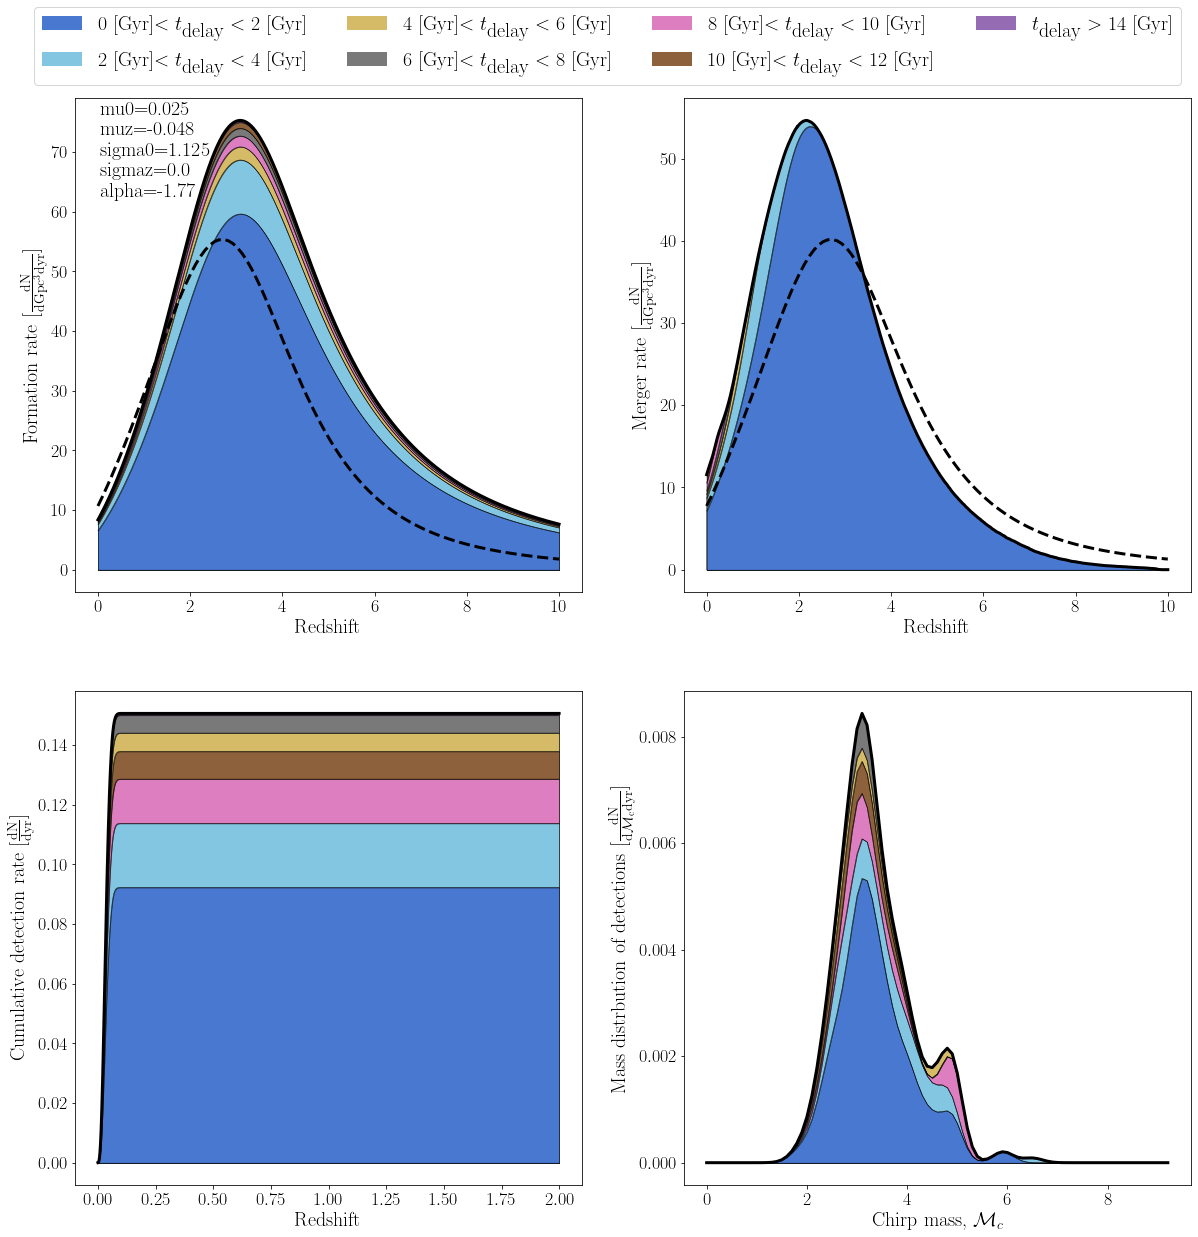

In [34]:
plot_rates_by_delay_time(condensed_paths, data, '2.0', '0.5', dco_type='BHNS', weight_column=weight_column,
            merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
            no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
            max_redshift_detection=max_redshift_detection,
            redshift_step=redshift_step, z_first_SF=z_first_SF,
            m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
            fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
            mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
            min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
            sensitivity=sensitivity, snr_threshold=snr_threshold,
            Mc_max=Mc_max, Mc_step=Mc_step,
            eta_max=eta_max, eta_step=eta_step,
            snr_max=snr_max, snr_step=snr_step, lw=0.5, bw=0.2)

### iii. BBH

Average_SF_mass_needed =  721015259.6894025 solMass
Average_SF_mass_needed =  796136363.6766156 solMass
Average_SF_mass_needed =  859932490.9472498 solMass
Average_SF_mass_needed =  782985791.5794663 solMass
Average_SF_mass_needed =  803551052.4204862 solMass
Average_SF_mass_needed =  805934673.7737858 solMass
Average_SF_mass_needed =  867241199.0026822 solMass


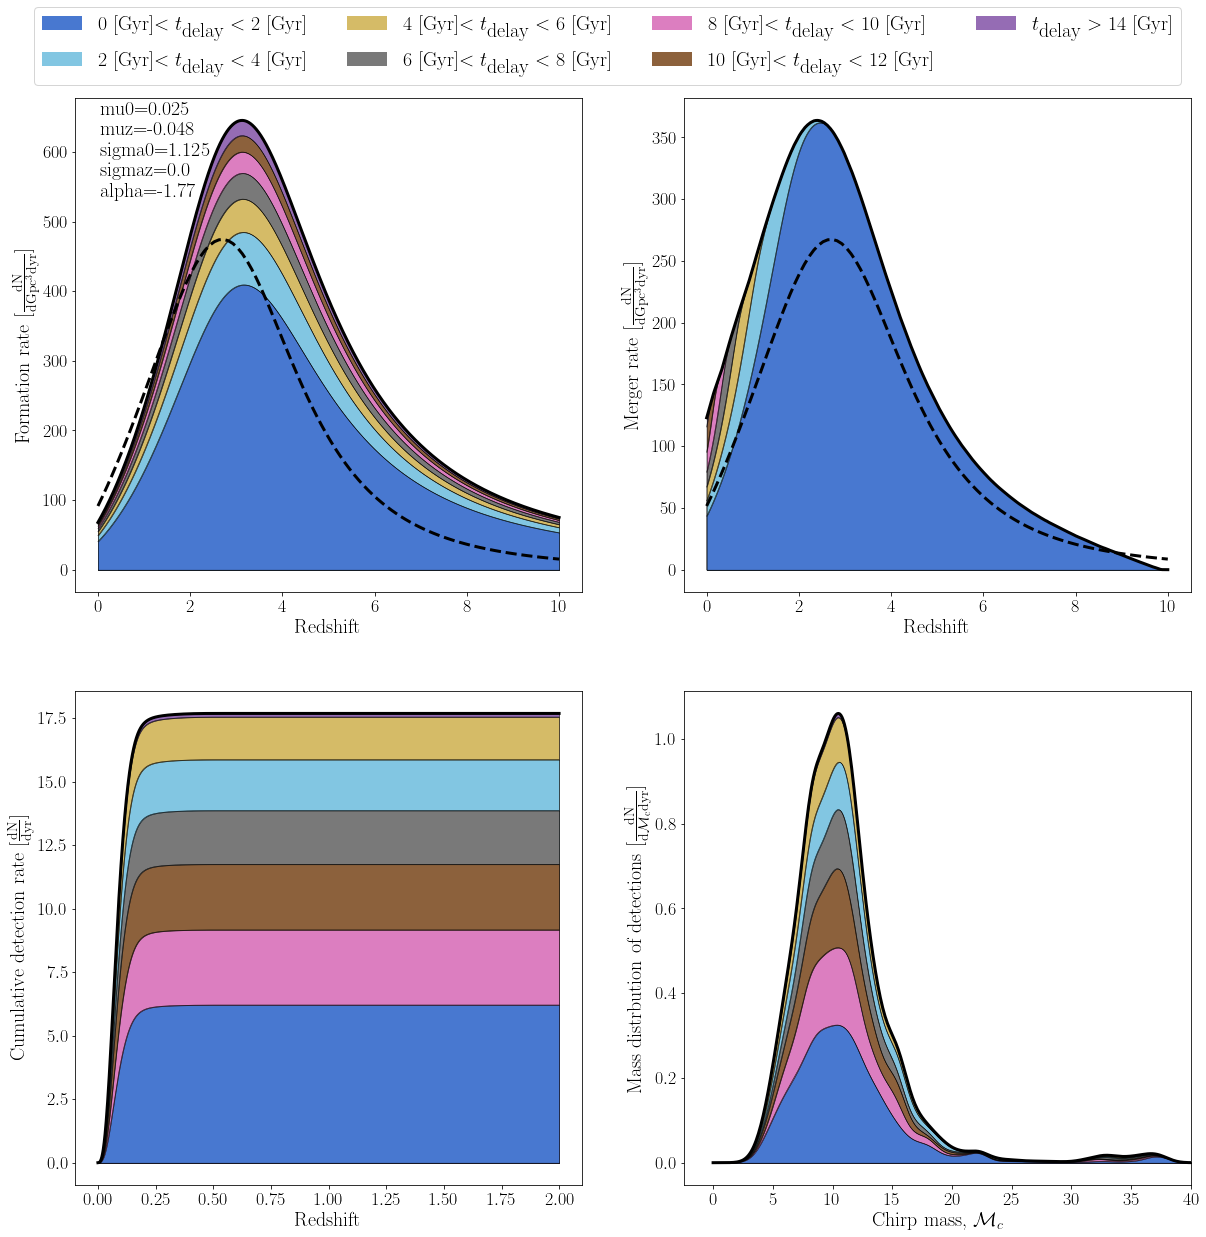

In [35]:
plot_rates_by_delay_time(condensed_paths, data, '2.0', '0.5', dco_type='BBH', weight_column=weight_column,
            merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
            no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
            max_redshift_detection=max_redshift_detection,
            redshift_step=redshift_step, z_first_SF=z_first_SF,
            m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
            fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
            mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
            min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
            sensitivity=sensitivity, snr_threshold=snr_threshold,
            Mc_max=Mc_max, Mc_step=Mc_step,
            eta_max=eta_max, eta_step=eta_step,
            snr_max=snr_max, snr_step=snr_step, lw=0.5, bw=0.75)

## b) Zoom in on 0 < z < 2 for the rate plots
This should give us some sort of insight into how $t_\textrm{delay}$ scales as $t^{-1}$

Average_SF_mass_needed =  722794438.8445413 solMass
Average_SF_mass_needed =  786235540.0834819 solMass
Average_SF_mass_needed =  864089326.2328784 solMass
Average_SF_mass_needed =  794220681.3629308 solMass
Average_SF_mass_needed =  815363877.0027003 solMass
Average_SF_mass_needed =  812295342.7684127 solMass
Average_SF_mass_needed =  877292978.5649394 solMass


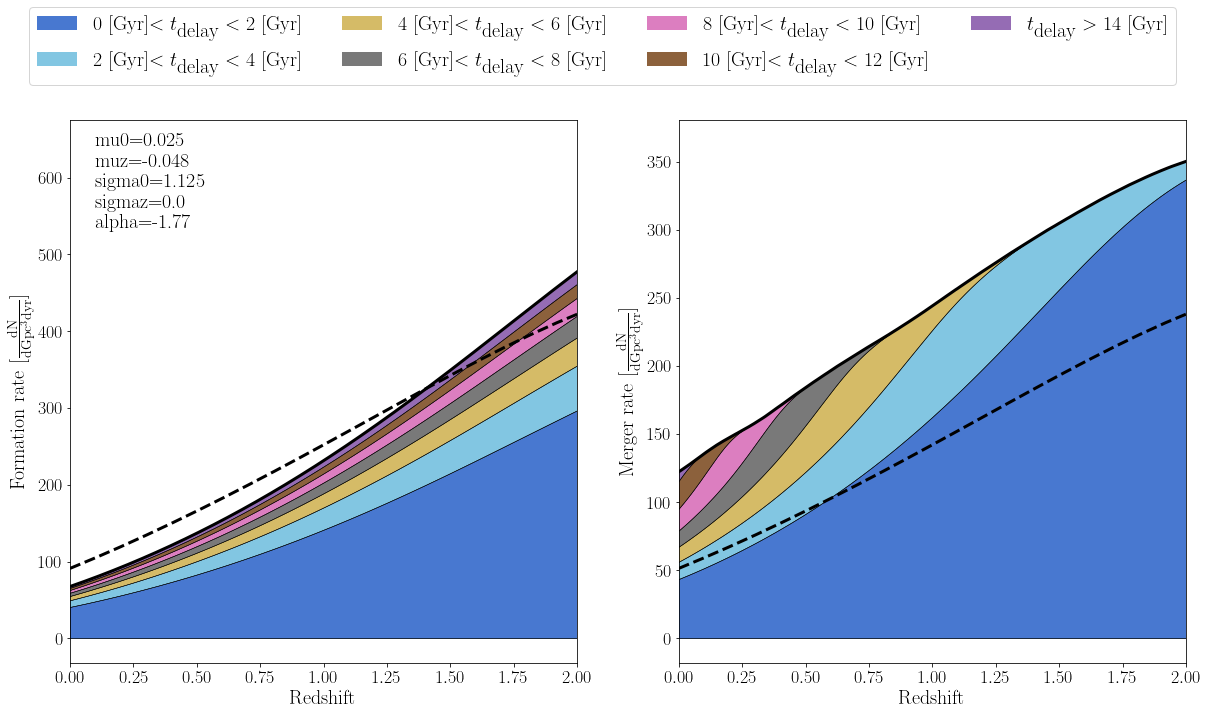

In [42]:
def plot_rates_by_delay_time_zoomed(condensed_paths, data, alpha_val, beta_val, dco_type=None, merger_output_filename=None, weight_column=None,
        merges_hubble_time=True, pessimistic_CEE=True, no_RLOF_after_CEE=True,
        max_redshift=10.0, max_redshift_detection=1.0, redshift_step=0.001, z_first_SF = 10,
        use_sampled_mass_ranges=True, m1_min=5 * u.Msun, m1_max=150 * u.Msun, m2_min=0.1 * u.Msun, fbin=1.0,
        aSF = 0.01, bSF = 2.77, cSF = 2.90, dSF = 4.70,
        mu0=0.035, muz=-0.23, sigma0=0.39,sigmaz=0., alpha=0.0, 
        min_logZ=-12.0, max_logZ=1.0, step_logZ=0.01,
        sensitivity="O1", snr_threshold=8, 
        Mc_max=300.0, Mc_step=0.1, eta_max=0.25, eta_step=0.01,
        snr_max=1000.0, snr_step=0.1, lw=0.2, bw=0.3):
        
        """
        This function plots the formation rate, merger rate, cumulative detection rate, and mass distribution for a set of COMPAS binaries. 
        It breaks up the plots color-coded segments that represent different formation channels

        ...

        Parameters
        ----------
        condensed_paths : dict
            a two-dimensional dictionary containing the path to the paths to each h5 file

        data : dict
            a two-dimensional dictionary containing the COMPAS objects for each of the corresponding condensed_paths files

        alpha_val : str
            the value of the alpha_CE parameter of the COMPAS runs

        beta_val : str
            the value of the alpha_CE parameter of the COMPAS runs

        dco_type : str
            the type of DCO that we will be plots ('BBH', 'BNS', or 'BHNS')

        NOTE: The rest of the parameters either define the universe for our calculations, or are for formatting purposes.

        """



        ###########################
        # Calculate all the rates

        # Make sure that the user gives a dco_type
        assert dco_type != None, 'dco_type must be given'

        # The dictionaries for the values that will be calculated and plotted
        total_formation_rates = {}
        total_merger_rates = {}
        redshifts = {}

        # Make bins, bin labels, and colors
        bin_edges = np.linspace(0, 14, num=8) * 1000 # [Myrs]
        bins = {}
        bin_labels = {}
        bin_colors = {}
        for index in range(len(bin_edges) - 1):
            bins[index] = [bin_edges[index], bin_edges[index+1]]
            if index == (len(bin_edges) - 2):
                bin_labels[index] = r'$t_\textrm{delay} >$ ' + str(int(bin_edges[index+1]/1000)) + '  [Gyr]' #[Gyrs]
            else:
                bin_labels[index] = str(int(bin_edges[index]/1000)) + '  [Gyr]' + r'$ < t_\textrm{delay} <$ ' + str(int(bin_edges[index+1]/1000)) + '  [Gyr]' #[Gyrs]
            bin_colors[index] = sns.color_palette('muted')[-index]
        
        # Set the data that we will plot
        fiducial_data = data[alpha_val][beta_val]
        fiducial_data.setCOMPASDCOmask(types=dco_type, withinHubbleTime=True)
        fiducial_data.setCOMPASData()

        # Mak masks to filer for the channel only
        time, coalescence_time = fiducial_data.get_COMPAS_variables("BSE_Double_Compact_Objects",["Time", "Coalescence_Time"])
        t_delay = time[fiducial_data.DCOmask] + coalescence_time[fiducial_data.DCOmask]


        # Masks for each bin
        bin_masks = {}
        sps_bin_mask = {}
        for bin_num, bin in bins.items():
            bin_masks[bin_num] = np.logical_and(t_delay>=bin[0], t_delay < bin[1])
            bin_seeds = fiducial_data.seedsDCO[bin_masks[bin_num]]
            sps_seeds = fiducial_data.get_COMPAS_variables("BSE_System_Parameters", "SEED") # All of the seeds
            sps_bin_mask[bin_num] = np.isin(sps_seeds, bin_seeds)

        # Iterate through the channels and calculate the values to be plotted
        for bin_num, bin in bins.items():
            detection_rates, formation_rates, merger_rates, redshifts[bin_num], COMPASs = \
            FCI.find_detection_rate_by_delay_time(
            condensed_paths[alpha_val][beta_val], bin, dco_type=dco_type, weight_column=weight_column,
            merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
            no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
            max_redshift_detection=max_redshift_detection,
            redshift_step=redshift_step, z_first_SF=z_first_SF,
            m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
            fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
            mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
            min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
            sensitivity=sensitivity, snr_threshold=snr_threshold,
            Mc_max=Mc_max, Mc_step=Mc_step,
            eta_max=eta_max, eta_step=eta_step,
            snr_max=snr_max, snr_step=snr_step)
            if detection_rates is None:
                total_formation_rates[bin_num] = None
                total_merger_rates[bin_num] = None
            else:

                # sum things up across binaries
                total_formation_rates[bin_num] = np.sum(formation_rates, axis=0)
                total_merger_rates[bin_num] = np.sum(merger_rates, axis=0)

                # empty trash
                del detection_rates
                del formation_rates
                del merger_rates
                del COMPASs



        ###########################
        # Get ready to plot

        # set some constants for the plots
        plt.rc('font', family='serif')
        fs = 20
        fig, axes = plt.subplots(1, 2, figsize=(20, 10))

        # Calculate and scare the SFR to plot on the formation and merger rate plots
        sfr_redshifts = np.linspace(0, 10, num=100)
        sfr = FCI.find_sfr(sfr_redshifts, a = aSF, b = bSF, c = cSF, d = dSF)

        # Dictionaries for the areas under each of the curves
        formation_rate_area = {}
        merger_rate_area = {}

        # Calculate the area under each curve for the data we will plot
        index = 0
        for bin_num in bins.keys():
            if total_formation_rates[bin_num] is None:
                formation_rate_area[bin_num] = 0
                merger_rate_area[bin_num] = 0
            else:
                formation_rate_area[bin_num] = np.trapz(total_formation_rates[bin_num], x=redshifts[bin_num])
                merger_rate_area[bin_num] = np.trapz(total_merger_rates[bin_num], x=redshifts[bin_num])
        
        # Sort the areas by descending order
        asc_formation_rates             = dict(sorted(formation_rate_area.items(), key=lambda x: x[1], reverse=True))
        asc_merger_rates                = dict(sorted(merger_rate_area.items(), key=lambda x: x[1], reverse=True))



        ###########################
        # PLOT ON THE FOUR PANELS

        # FORMATION RATES
        sums = {}
        order = []
        current_sum = np.zeros(len(redshifts[bin_num]))
        # Add up the disributions in order
        for bin_num in asc_formation_rates.keys():
            if total_formation_rates[bin_num] is not None:
                current_sum += total_formation_rates[bin_num]
                sums[bin_num] = current_sum.copy()
                order.append(bin_num)
        
        # Plot
        for bin_num in order[::-1]:
            axes[0].fill_between(redshifts[bin_num], sums[bin_num], edgecolor='k', lw=lw, y2=np.zeros(len(sums[bin_num])), facecolor=bin_colors[bin_num])
            axes[0].plot(redshifts[bin_num], sums[bin_num], lw=lw, color='k')
            if bin_num == order[::-1][0]:
                axes[0].plot(redshifts[bin_num], sums[bin_num], lw=3, color='k')
    
        # MERGER RATES
        sums = {}
        order = []
        current_sum = np.zeros(len(redshifts[bin_num]))
        # Add up the disributions in order
        for bin_num in asc_merger_rates.keys():
            if total_merger_rates[bin_num] is not None:
                current_sum += total_merger_rates[bin_num]
                sums[bin_num] = current_sum.copy()
                order.append(bin_num)
        
        # Plot
        for bin_num in order[::-1]:
            axes[1].fill_between(redshifts[bin_num], sums[bin_num], edgecolor='k', lw=lw, y2=np.zeros(len(sums[bin_num])), facecolor=bin_colors[bin_num])
            axes[1].plot(redshifts[bin_num], sums[bin_num], lw=lw, color='k')
            if bin_num == order[::-1][0]:
                axes[1].plot(redshifts[bin_num], sums[bin_num], lw=3, color='k')


        ###########################
        # FORMAT THE PLOTS

        # Add text upper left corner
        axes[0].text(0.05,0.8, 
                "mu0={} \nmuz={} \nsigma0={} \nsigmaz={} \nalpha={}".format(mu0,muz,sigma0,sigmaz,alpha), 
                transform=axes[0].transAxes, size = fs) 
        for ax in axes.flatten():
                ax.tick_params(labelsize=0.9*fs)

        # Label axes of all the plots
        axes[0].set_xlabel('Redshift', fontsize=fs)
        axes[0].set_ylabel(r'Formation rate $[\rm \frac{\mathrm{d}N}{\mathrm{d}Gpc^3 \mathrm{d}yr}]$', fontsize=fs)

        axes[1].set_xlabel('Redshift', fontsize=fs)
        axes[1].set_ylabel(r'Merger rate $[\rm \frac{\mathrm{d}N}{\mathrm{d}Gpc^3 \mathrm{d}yr}]$', fontsize=fs)

        # Only look at 0 < z < 2
        axes[0].set_xlim((0,2))
        axes[1].set_xlim((0,2))

        # Set upper limit on x axis for chirp mass distribution
        xlims = axes[1].get_xlim()
        if xlims[1] >= 40:
                axes[1].set_xlim([xlims[0], 40])

        # Scale SFR differently for each DCO type
        sfr = sfr/max(sfr)
        form_const, merger_const = axes[0].get_ylim()[1] * 0.7, axes[1].get_ylim()[1] * 0.7

        # Plot SFRs
        axes[0].plot(sfr_redshifts, sfr * form_const, color='black', lw=3, linestyle='dashed')
        axes[1].plot(sfr_redshifts, sfr * merger_const, color='black', lw=3, linestyle='dashed', label=r'SFR')

        # Create legend
        legend_elements = []
        for bin_num, bin in bins.items():
            legend_elements.append(mpatches.Patch(facecolor=bin_colors[bin_num], label=bin_labels[bin_num]))

        # Include legend
        fig.legend(handles=legend_elements, fontsize=20, ncol=4, bbox_to_anchor=(0.9, 1.05),  markerscale=25)

        # Show the plot!
        plt.show()

plot_rates_by_delay_time_zoomed(condensed_paths, data, '2.0', '0.5', dco_type='BBH', weight_column=weight_column,
            merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
            no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
            max_redshift_detection=max_redshift_detection,
            redshift_step=redshift_step, z_first_SF=z_first_SF,
            m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
            fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
            mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
            min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
            sensitivity=sensitivity, snr_threshold=snr_threshold,
            Mc_max=Mc_max, Mc_step=Mc_step,
            eta_max=eta_max, eta_step=eta_step,
            snr_max=snr_max, snr_step=snr_step, lw=0.5, bw=0.1)

# 8. Plot rates divided by SFR

## a) BNS

Average_SF_mass_needed =  79178443.136094 solMass
Average_SF_mass_needed =  79124812.89537351 solMass
Average_SF_mass_needed =  78782111.27351359 solMass
Average_SF_mass_needed =  79167690.61397995 solMass
Average_SF_mass_needed =  79030178.19488446 solMass
Average_SF_mass_needed =  79098070.84796213 solMass
Average_SF_mass_needed =  78988981.23763174 solMass
Average_SF_mass_needed =  79279126.7818232 solMass
Average_SF_mass_needed =  78970588.33706705 solMass
Average_SF_mass_needed =  79292643.12931621 solMass
Average_SF_mass_needed =  79182604.66943029 solMass
Average_SF_mass_needed =  79236807.68057513 solMass


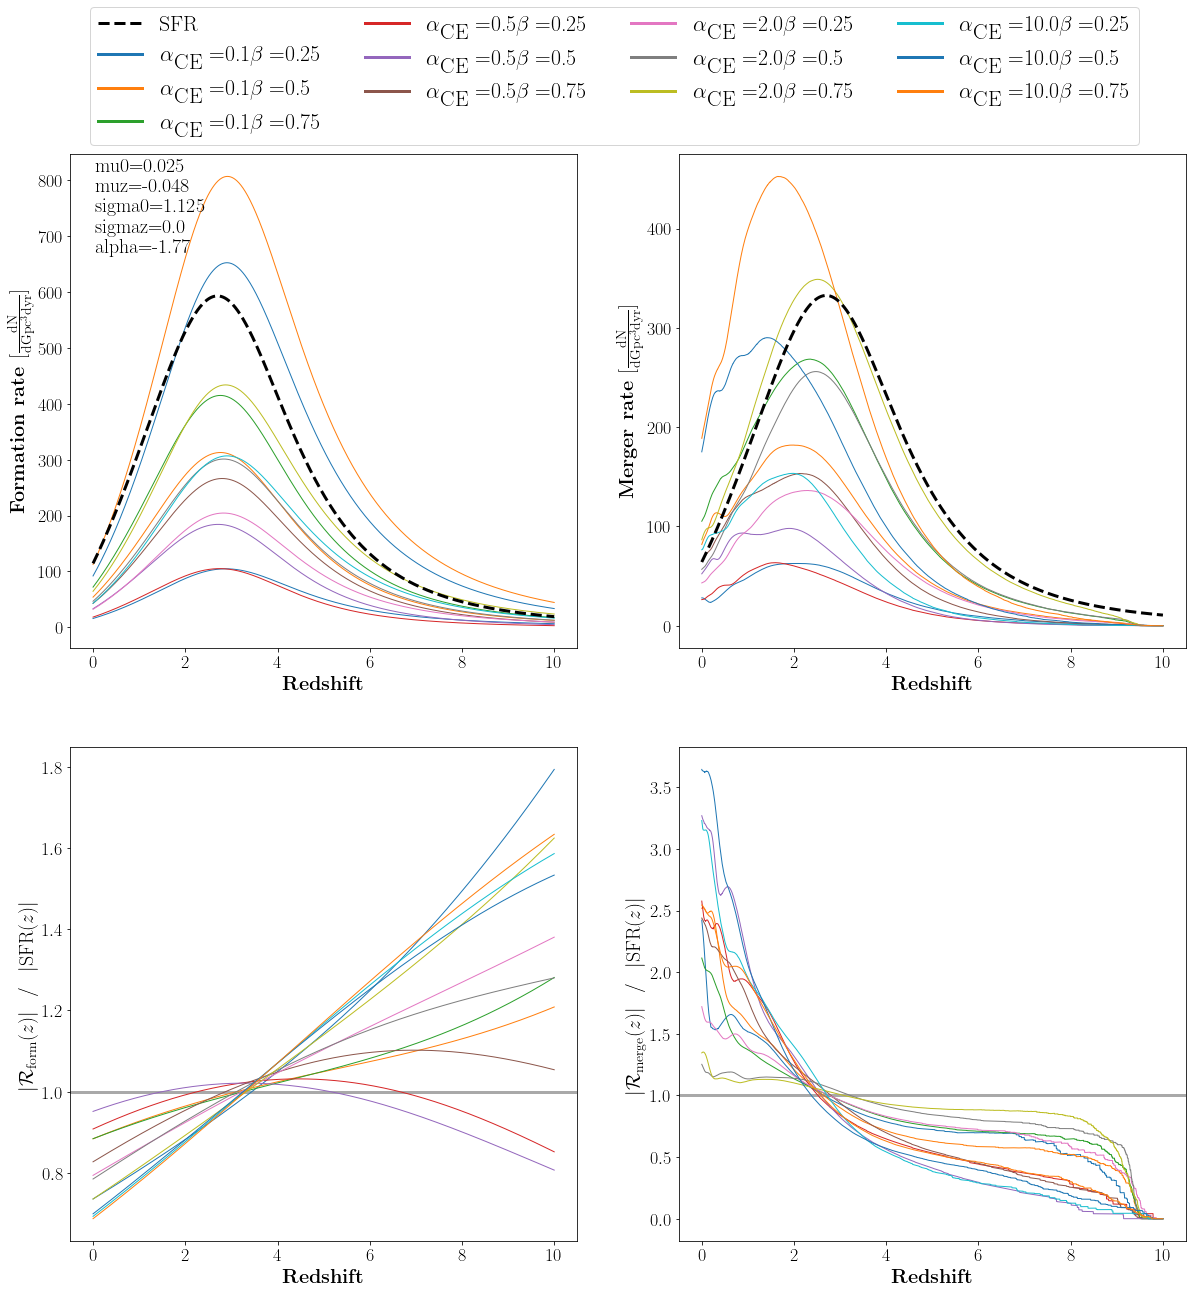

In [31]:
def plot_rates_sfr_norm(condensed_paths, alpha_vals, beta_vals, dco_type=None, merger_output_filename=None, weight_column=None,
    merges_hubble_time=True, pessimistic_CEE=True, no_RLOF_after_CEE=True,
    max_redshift=10.0, max_redshift_detection=1.0, redshift_step=0.001, z_first_SF = 10,
    use_sampled_mass_ranges=True, m1_min=5 * u.Msun, m1_max=150 * u.Msun, m2_min=0.1 * u.Msun, fbin=1.0,
    aSF = 0.01, bSF = 2.77, cSF = 2.90, dSF = 4.70,
    mu0=0.035, muz=-0.23, sigma0=0.39,sigmaz=0., alpha=0.0, 
    min_logZ=-12.0, max_logZ=1.0, step_logZ=0.01,
    sensitivity="O1", snr_threshold=8, 
    Mc_max=300.0, Mc_step=0.1, eta_max=0.25, eta_step=0.01,
    snr_max=1000.0, snr_step=0.1, lw=1):
    
    # Make sure the dco_type is given
    assert dco_type != None, 'dco_type must be given'

    # 2-D dictionaries for the data to be put in (axes correspond to alpha and beta values)
    total_formation_rates = {}
    total_merger_rates = {}
    total_detection_rates = {}
    cumulative_detection_rates = {}
    detection_rates_by_binary = {}
    chirp_masses = {}
    redshifts = {}

    for alpha_index, alpha_val in enumerate(alpha_vals):
        # Make the dictionary "2D"
        total_formation_rates[alpha_val] = {}
        total_merger_rates[alpha_val] = {}
        total_detection_rates[alpha_val] = {}
        cumulative_detection_rates[alpha_val] = {}
        detection_rates_by_binary[alpha_val] = {}
        chirp_masses[alpha_val] = {}

        redshifts[alpha_val] = {}

        for beta_index, beta_val in enumerate(beta_vals):
            detection_rates, formation_rates, merger_rates, redshifts[alpha_val][beta_val], COMPASs = \
            FCI.find_detection_rate(
            condensed_paths[alpha_val][beta_val], dco_type=dco_type, weight_column=weight_column,
            merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
            no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
            max_redshift_detection=max_redshift_detection,
            redshift_step=redshift_step, z_first_SF=z_first_SF,
            m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
            fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
            mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
            min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
            sensitivity=sensitivity, snr_threshold=snr_threshold,
            Mc_max=Mc_max, Mc_step=Mc_step,
            eta_max=eta_max, eta_step=eta_step,
            snr_max=snr_max, snr_step=snr_step, lognormal=True)

            chirp_masses[alpha_val][beta_val] = (COMPASs.mass1*COMPASs.mass2)**(3./5.) / (COMPASs.mass1 + COMPASs.mass2)**(1./5.)

            # sum things up across binaries
            total_formation_rates[alpha_val][beta_val] = np.sum(formation_rates, axis=0)
            total_merger_rates[alpha_val][beta_val] = np.sum(merger_rates, axis=0)
            total_detection_rates[alpha_val][beta_val] = np.sum(detection_rates, axis=0)

            # and across redshifts
            cumulative_detection_rates[alpha_val][beta_val] = np.cumsum(total_detection_rates[alpha_val][beta_val])
            detection_rates_by_binary[alpha_val][beta_val] = np.sum(detection_rates, axis=1)

            # empty trash
            del detection_rates
            del formation_rates
            del merger_rates
            del COMPASs



    ###########################
    #Start plotting

    # set some constants for the plots
    plt.rc('font', family='serif')
    fs = 20
    fig, axes = plt.subplots(2, 2, figsize=(20, 20))

    # Calculate and scare the SFR to plot on the formation and merger rate plots
    sfr_redshifts = redshifts['0.1']['0.5']
    sfr = FCI.find_sfr(sfr_redshifts, a = aSF, b = bSF, c = cSF, d = dSF)
    sfr_area = np.trapz(sfr, x=sfr_redshifts) # Get the area under the curve
    sfr_normalized = sfr/sfr_area # Make it so the area under the curve is 1

    for alpha_val in alpha_vals:
        for beta_val in beta_vals:
            axes[0,0].plot(redshifts[alpha_val][beta_val], (total_formation_rates[alpha_val][beta_val]), lw=lw)
            
            axes[0,1].plot(redshifts[alpha_val][beta_val], (total_merger_rates[alpha_val][beta_val]), lw=lw)

            formation_rate_area = np.trapz(total_formation_rates[alpha_val][beta_val], x=redshifts[alpha_val][beta_val])
            axes[1,0].plot(redshifts[alpha_val][beta_val], (total_formation_rates[alpha_val][beta_val] / formation_rate_area) / sfr_normalized, lw=lw)
            
            merger_rate_area = np.trapz(total_merger_rates[alpha_val][beta_val], x=redshifts[alpha_val][beta_val])
            axes[1,1].plot(redshifts[alpha_val][beta_val], (total_merger_rates[alpha_val][beta_val] / merger_rate_area) / sfr_normalized, lw=lw, label=r'$\alpha_{\textrm{CE}} = $' + alpha_val + r'$\beta = $' + beta_val)

    
    # Label axes of all the plots
    axes[0,0].set_xlabel(r'\textbf{Redshift}', fontsize=fs)
    axes[0,0].set_ylabel(r'\textbf{Formation rate $[\rm \frac{\mathrm{d}N}{\mathrm{d}Gpc^3 \mathrm{d}yr}]$}', fontsize=fs)

    axes[0,1].set_xlabel(r'\textbf{Redshift}', fontsize=fs)
    axes[0,1].set_ylabel(r'\textbf{Merger rate $[\rm \frac{\mathrm{d}N}{\mathrm{d}Gpc^3 \mathrm{d}yr}]$}', fontsize=fs)

    axes[1,0].set_xlabel(r'\textbf{Redshift}', fontsize=fs)
    axes[1,0].set_ylabel(r'\textbf{$|\mathcal{R}_{\rm{form}}(z)|  \ \  /  \ \  |\textrm{\textnormal{SFR}}(z)|$}', fontsize=fs)

    axes[1,1].set_xlabel(r'\textbf{Redshift}', fontsize=fs)
    axes[1,1].set_ylabel(r'\textbf{$|\mathcal{R}_{\rm{merge}}(z)|  \ \  /  \ \  |\textrm{\textnormal{SFR}}(z)|$}', fontsize=fs)
    
    # Scale SFR differently for each DCO type
    sfr = sfr/max(sfr)
    form_const, merger_const = axes[0,0].get_ylim()[1] * 0.7, axes[0,1].get_ylim()[1] * 0.7

    # Plot SFRs
    axes[0,0].plot(sfr_redshifts, sfr * form_const, color='black', lw=3, linestyle='dashed')
    axes[0,1].plot(sfr_redshifts, sfr * merger_const, color='black', lw=3, linestyle='dashed', label=r'SFR')

    # Plot horizontal line for SFR on the normalized plots
    axes[1,0].axhline(y=1, color='darkgray', lw=3, zorder=-1)
    axes[1,1].axhline(y=1, color='darkgray', lw=3, zorder=-1)

    # Add text upper left corner
    axes[0,0].text(0.05,0.8, 
            "mu0={} \nmuz={} \nsigma0={} \nsigmaz={} \nalpha={}".format(mu0,muz,sigma0,sigmaz,alpha), 
            transform=axes[0,0].transAxes, size = fs) 

    for ax in axes.flatten():
        ax.tick_params(labelsize=0.9*fs)

    # Include legend
    leg = fig.legend(fontsize=22, ncol=4, bbox_to_anchor=(0.875, .99),  markerscale=25) 
    for legobj in leg.legendHandles:
        legobj.set_linewidth(3.0)

    # Show the plot!
    plt.show()

plot_rates_sfr_norm(condensed_paths, alpha_vals, beta_vals, dco_type='BNS', weight_column=weight_column,
            merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
            no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
            max_redshift_detection=max_redshift_detection,
            redshift_step=redshift_step, z_first_SF=z_first_SF,
            m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
            fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
            mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
            min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
            sensitivity=sensitivity, snr_threshold=snr_threshold,
            Mc_max=Mc_max, Mc_step=Mc_step,
            eta_max=eta_max, eta_step=eta_step,
            snr_max=snr_max, snr_step=snr_step)

## b) BHNS

Average_SF_mass_needed =  79000358.64584705 solMass
Average_SF_mass_needed =  78917058.94123225 solMass
Average_SF_mass_needed =  79177167.82215944 solMass
Average_SF_mass_needed =  79293900.86958866 solMass
Average_SF_mass_needed =  79141072.46483316 solMass
Average_SF_mass_needed =  78939667.6720331 solMass
Average_SF_mass_needed =  78983789.34011732 solMass
Average_SF_mass_needed =  79103656.75270525 solMass
Average_SF_mass_needed =  78953875.63080673 solMass
Average_SF_mass_needed =  79459283.24465545 solMass
Average_SF_mass_needed =  79040304.63090822 solMass
Average_SF_mass_needed =  79076861.7919253 solMass


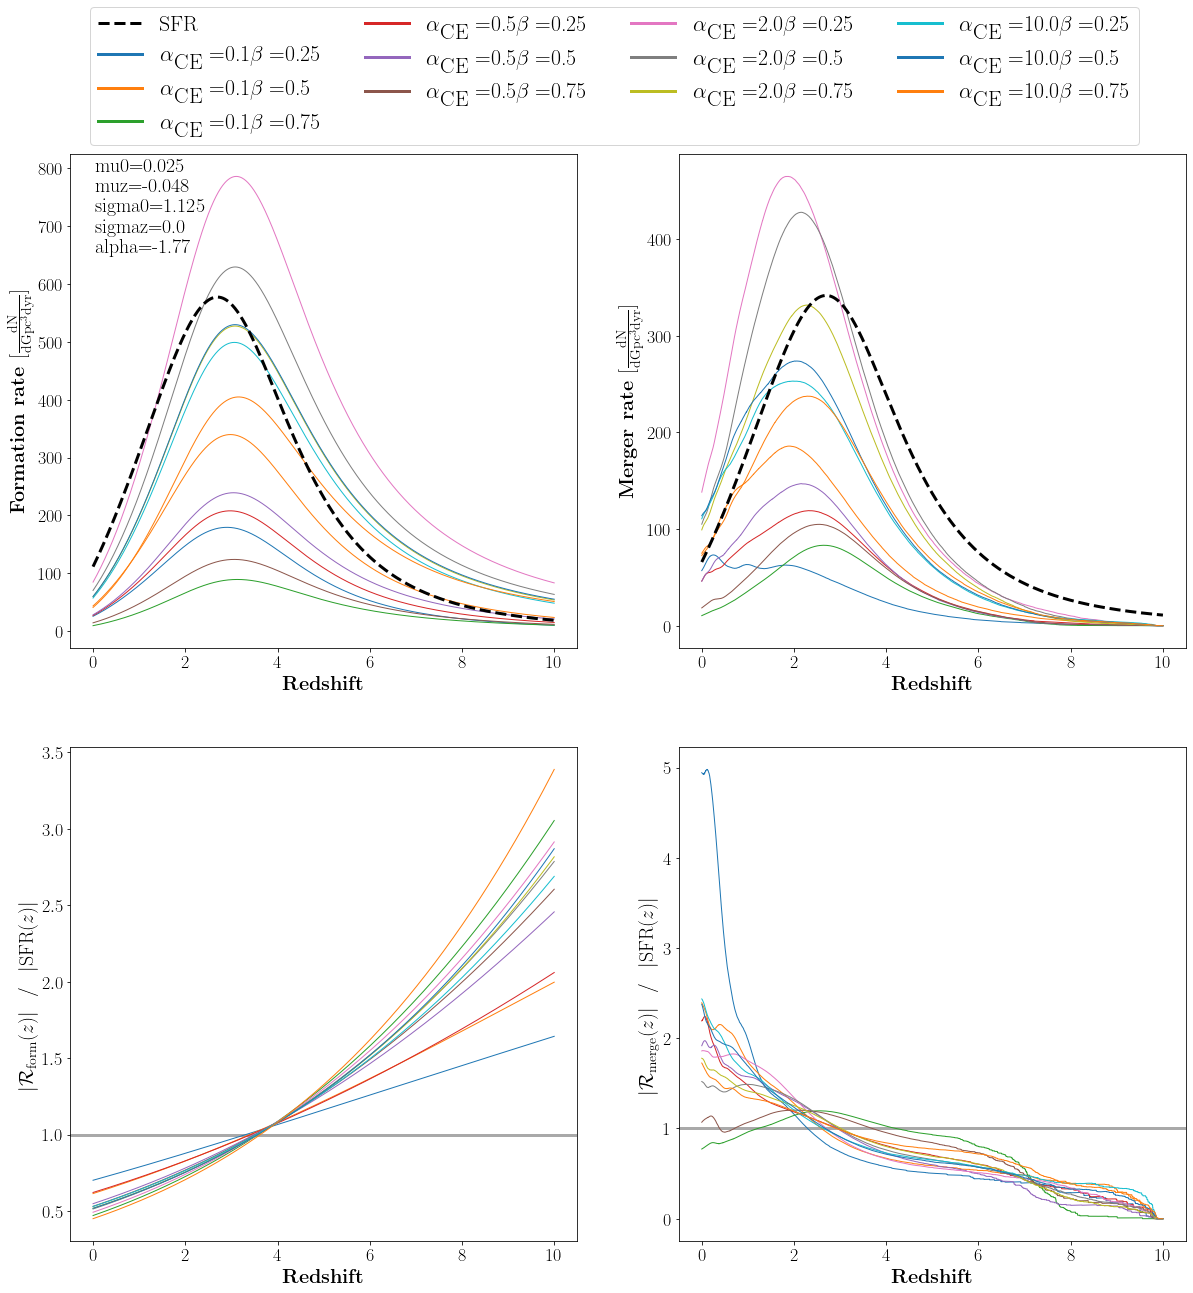

In [32]:
plot_rates_sfr_norm(condensed_paths, alpha_vals, beta_vals, dco_type='BHNS', weight_column=weight_column,
            merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
            no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
            max_redshift_detection=max_redshift_detection,
            redshift_step=redshift_step, z_first_SF=z_first_SF,
            m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
            fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
            mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
            min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
            sensitivity=sensitivity, snr_threshold=snr_threshold,
            Mc_max=Mc_max, Mc_step=Mc_step,
            eta_max=eta_max, eta_step=eta_step,
            snr_max=snr_max, snr_step=snr_step)

## c) BBH

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_21950/3577872649.py:37: UserWarning: Maximum chirp mass used for detectability calculation is below maximum binary chirp mass * (1+maximum redshift for detectability calculation)
  FCI.find_detection_rate(


Average_SF_mass_needed =  79158927.00937583 solMass
Average_SF_mass_needed =  79329727.98846708 solMass
Average_SF_mass_needed =  78912825.7610382 solMass
Average_SF_mass_needed =  78863394.85905518 solMass
Average_SF_mass_needed =  79102539.14563788 solMass
Average_SF_mass_needed =  78895123.45776023 solMass
Average_SF_mass_needed =  78921607.26022595 solMass
Average_SF_mass_needed =  79072140.5329414 solMass
Average_SF_mass_needed =  79248928.31830108 solMass
Average_SF_mass_needed =  79217458.99123356 solMass
Average_SF_mass_needed =  79086615.2581309 solMass
Average_SF_mass_needed =  79521435.14605623 solMass


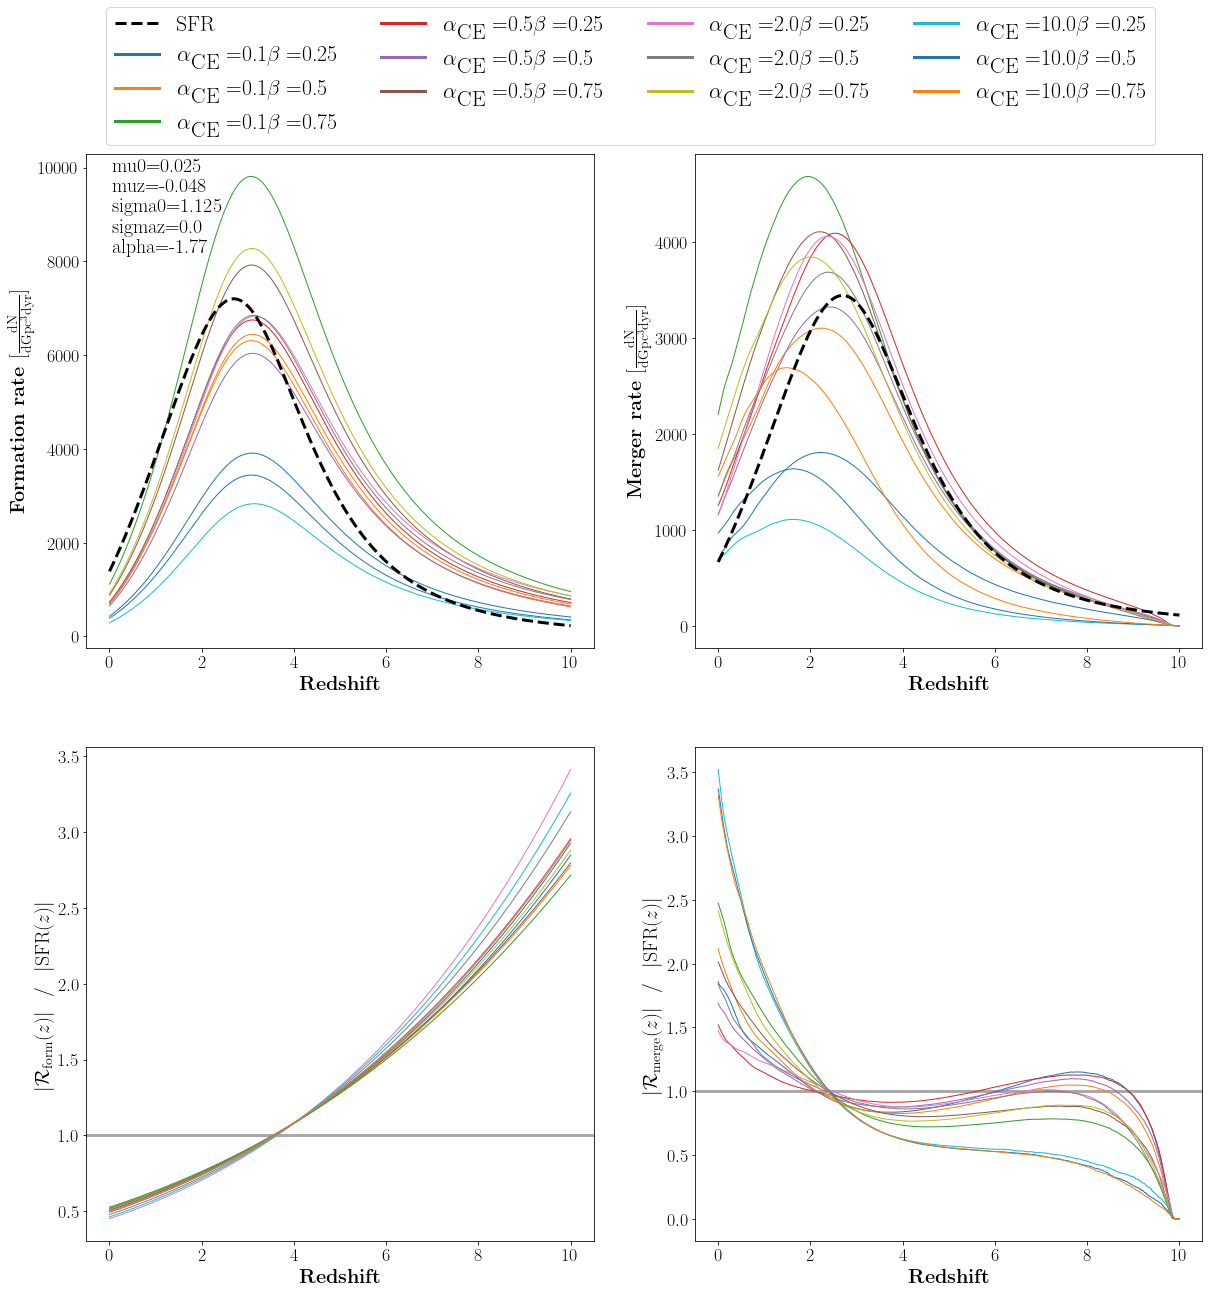

In [33]:
plot_rates_sfr_norm(condensed_paths, alpha_vals, beta_vals, dco_type='BBH', weight_column=weight_column,
            merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
            no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
            max_redshift_detection=max_redshift_detection,
            redshift_step=redshift_step, z_first_SF=z_first_SF,
            m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
            fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
            mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
            min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
            sensitivity=sensitivity, snr_threshold=snr_threshold,
            Mc_max=Mc_max, Mc_step=Mc_step,
            eta_max=eta_max, eta_step=eta_step,
            snr_max=snr_max, snr_step=snr_step)

# 9. Plot Rates Divided by SFR for the Different SFR Predictions

## a) BNS

ClassMSSFR: Remember to set self.SFRprescription() + subparts
                            self.Zprescription()   +sub-parts
Average_SF_mass_needed =  79233113.7760174 solMass
ClassMSSFR: Remember to set self.SFRprescription() + subparts
                            self.Zprescription()   +sub-parts
Average_SF_mass_needed =  79286239.0239895 solMass
ClassMSSFR: Remember to set self.SFRprescription() + subparts
                            self.Zprescription()   +sub-parts
Average_SF_mass_needed =  78927988.61856072 solMass
ClassMSSFR: Remember to set self.SFRprescription() + subparts
                            self.Zprescription()   +sub-parts
Average_SF_mass_needed =  79218039.54598917 solMass
ClassMSSFR: Remember to set self.SFRprescription() + subparts
                            self.Zprescription()   +sub-parts
Average_SF_mass_needed =  78851247.40395401 solMass
ClassMSSFR: Remember to set self.SFRprescription() + subparts
                            self.Zprescription()   +sub-part

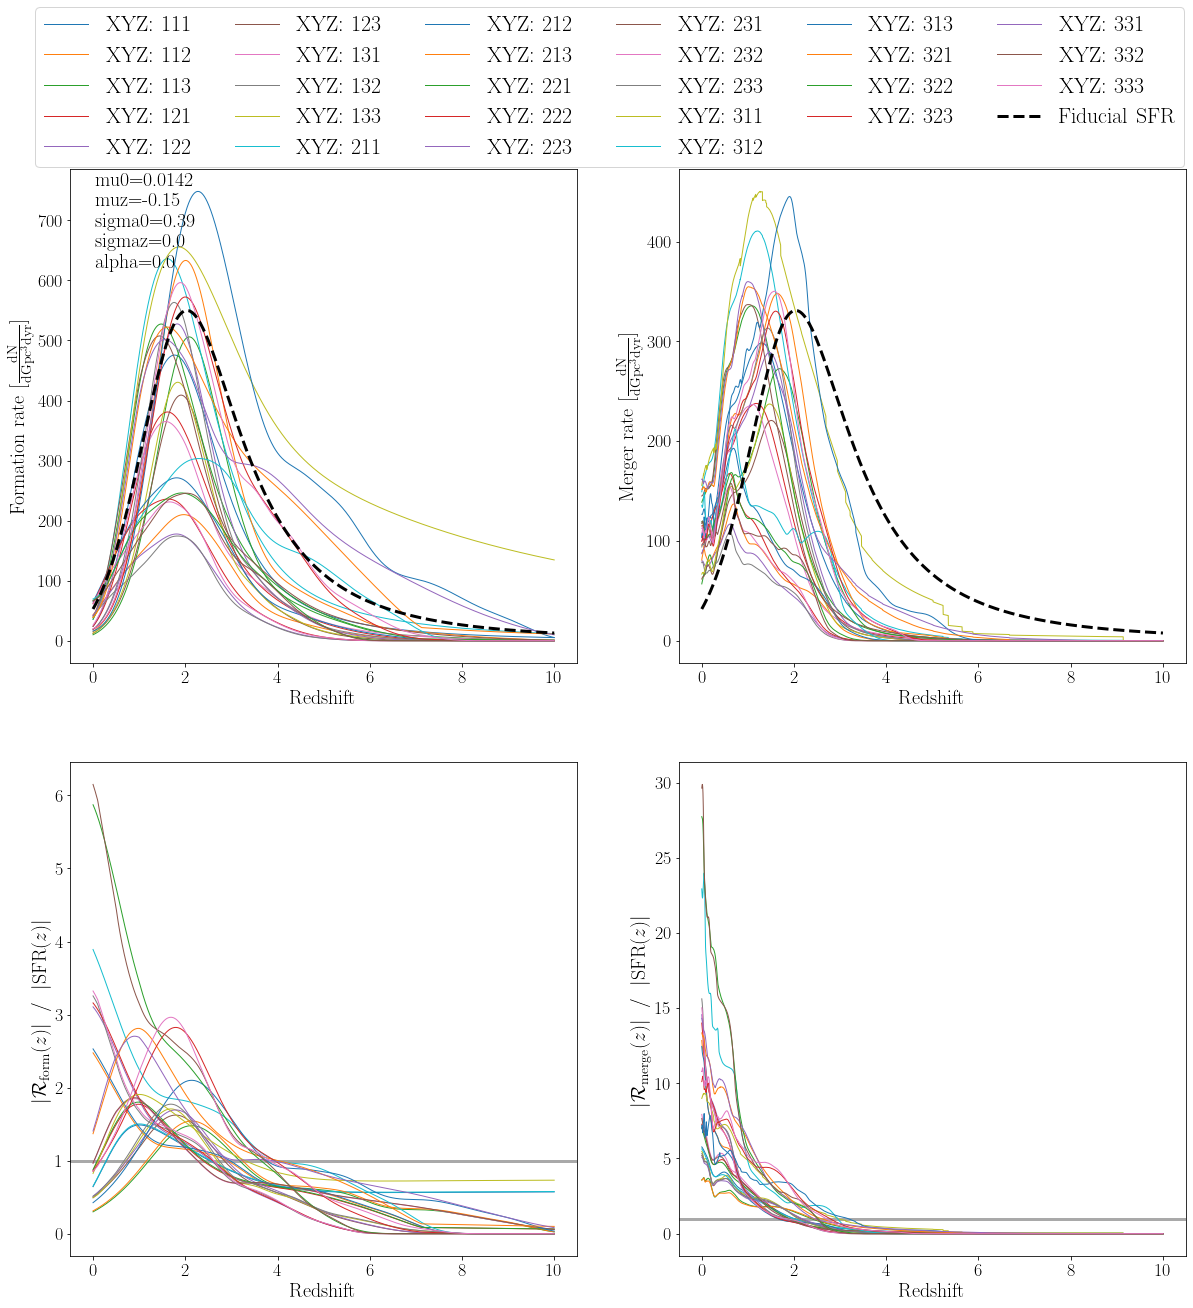

In [12]:
# SFRD, GSMF, and MZR prescriptions (this is in the format of the table that the paper will have)
SFRDs   = {1: 'Madau et al. (2017)',            2: 'Madau et al. (2014)',               3: 'Strolger et al. (2004)'}
GSMFs   = {1: 'Panter et al. (2004) Single',    2: 'Furlong et al. (2015) Single',      3: 'Furlong et al. (2015) Double'}
MZRs    = {1: 'Ma et al. (2016)',               2: 'Langer et al. (2006)',              3: 'Langer et al. +offset (2006)'}


def plot_rates_mssfr_sfr_norm(condensed_paths, alpha_val, beta_val, SFRDs, GSMFs, MZRs, dco_type=None, merger_output_filename=None, weight_column=None,
        merges_hubble_time=True, pessimistic_CEE=True, no_RLOF_after_CEE=True,
        max_redshift=10.0, max_redshift_detection=1.0, redshift_step=0.001, z_first_SF = 10,
        use_sampled_mass_ranges=True, m1_min=5 * u.Msun, m1_max=150 * u.Msun, m2_min=0.1 * u.Msun, fbin=1.0,
        aSF = 0.01, bSF = 2.77, cSF = 2.90, dSF = 4.70,
        mu0=0.035, muz=-0.23, sigma0=0.39,sigmaz=0., alpha=0.0, 
        min_logZ=-12.0, max_logZ=1.0, step_logZ=0.01,
        sensitivity="O1", snr_threshold=8, 
        Mc_max=300.0, Mc_step=0.1, eta_max=0.25, eta_step=0.01,
        snr_max=1000.0, snr_step=0.1, lw=1):
        
        assert dco_type != None, 'dco_type must be given'

        total_formation_rates = {}
        total_merger_rates = {}
        redshifts = {}
        
        for SFRD_num, SFRD_name in SFRDs.items():
                for GSMF_num, GSMF_name in GSMFs.items():
                        for MZR_num, MZR_name in MZRs.items():
                                
                                # The prescription, labeled by a list representing (X, Y, Z)
                                S_prescription = (SFRD_num, GSMF_num, MZR_num)

                                # Calculate!
                                _, formation_rates, merger_rates, redshifts[S_prescription], _ = \
                                FCI.find_detection_rate(
                                condensed_paths[alpha_val][beta_val], dco_type=dco_type, weight_column=weight_column,
                                lognormal=False, Zprescription='MZ_GSMF', SFRprescription=SFRD_name, GSMFprescription=GSMF_name, 
                                ZMprescription=MZR_name, logNormalPrescription=None,
                                merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
                                no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
                                max_redshift_detection=max_redshift_detection,
                                redshift_step=redshift_step, z_first_SF=z_first_SF,
                                m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
                                fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
                                mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
                                min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
                                sensitivity=sensitivity, snr_threshold=snr_threshold,
                                Mc_max=Mc_max, Mc_step=Mc_step,
                                eta_max=eta_max, eta_step=eta_step,
                                snr_max=snr_max, snr_step=snr_step)

                                # sum things up across binaries
                                total_formation_rates[S_prescription] = np.sum(formation_rates, axis=0)
                                total_merger_rates[S_prescription] = np.sum(merger_rates, axis=0)

                                # empty trash
                                del formation_rates
                                del merger_rates

        ###########################
        #Start plotting

        # set some constants for the plots
        plt.rc('font', family='serif')
        fs = 20
        fig, axes = plt.subplots(2, 2, figsize=(20, 20))

        for SFRD_num, SFRD_name in SFRDs.items():
                for GSMF_num, GSMF_name in GSMFs.items():
                        for MZR_num, MZR_name in MZRs.items():

                                # The prescription for the current iteration
                                S_prescription = (SFRD_num, GSMF_num, MZR_num)

                                # Create an MSSFR object
                                MSSFR = ClassMSSFR.MSSFR()
                                MSSFR.SFRprescription = SFRD_name

                                # Get the ages
                                ages = MSSFR.cosmology.age(redshifts[S_prescription]).value

                                # Get the SFR
                                sfr = MSSFR.returnSFR(redshifts[S_prescription], ages)
                                
                                # Normalize the SFR
                                sfr_area = np.trapz(sfr, x=redshifts[S_prescription]) # Get the area under the curve
                                sfr_normalized = sfr/sfr_area # Get area under the curve equal to 1

                                # Plot rates
                                axes[0,0].plot(redshifts[S_prescription], (total_formation_rates[S_prescription]), lw=lw)
            
                                axes[0,1].plot(redshifts[S_prescription], (total_merger_rates[S_prescription]), lw=lw, label='XYZ: ' + str(SFRD_num) + str(GSMF_num) + str(MZR_num))

                                # Plot normalized rates!
                                formation_rate_area = np.trapz(total_formation_rates[S_prescription], x=redshifts[S_prescription])
                                axes[1,0].plot(redshifts[S_prescription], (total_formation_rates[S_prescription]/formation_rate_area)/sfr_normalized, lw=lw) 
                                
                                merger_rate_area = np.trapz(total_merger_rates[S_prescription], x=redshifts[S_prescription])
                                axes[1,1].plot(redshifts[S_prescription], (total_merger_rates[S_prescription]/merger_rate_area)/sfr_normalized, lw=lw)


        # Label axes of all the plots
        axes[0,0].set_xlabel('Redshift', fontsize=fs)
        axes[0,0].set_ylabel(r'Formation rate $[\rm \frac{\mathrm{d}N}{\mathrm{d}Gpc^3 \mathrm{d}yr}]$', fontsize=fs)

        axes[0,1].set_xlabel('Redshift', fontsize=fs)
        axes[0,1].set_ylabel(r'Merger rate $[\rm \frac{\mathrm{d}N}{\mathrm{d}Gpc^3 \mathrm{d}yr}]$', fontsize=fs)

        axes[1,0].set_xlabel('Redshift', fontsize=fs)
        axes[1,0].set_ylabel(r'$|\mathcal{R}_{\rm{form}}(z)|  \ \  /  \ \  |\textrm{SFR}(z)|$', fontsize=fs)

        axes[1,1].set_xlabel('Redshift', fontsize=fs)
        axes[1,1].set_ylabel(r'$|\mathcal{R}_{\rm{merge}}(z)|  \ \  /  \ \  |\textrm{SFR}(z)|$', fontsize=fs)


        # Plot horizontal line for SFR on the normalized plots
        axes[1,0].axhline(y=1, color='darkgray', lw=3, zorder=-1)
        axes[1,1].axhline(y=1, color='darkgray', lw=3, zorder=-1)
        
        # Get the fiducial SFR
        MSSFR = ClassMSSFR.MSSFR()
        MSSFR.SFRprescription = 'Madau et al. (2017)'

        # Get the ages
        sfr_redshifts = redshifts[(1,1,1)]
        ages = MSSFR.cosmology.age(sfr_redshifts).value

        # Get the SFR
        sfr = MSSFR.returnSFR(sfr_redshifts, ages)

        # Scale SFR differently for each DCO type
        sfr = sfr/max(sfr)
        form_const, merger_const = axes[0,0].get_ylim()[1] * 0.7, axes[0,1].get_ylim()[1] * 0.7

        # Plot SFRs
        axes[0,0].plot(sfr_redshifts, sfr * form_const, color='black', lw=3, linestyle='dashed')
        axes[0,1].plot(sfr_redshifts, sfr * merger_const, color='black', lw=3, linestyle='dashed', label=r'Fiducial SFR')

        # Add text upper left corner
        axes[0,0].text(0.05,0.8, 
        "mu0={} \nmuz={} \nsigma0={} \nsigmaz={} \nalpha={}".format(mu0,muz,sigma0,sigmaz,alpha), 
        transform=axes[0,0].transAxes, size = fs) 

        for ax in axes.flatten():
                ax.tick_params(labelsize=0.9*fs)

        # Include legend
        fig.legend(fontsize=22, ncol=6, bbox_to_anchor=(0.5, 1.0), loc='upper center',  markerscale=25) 

        # Show the plot!
        plt.show()


plot_rates_mssfr_sfr_norm(condensed_paths, '0.5', '0.5', SFRDs, GSMFs, MZRs, dco_type='BNS', weight_column=weight_column,
            merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
            no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
            max_redshift_detection=max_redshift_detection,
            redshift_step=redshift_step, z_first_SF=z_first_SF,
            m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
            fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
            mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
            min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
            sensitivity=sensitivity, snr_threshold=snr_threshold,
            Mc_max=Mc_max, Mc_step=Mc_step,
            eta_max=eta_max, eta_step=eta_step,
            snr_max=snr_max, snr_step=snr_step)

## b) BHNS

ClassMSSFR: Remember to set self.SFRprescription() + subparts
                            self.Zprescription()   +sub-parts
Average_SF_mass_needed =  79182923.00337641 solMass
ClassMSSFR: Remember to set self.SFRprescription() + subparts
                            self.Zprescription()   +sub-parts
Average_SF_mass_needed =  79427882.87065217 solMass
ClassMSSFR: Remember to set self.SFRprescription() + subparts
                            self.Zprescription()   +sub-parts
Average_SF_mass_needed =  79225436.11637686 solMass
ClassMSSFR: Remember to set self.SFRprescription() + subparts
                            self.Zprescription()   +sub-parts
Average_SF_mass_needed =  79290693.96920398 solMass
ClassMSSFR: Remember to set self.SFRprescription() + subparts
                            self.Zprescription()   +sub-parts
Average_SF_mass_needed =  79138647.6407966 solMass
ClassMSSFR: Remember to set self.SFRprescription() + subparts
                            self.Zprescription()   +sub-par

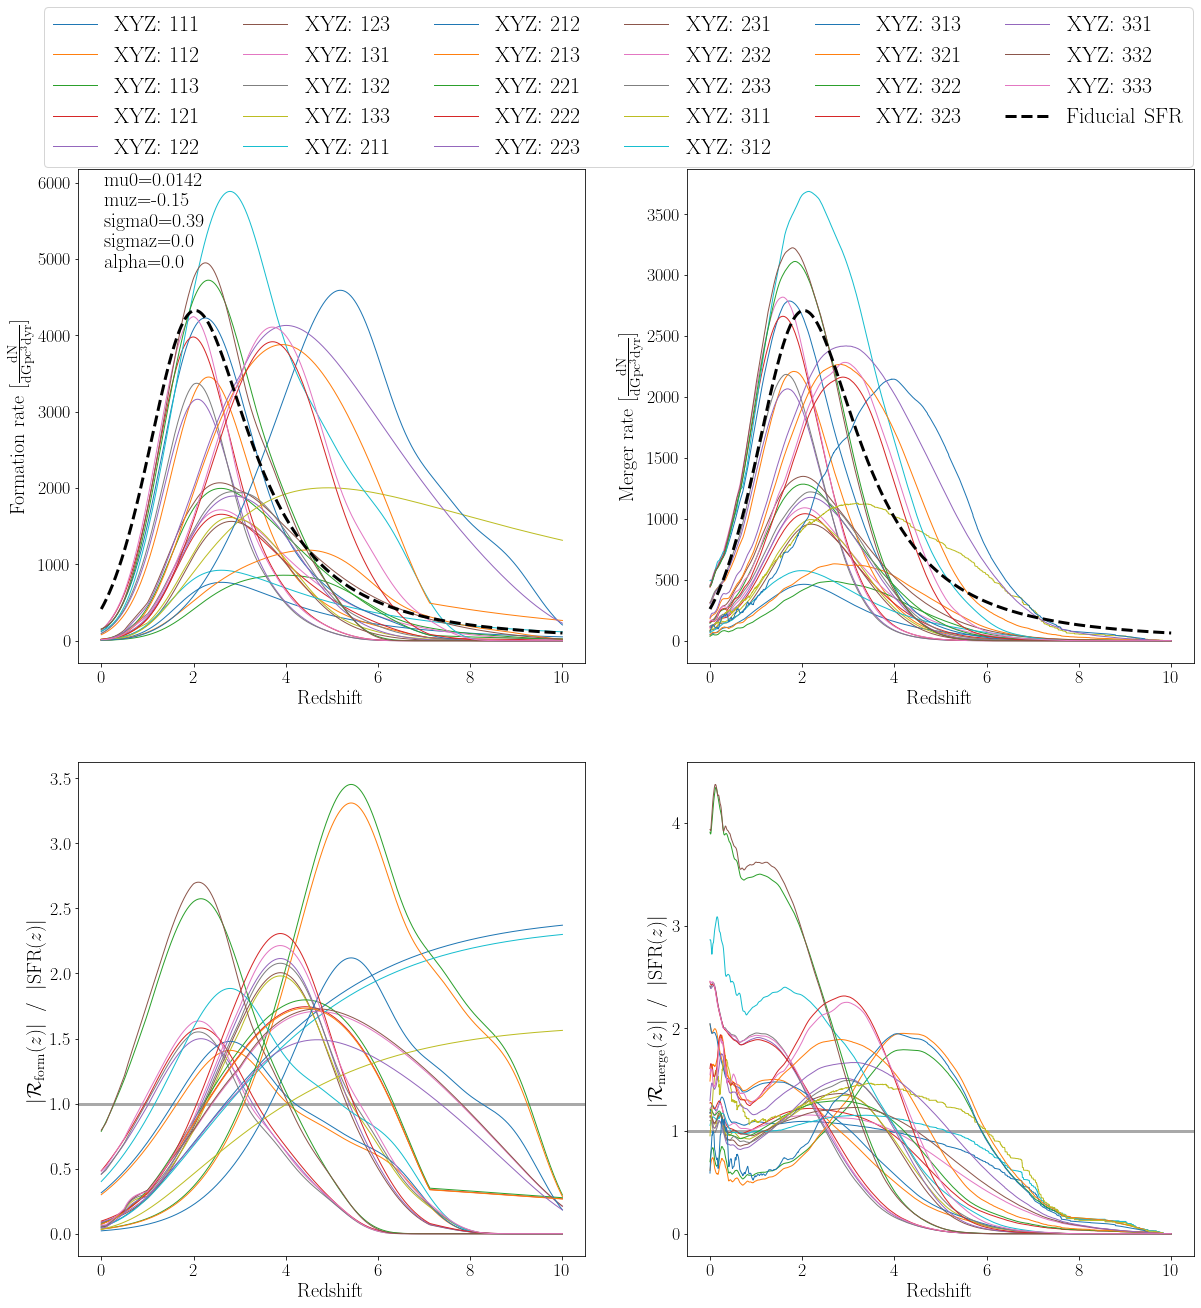

In [13]:
plot_rates_mssfr_sfr_norm(condensed_paths, '0.5', '0.5', SFRDs, GSMFs, MZRs, dco_type='BHNS', weight_column=weight_column,
            merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
            no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
            max_redshift_detection=max_redshift_detection,
            redshift_step=redshift_step, z_first_SF=z_first_SF,
            m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
            fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
            mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
            min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
            sensitivity=sensitivity, snr_threshold=snr_threshold,
            Mc_max=Mc_max, Mc_step=Mc_step,
            eta_max=eta_max, eta_step=eta_step,
            snr_max=snr_max, snr_step=snr_step)

## c) BBH

In [14]:
plot_rates_mssfr_sfr_norm(condensed_paths, '0.5', '0.5', SFRDs, GSMFs, MZRs, dco_type='BBH', weight_column=weight_column,
            merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
            no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
            max_redshift_detection=max_redshift_detection,
            redshift_step=redshift_step, z_first_SF=z_first_SF,
            m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
            fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
            mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
            min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
            sensitivity=sensitivity, snr_threshold=snr_threshold,
            Mc_max=Mc_max, Mc_step=Mc_step,
            eta_max=eta_max, eta_step=eta_step,
            snr_max=snr_max, snr_step=snr_step)

ClassMSSFR: Remember to set self.SFRprescription() + subparts
                            self.Zprescription()   +sub-parts
Average_SF_mass_needed =  78841295.13650829 solMass
ClassMSSFR: Remember to set self.SFRprescription() + subparts
                            self.Zprescription()   +sub-parts
Average_SF_mass_needed =  79366524.18513069 solMass
ClassMSSFR: Remember to set self.SFRprescription() + subparts
                            self.Zprescription()   +sub-parts
Average_SF_mass_needed =  79148619.22185649 solMass
ClassMSSFR: Remember to set self.SFRprescription() + subparts
                            self.Zprescription()   +sub-parts


KeyboardInterrupt: 

# 10. Plot percent error with SFR $\frac{|  \ \  (|\mathcal{R}_{\rm{form}}(z)|  \ \  -  \ \  |\textrm{SFR}(z)|)  \ \  |}{|\textrm{SFR}(z)|}$

## a) BNS

Average_SF_mass_needed =  79287489.6942224 solMass
Average_SF_mass_needed =  79052093.62013185 solMass
Average_SF_mass_needed =  79209544.46659541 solMass
Average_SF_mass_needed =  79152650.02751945 solMass
Average_SF_mass_needed =  79081918.51252945 solMass
Average_SF_mass_needed =  79227698.76340708 solMass
Average_SF_mass_needed =  78955160.01191175 solMass
Average_SF_mass_needed =  79085007.0305034 solMass
Average_SF_mass_needed =  79155498.61799411 solMass
Average_SF_mass_needed =  79086026.00248937 solMass
Average_SF_mass_needed =  79300859.27328879 solMass
Average_SF_mass_needed =  79217251.87623553 solMass


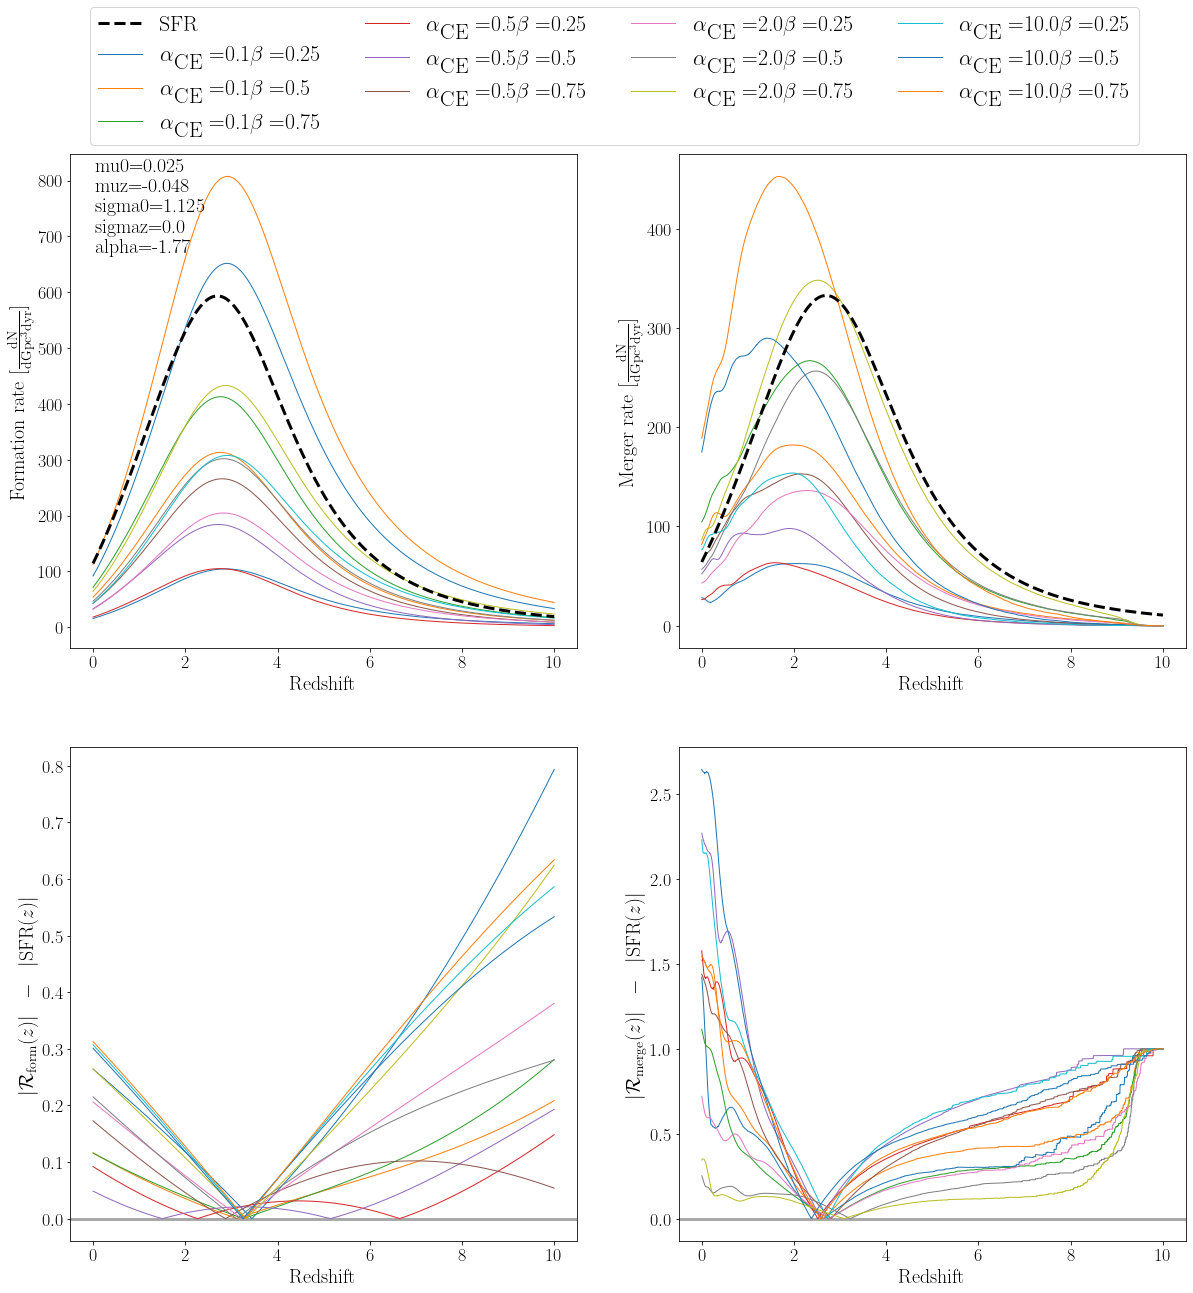

In [37]:
def plot_rates_residual(condensed_paths, alpha_vals, beta_vals, dco_type=None, merger_output_filename=None, weight_column=None,
    merges_hubble_time=True, pessimistic_CEE=True, no_RLOF_after_CEE=True,
    max_redshift=10.0, max_redshift_detection=1.0, redshift_step=0.001, z_first_SF = 10,
    use_sampled_mass_ranges=True, m1_min=5 * u.Msun, m1_max=150 * u.Msun, m2_min=0.1 * u.Msun, fbin=1.0,
    aSF = 0.01, bSF = 2.77, cSF = 2.90, dSF = 4.70,
    mu0=0.035, muz=-0.23, sigma0=0.39,sigmaz=0., alpha=0.0, 
    min_logZ=-12.0, max_logZ=1.0, step_logZ=0.01,
    sensitivity="O1", snr_threshold=8, 
    Mc_max=300.0, Mc_step=0.1, eta_max=0.25, eta_step=0.01,
    snr_max=1000.0, snr_step=0.1, lw=1):
    
    # Make sure the dco_type is given
    assert dco_type != None, 'dco_type must be given'

    # 2-D dictionaries for the data to be put in (axes correspond to alpha and beta values)
    total_formation_rates = {}
    total_merger_rates = {}
    total_detection_rates = {}
    cumulative_detection_rates = {}
    detection_rates_by_binary = {}
    chirp_masses = {}
    redshifts = {}

    for alpha_index, alpha_val in enumerate(alpha_vals):
        # Make the dictionary "2D"
        total_formation_rates[alpha_val] = {}
        total_merger_rates[alpha_val] = {}
        total_detection_rates[alpha_val] = {}
        cumulative_detection_rates[alpha_val] = {}
        detection_rates_by_binary[alpha_val] = {}
        chirp_masses[alpha_val] = {}

        redshifts[alpha_val] = {}

        for beta_index, beta_val in enumerate(beta_vals):
            detection_rates, formation_rates, merger_rates, redshifts[alpha_val][beta_val], COMPASs = \
            FCI.find_detection_rate(
            condensed_paths[alpha_val][beta_val], dco_type=dco_type, weight_column=weight_column,
            merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
            no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
            max_redshift_detection=max_redshift_detection,
            redshift_step=redshift_step, z_first_SF=z_first_SF,
            m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
            fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
            mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
            min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
            sensitivity=sensitivity, snr_threshold=snr_threshold,
            Mc_max=Mc_max, Mc_step=Mc_step,
            eta_max=eta_max, eta_step=eta_step,
            snr_max=snr_max, snr_step=snr_step, lognormal=True)

            chirp_masses[alpha_val][beta_val] = (COMPASs.mass1*COMPASs.mass2)**(3./5.) / (COMPASs.mass1 + COMPASs.mass2)**(1./5.)

            # sum things up across binaries
            total_formation_rates[alpha_val][beta_val] = np.sum(formation_rates, axis=0)
            total_merger_rates[alpha_val][beta_val] = np.sum(merger_rates, axis=0)
            total_detection_rates[alpha_val][beta_val] = np.sum(detection_rates, axis=0)

            # and across redshifts
            cumulative_detection_rates[alpha_val][beta_val] = np.cumsum(total_detection_rates[alpha_val][beta_val])
            detection_rates_by_binary[alpha_val][beta_val] = np.sum(detection_rates, axis=1)

            # empty trash
            del detection_rates
            del formation_rates
            del merger_rates
            del COMPASs



    ###########################
    #Start plotting

    # set some constants for the plots
    plt.rc('font', family='serif')
    fs = 20
    fig, axes = plt.subplots(2, 2, figsize=(20, 20))

    # Calculate and scare the SFR to plot on the formation and merger rate plots
    sfr_redshifts = redshifts['0.1']['0.5']
    sfr = FCI.find_sfr(sfr_redshifts, a = aSF, b = bSF, c = cSF, d = dSF)
    sfr_area = np.trapz(sfr, x=sfr_redshifts) # Get the area under the curve
    sfr_normalized = sfr/sfr_area # Make it so the area under the curve is 1

    for alpha_val in alpha_vals:
        for beta_val in beta_vals:
            axes[0,0].plot(redshifts[alpha_val][beta_val], (total_formation_rates[alpha_val][beta_val]), lw=lw)
            
            axes[0,1].plot(redshifts[alpha_val][beta_val], (total_merger_rates[alpha_val][beta_val]), lw=lw)

            formation_rate_area = np.trapz(total_formation_rates[alpha_val][beta_val], x=redshifts[alpha_val][beta_val])
            formation_rate_normalized = total_formation_rates[alpha_val][beta_val] / formation_rate_area
            axes[1,0].plot(redshifts[alpha_val][beta_val], ((formation_rate_normalized - sfr_normalized)**2)**0.5 / sfr_normalized, lw=lw)
            
            merger_rate_area = np.trapz(total_merger_rates[alpha_val][beta_val], x=redshifts[alpha_val][beta_val])
            merger_rate_normalized = total_merger_rates[alpha_val][beta_val] / merger_rate_area
            axes[1,1].plot(redshifts[alpha_val][beta_val], ((merger_rate_normalized - sfr_normalized)**2)**0.5 / sfr_normalized, lw=lw, label=r'$\alpha_{\textrm{CE}} = $' + alpha_val + r'$\beta = $' + beta_val)

    
    # Label axes of all the plots
    axes[0,0].set_xlabel('Redshift', fontsize=fs)
    axes[0,0].set_ylabel(r'Formation rate $[\rm \frac{\mathrm{d}N}{\mathrm{d}Gpc^3 \mathrm{d}yr}]$', fontsize=fs)

    axes[0,1].set_xlabel('Redshift', fontsize=fs)
    axes[0,1].set_ylabel(r'Merger rate $[\rm \frac{\mathrm{d}N}{\mathrm{d}Gpc^3 \mathrm{d}yr}]$', fontsize=fs)

    axes[1,0].set_xlabel('Redshift', fontsize=fs)
    axes[1,0].set_ylabel(r'$|\mathcal{R}_{\rm{form}}(z)|  \ \  -  \ \  |\textrm{SFR}(z)|$', fontsize=fs)

    axes[1,1].set_xlabel('Redshift', fontsize=fs)
    axes[1,1].set_ylabel(r'$|\mathcal{R}_{\rm{merge}}(z)|  \ \  -  \ \  |\textrm{SFR}(z)|$', fontsize=fs)
    
    # Scale SFR differently for each DCO type
    sfr = sfr/max(sfr)
    form_const, merger_const = axes[0,0].get_ylim()[1] * 0.7, axes[0,1].get_ylim()[1] * 0.7

    # Plot SFRs
    axes[0,0].plot(sfr_redshifts, sfr * form_const, color='black', lw=3, linestyle='dashed')
    axes[0,1].plot(sfr_redshifts, sfr * merger_const, color='black', lw=3, linestyle='dashed', label=r'SFR')

    # Plot horizontal line for SFR on the normalized plots
    axes[1,0].axhline(y=0, color='darkgray', lw=3, zorder=-1)
    axes[1,1].axhline(y=0, color='darkgray', lw=3, zorder=-1)

    # Add text upper left corner
    axes[0,0].text(0.05,0.8, 
            "mu0={} \nmuz={} \nsigma0={} \nsigmaz={} \nalpha={}".format(mu0,muz,sigma0,sigmaz,alpha), 
            transform=axes[0,0].transAxes, size = fs) 

    for ax in axes.flatten():
        ax.tick_params(labelsize=0.9*fs)

    # Include legend
    fig.legend(fontsize=22, ncol=4, bbox_to_anchor=(0.875, .99),  markerscale=25) 

    # Show the plot!
    plt.show()

plot_rates_residual(condensed_paths, alpha_vals, beta_vals, dco_type='BNS', weight_column=weight_column,
            merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
            no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
            max_redshift_detection=max_redshift_detection,
            redshift_step=redshift_step, z_first_SF=z_first_SF,
            m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
            fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
            mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
            min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
            sensitivity=sensitivity, snr_threshold=snr_threshold,
            Mc_max=Mc_max, Mc_step=Mc_step,
            eta_max=eta_max, eta_step=eta_step,
            snr_max=snr_max, snr_step=snr_step)

## b) BHNS

In [34]:
plot_rates_residual(condensed_paths, alpha_vals, beta_vals, dco_type='BHNS', weight_column=weight_column,
            merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
            no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
            max_redshift_detection=max_redshift_detection,
            redshift_step=redshift_step, z_first_SF=z_first_SF,
            m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
            fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
            mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
            min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
            sensitivity=sensitivity, snr_threshold=snr_threshold,
            Mc_max=Mc_max, Mc_step=Mc_step,
            eta_max=eta_max, eta_step=eta_step,
            snr_max=snr_max, snr_step=snr_step)

Average_SF_mass_needed =  79235596.09430046 solMass
Average_SF_mass_needed =  79149695.50811261 solMass
Average_SF_mass_needed =  79148499.11428167 solMass
Average_SF_mass_needed =  79161515.35738526 solMass
Average_SF_mass_needed =  79389978.89556125 solMass


KeyboardInterrupt: 

## c) BBH

In [ ]:
plot_rates_residual(condensed_paths, alpha_vals, beta_vals, dco_type='BBH', weight_column=weight_column,
            merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
            no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
            max_redshift_detection=max_redshift_detection,
            redshift_step=redshift_step, z_first_SF=z_first_SF,
            m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
            fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
            mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
            min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
            sensitivity=sensitivity, snr_threshold=snr_threshold,
            Mc_max=Mc_max, Mc_step=Mc_step,
            eta_max=eta_max, eta_step=eta_step,
            snr_max=snr_max, snr_step=snr_step)

# 11. $\chi^2$ between SFR and formation/merger rates

In [41]:
def get_chi2(observed, expected):
    """
        This function gets the chi squared value for two given functions. The functions must be of the same length and their independent variable
        values should be the same for each index of both of the given functions.

        ...

        Parameters
        ----------
        observed : np.array()
            the observed y-values

        expected : np.array()
            the expected

        Returns
        ----------
        float
            the chi squared value between the two functions

    """
    
    return np.sum((observed - expected)**2 / expected)

## a) BNS

Average_SF_mass_needed =  78990950.24109952 solMass
Average_SF_mass_needed =  78850715.49823515 solMass
Average_SF_mass_needed =  78721937.49411231 solMass
Average_SF_mass_needed =  78972546.66926883 solMass
Average_SF_mass_needed =  78839095.80246821 solMass
Average_SF_mass_needed =  79097498.18743946 solMass
Average_SF_mass_needed =  78911757.32350142 solMass
Average_SF_mass_needed =  78830250.92174926 solMass
Average_SF_mass_needed =  79221201.49337083 solMass
Average_SF_mass_needed =  79024432.9670421 solMass
Average_SF_mass_needed =  79125686.03114222 solMass
Average_SF_mass_needed =  79024642.47988637 solMass


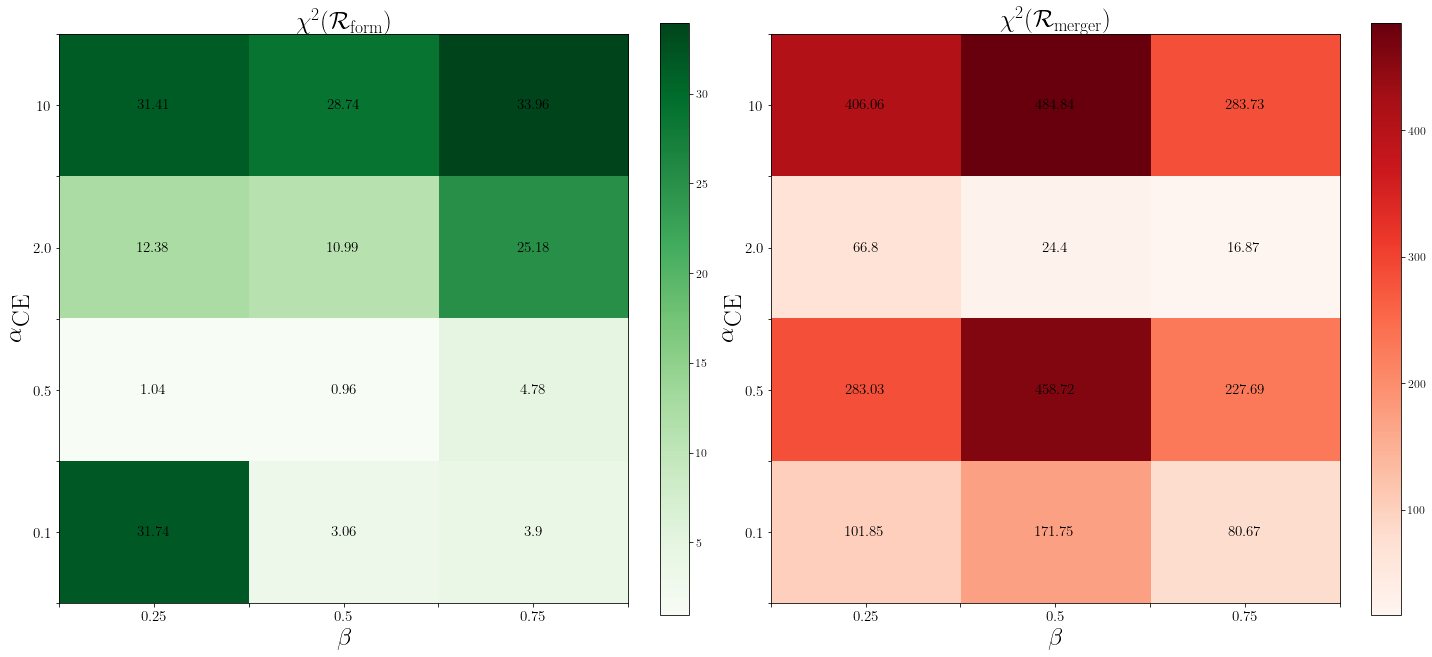

In [89]:
def plot_rates_chi2(condensed_paths, alpha_vals, beta_vals, dco_type=None, merger_output_filename=None, weight_column=None,
    merges_hubble_time=True, pessimistic_CEE=True, no_RLOF_after_CEE=True,
    max_redshift=10.0, max_redshift_detection=1.0, redshift_step=0.001, z_first_SF = 10,
    use_sampled_mass_ranges=True, m1_min=5 * u.Msun, m1_max=150 * u.Msun, m2_min=0.1 * u.Msun, fbin=1.0,
    aSF = 0.01, bSF = 2.77, cSF = 2.90, dSF = 4.70,
    mu0=0.035, muz=-0.23, sigma0=0.39,sigmaz=0., alpha=0.0, 
    min_logZ=-12.0, max_logZ=1.0, step_logZ=0.01,
    sensitivity="O1", snr_threshold=8, 
    Mc_max=300.0, Mc_step=0.1, eta_max=0.25, eta_step=0.01,
    snr_max=1000.0, snr_step=0.1, lw=1):
    """
        This function plots two heatmaps corresponding to the chi squared values of the merger and formation rate over a given
        list of alphaCE and beta values.

        ...

        Parameters
        ----------
        condensed_paths : dict
            a two-dimensional dictionary containing the path to the paths to each h5 file

        data : dict
            a two-dimensional dictionary containing the COMPAS objects for each of the corresponding condensed_paths files

        alpha_vals : list
            the values of the alpha_CE parameter of the COMPAS runs

        beta_vals : list
            the values of the alpha_CE parameter of the COMPAS runs

        dco_type : str
            the type of DCO that we will be plots ('BBH', 'BNS', or 'BHNS')

        NOTE: The rest of the parameters either define the universe for our calculations, or are for formatting purposes.

        """



    # Make sure the dco_type is given
    assert dco_type != None, 'dco_type must be given'

    # 2-D dictionaries for the data to be put in (axes correspond to alpha and beta values)
    total_formation_rates = {}
    total_merger_rates = {}
    total_detection_rates = {}
    cumulative_detection_rates = {}
    detection_rates_by_binary = {}
    chirp_masses = {}
    redshifts = {}

    for alpha_index, alpha_val in enumerate(alpha_vals):
        # Make the dictionary "2D"
        total_formation_rates[alpha_val] = {}
        total_merger_rates[alpha_val] = {}
        total_detection_rates[alpha_val] = {}
        cumulative_detection_rates[alpha_val] = {}
        detection_rates_by_binary[alpha_val] = {}
        chirp_masses[alpha_val] = {}

        redshifts[alpha_val] = {}

        for beta_index, beta_val in enumerate(beta_vals):
            _, formation_rates, merger_rates, redshifts[alpha_val][beta_val], _ = \
            FCI.find_detection_rate(
            condensed_paths[alpha_val][beta_val], dco_type=dco_type, weight_column=weight_column,
            merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
            no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
            max_redshift_detection=max_redshift_detection,
            redshift_step=redshift_step, z_first_SF=z_first_SF,
            m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
            fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
            mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
            min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
            sensitivity=sensitivity, snr_threshold=snr_threshold,
            Mc_max=Mc_max, Mc_step=Mc_step,
            eta_max=eta_max, eta_step=eta_step,
            snr_max=snr_max, snr_step=snr_step, lognormal=True)

            # sum things up across binaries
            total_formation_rates[alpha_val][beta_val] = np.sum(formation_rates, axis=0)
            total_merger_rates[alpha_val][beta_val] = np.sum(merger_rates, axis=0)

            # empty trash
            del formation_rates
            del merger_rates
    
    # Make chi squared grids
    formation_rate_chi2s = np.zeros((len(alpha_vals), len(beta_vals)))
    merger_rate_chi2s = np.zeros((len(alpha_vals), len(beta_vals)))
    
    for alpha_index, alpha_val in enumerate(alpha_vals):
        for beta_index, beta_val in enumerate(beta_vals):

            # Make a normalized SFR
            sfr = FCI.find_sfr(redshifts[alpha_val][beta_val], a = aSF, b = bSF, c = cSF, d = dSF)
            sfr_norm = sfr / np.trapz(sfr, x = redshifts[alpha_val][beta_val])

            # Normalize the formation and merger rates
            formation_rate_norm = total_formation_rates[alpha_val][beta_val] / np.trapz(total_formation_rates[alpha_val][beta_val], x = redshifts[alpha_val][beta_val])
            merger_rate_norm = total_merger_rates[alpha_val][beta_val] / np.trapz(total_merger_rates[alpha_val][beta_val], x = redshifts[alpha_val][beta_val])

            # Put the chi squared values into the grid
            formation_rate_chi2s[alpha_index][beta_index] = get_chi2(formation_rate_norm, sfr_norm)
            merger_rate_chi2s[alpha_index][beta_index] = get_chi2(merger_rate_norm, sfr_norm)


    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    # alpha_axis, beta_axis = np.meshgrid(alpha_vals, beta_vals)

    xticks = np.arange(0, 7, 1)
    yticks = np.arange(0, 9, 1)

    xtick_labels = [None, '0.25', None, '0.5', None, '0.75', None]
    ytick_labels = [None, '0.1', None, '0.5', None, '2.0', None, '10', None]
        
    formation_plt = axes[0].imshow(formation_rate_chi2s, cmap ='Greens', vmin = formation_rate_chi2s.min(), vmax = formation_rate_chi2s.max(), extent =[min(xticks),
                                        max(xticks),
                                        min(yticks),
                                        max(yticks)],
                interpolation ='nearest', 
                origin ='lower', aspect=max(xticks)/max(yticks))
    
    norm = matplotlib.colors.Normalize(vmin=0, vmax=np.amax(formation_rate_chi2s))
    formation_bar = fig.colorbar(formation_plt, ax = axes[0], fraction = 0.047)
    formation_bar.ax.tick_params(labelsize=12)

    axes[0].set_title(r'$\chi^2 (\mathcal{R}_{\rm{form}})$', fontsize=25, weight='bold')
    
    axes[0].set_xlabel(r'$\beta$', fontsize=25, weight='bold')
    axes[0].set_ylabel(r'$\alpha_{\textrm{CE}}$', fontsize=25, weight='bold')
    axes[1].set_xlabel(r'$\beta$', fontsize=25, weight='bold')
    axes[1].set_ylabel(r'$\alpha_{\textrm{CE}}$', fontsize=25, weight='bold')

    merger_plt = axes[1].imshow(merger_rate_chi2s, cmap ='Reds', vmin = merger_rate_chi2s.min(), vmax = merger_rate_chi2s.max(), extent =[min(xticks),
                                        max(xticks),
                                        min(yticks),
                                        max(yticks)],
                interpolation ='nearest', 
                origin ='lower', aspect=max(xticks)/max(yticks))

    norm = matplotlib.colors.Normalize(vmin=0, vmax=np.amax(merger_rate_chi2s))
    merger_bar = fig.colorbar(merger_plt, ax = axes[1], fraction=0.047, norm=norm)
    merger_bar.ax.tick_params(labelsize=12)
    axes[1].set_title(r'$\chi^2 (\mathcal{R}_{\rm{merger}})$', fontsize=25, weight='bold')

    # Set axis ticks
    axes[0].set_xticks(xticks)
    axes[0].set_xticklabels(xtick_labels, fontdict={'fontsize': 15, 'fontweight': 'bold'})
    
    axes[0].set_yticks(yticks)
    axes[0].set_yticklabels(ytick_labels, fontdict={'fontsize': 15, 'fontweight': 'bold'})
    
    axes[1].set_xticks(xticks)
    axes[1].set_xticklabels(xtick_labels, fontdict={'fontsize': 15, 'fontweight': 'bold'})
    
    axes[1].set_yticks(yticks)
    axes[1].set_yticklabels(ytick_labels, fontdict={'fontsize': 15, 'fontweight': 'bold'})

    for (j,i),label in np.ndenumerate(formation_rate_chi2s):
        axes[0].text(2*i+1,2*j+1,round(label,2),ha='center',va='center', fontsize=15)
    
    for (j,i),label in np.ndenumerate(merger_rate_chi2s):
        axes[1].text(2*i+1,2*j+1,round(label,2),ha='center',va='center', fontsize=15)

    # Make it all fit
    fig.tight_layout()

plot_rates_chi2(condensed_paths, alpha_vals, beta_vals, dco_type='BNS', weight_column=weight_column,
            merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
            no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
            max_redshift_detection=max_redshift_detection,
            redshift_step=redshift_step, z_first_SF=z_first_SF,
            m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
            fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
            mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
            min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
            sensitivity=sensitivity, snr_threshold=snr_threshold,
            Mc_max=Mc_max, Mc_step=Mc_step,
            eta_max=eta_max, eta_step=eta_step,
            snr_max=snr_max, snr_step=snr_step, lw=0.5)

## b) BHNS

Average_SF_mass_needed =  78949341.52734047 solMass
Average_SF_mass_needed =  79565044.12127917 solMass
Average_SF_mass_needed =  79103162.67597276 solMass
Average_SF_mass_needed =  78924478.25343858 solMass
Average_SF_mass_needed =  79082301.9502776 solMass
Average_SF_mass_needed =  78882086.22745888 solMass
Average_SF_mass_needed =  79012510.431761 solMass
Average_SF_mass_needed =  79514625.86340913 solMass
Average_SF_mass_needed =  78959964.62509239 solMass
Average_SF_mass_needed =  79282420.91773674 solMass
Average_SF_mass_needed =  78953055.72094914 solMass
Average_SF_mass_needed =  79016978.92502004 solMass


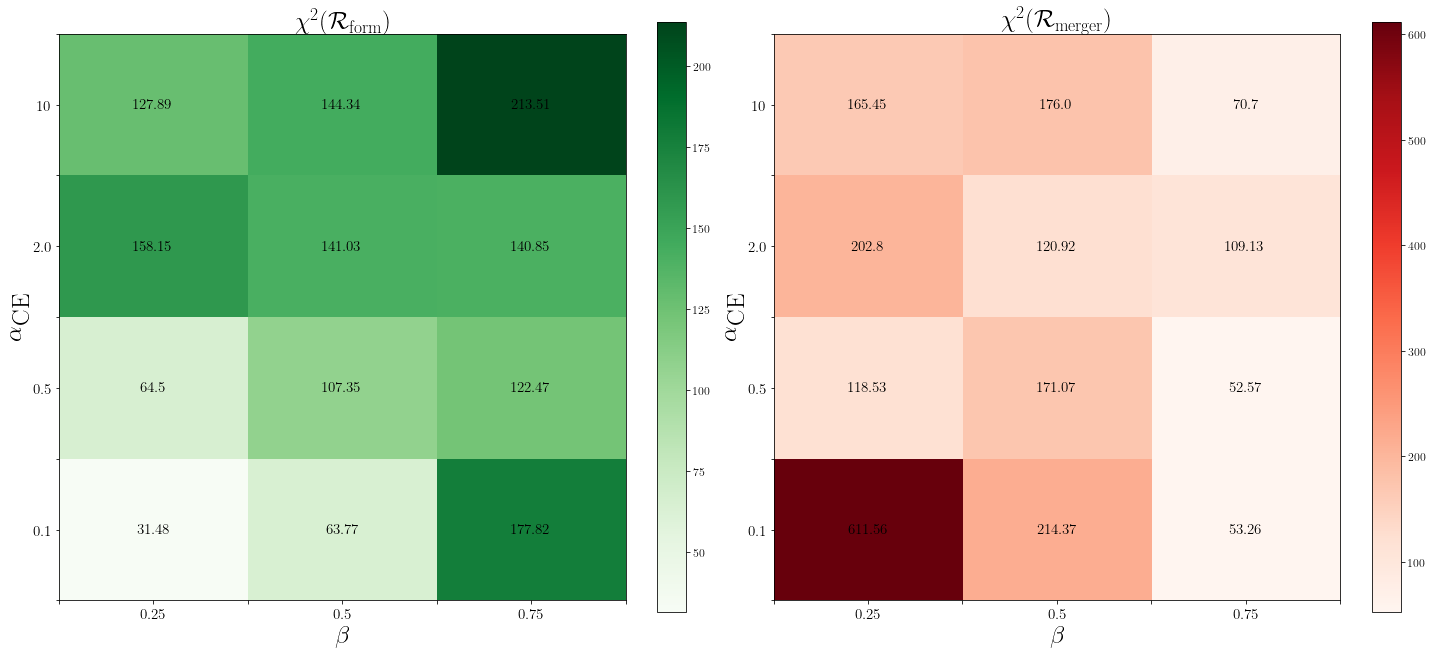

In [90]:
plot_rates_chi2(condensed_paths, alpha_vals, beta_vals, dco_type='BHNS', weight_column=weight_column,
            merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
            no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
            max_redshift_detection=max_redshift_detection,
            redshift_step=redshift_step, z_first_SF=z_first_SF,
            m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
            fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
            mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
            min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
            sensitivity=sensitivity, snr_threshold=snr_threshold,
            Mc_max=Mc_max, Mc_step=Mc_step,
            eta_max=eta_max, eta_step=eta_step,
            snr_max=snr_max, snr_step=snr_step, lw=0.5)

## c) BBH

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_2055/3883776586.py:65: UserWarning: Maximum chirp mass used for detectability calculation is below maximum binary chirp mass * (1+maximum redshift for detectability calculation)
  FCI.find_detection_rate(


Average_SF_mass_needed =  79189206.91718136 solMass
Average_SF_mass_needed =  79079208.925362 solMass
Average_SF_mass_needed =  79395659.07085004 solMass
Average_SF_mass_needed =  79155899.24192291 solMass
Average_SF_mass_needed =  79092893.22670448 solMass
Average_SF_mass_needed =  79429041.28106329 solMass
Average_SF_mass_needed =  79380983.95686427 solMass
Average_SF_mass_needed =  79264399.4505122 solMass
Average_SF_mass_needed =  79011751.47678281 solMass
Average_SF_mass_needed =  79202354.06954557 solMass
Average_SF_mass_needed =  79438058.01457481 solMass
Average_SF_mass_needed =  79045049.98307285 solMass


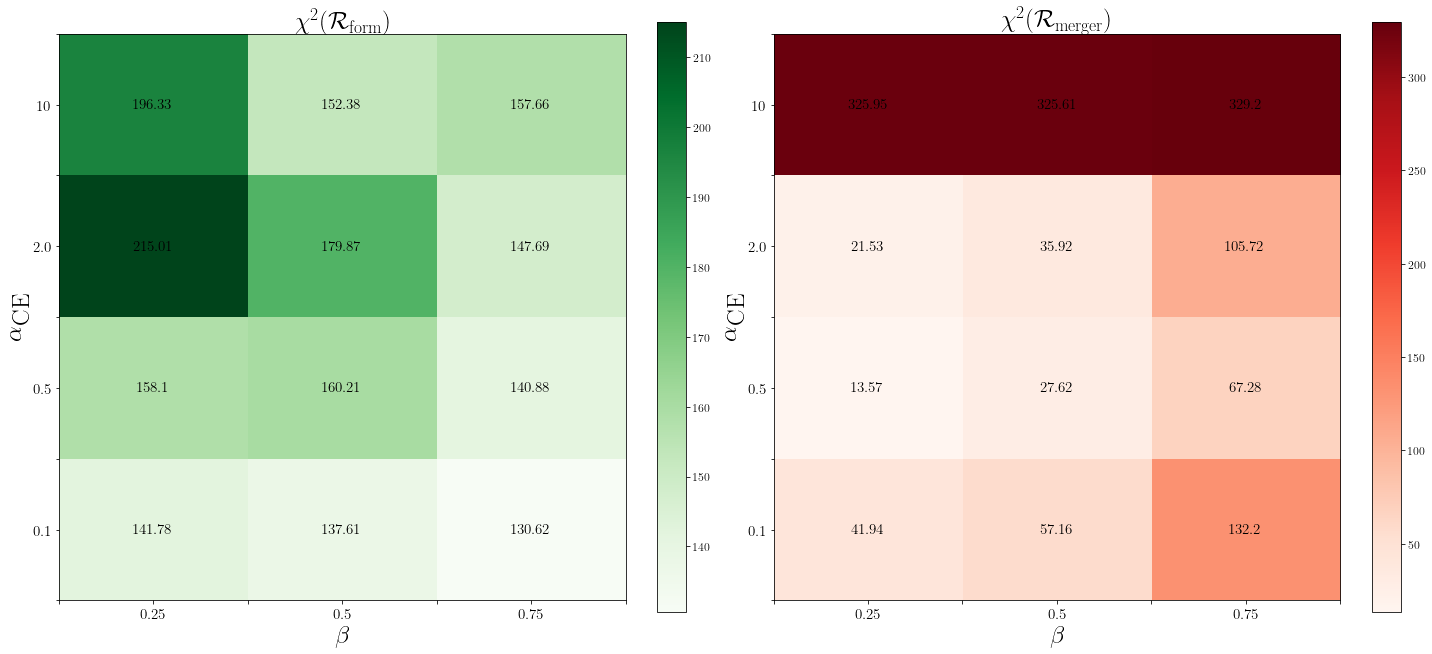

In [91]:
plot_rates_chi2(condensed_paths, alpha_vals, beta_vals, dco_type='BBH', weight_column=weight_column,
            merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
            no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
            max_redshift_detection=max_redshift_detection,
            redshift_step=redshift_step, z_first_SF=z_first_SF,
            m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
            fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
            mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
            min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
            sensitivity=sensitivity, snr_threshold=snr_threshold,
            Mc_max=Mc_max, Mc_step=Mc_step,
            eta_max=eta_max, eta_step=eta_step,
            snr_max=snr_max, snr_step=snr_step, lw=0.5)

# 1. REDO RATES WITH FIDUCIAL MSSFR